In [79]:
import os
import tensorflow as tf
import glob
import numpy as np
import sys
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from sklearn.metrics import roc_curve, auc

from config import cfg
from data_generator import DataGenerator
from centernet3D import Mediastinal_3dcenternet
from classifier import Classifier, ClassifierTorch

In [80]:
from pytorch_model.resnet_3D import focal_loss
from utils import froc, draw_pred_results, load_raw_data, hu2gray, nms_3d, IOU_3d
from data_processor import resize

In [81]:
import cv2
import imageio
import pickle

In [4]:
with open(cfg.cross_validation, 'r') as f:
    cv = json.load(f)

In [4]:
datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file=cfg.test_results_file2)
test_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file=cfg.test_results_file)

loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


In [5]:
model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls2_2_torch_spacing1')
model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=2, 
                        model_dir=model_dir, config=cfg, fold='fold0', num_classes2=2)

In [6]:
train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file=cfg.train_results_file, 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188


In [7]:
train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file='results/fold0.json', 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188


In [8]:
model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold0/resnet18_epoch61_0.91_0.76.pth')

In [7]:
checkpoint_file = model.find_last()
if not os.path.exists(checkpoint_file):
    print('no pretrained weight file found...')
else:
    print('loading pretrained from ', checkpoint_file)
    model.load_weights(checkpoint_file, by_name=False)

loading pretrained from  ./checkpoints/resnet18_cls3_torch_spacing1/fold0/resnet18_epoch77_0.72_0.95.pth


In [5]:
def test(datagenerator):
    batch_size = 16
    correct = 0
    cnt = 0
    TPs = 0.0
    num_postive = 0.0
    num_test = len(datagenerator.train_list)
    res = []
    y_true = []
    names = datagenerator.train_list.copy()
    # num_test = 2
    model.model.eval()
    with torch.no_grad():
        for name in tqdm(datagenerator.train_list):
            ims_all, labels_all = datagenerator.get_all_bbox(name, channel_first=True, size=(64, 64, 64))
            y_true.append(labels_all)
            # print(ims.shape)
            preds = []
            for i in range(0, ims_all.shape[0], batch_size):
                ims = torch.tensor(ims_all[i:i+batch_size], dtype=torch.float32).cuda()
                labels = torch.tensor(labels_all[i:i+batch_size], dtype=torch.long).cuda()
                pred = model.model(ims)
                print(pred)
                preds.append(pred.detach().cpu())
                # print(cnt_preds.shape, sze_preds.shape)
    #             loss = criterion(pred, labels)
                pred = torch.argmax(pred, dim=1).detach()
                correct += torch.eq(pred, labels).sum().item()
                cnt += labels.shape[0]
                stat = labels > 0
                TP = torch.eq(pred[stat], labels[stat]).sum().item()
                N = stat.sum().item()
                TPs += TP
                num_postive += N
            res.append(torch.cat(preds, 0))
    #         names.append()
    #             test_loss.append(loss.cpu().item())
        # print(cnt_loss, sze_loss)

    test_acc = correct / cnt
    recall = TPs / num_postive
    return y_true, res, test_acc, recall

In [6]:
def test2(datagenerator, dump=True):
    batch_size = 16
    correct = 0
    cnt = 0
    TPs = 0.0
    num_postive = 0.0
    num_test = len(datagenerator.train_list)
    res_dict = {}
    res = []
    y_true = []
    names = datagenerator.train_list.copy()
    # num_test = 2
    model.model.eval()
    with torch.no_grad():
        for name in tqdm(datagenerator.train_list):
            temp = {}
            ims_all, labels_all = datagenerator.get_all_bbox(name, channel_first=True, size=(64, 64, 64))
            y_true.append(labels_all)
            # print(ims.shape)
            preds1, preds2 = [], []
            for i in range(0, ims_all.shape[0], batch_size):
                ims = torch.tensor(ims_all[i:i+batch_size], dtype=torch.float32).cuda()
                labels = torch.tensor(labels_all[i:i+batch_size], dtype=torch.long).cuda()
                pred1, pred2 = model.model(ims)
                pred1 = torch.softmax(pred1, dim=1)
                pred2 = torch.softmax(pred2, dim=1)
                preds1.append(pred1.detach().cpu())
                preds2.append(pred2.detach().cpu())
            res.append((torch.cat(preds1, 0), torch.cat(preds2, 0)))
            if dump:
                temp['y_true'] = np.array(labels_all, dtype=np.int32).tolist()
                temp['y_pred1'] = res[-1][0].numpy().tolist()
                temp['y_pred2'] = res[-1][1].numpy().tolist()
                res_dict[name] = temp
    if dump:
        return y_true, res, res_dict
    else:
        return y_true, res

In [7]:
def test_cls(datagenerator, dump=True):
    batch_size = 16
    correct = 0
    cnt = 0
    TPs = 0.0
    num_postive = 0.0
    num_test = len(datagenerator.train_list)
    res_dict = {}
    res = []
    y_true = []
    names = datagenerator.train_list.copy()
    # num_test = 2
    model.model.eval()
    with torch.no_grad():
        for name in tqdm(datagenerator.train_list):
            temp = {}
            ims_all, labels_all = datagenerator.get_all_bbox(name, channel_first=True, size=(64, 64, 64))
            y_true.append(labels_all)
            # print(ims.shape)
            preds1, preds2 = [], []
            preds = []
            for i in range(0, ims_all.shape[0], batch_size):
                ims = torch.tensor(ims_all[i:i+batch_size], dtype=torch.float32).cuda()
                labels = torch.tensor(labels_all[i:i+batch_size], dtype=torch.long).cuda()
                pred = model.model(ims)
                pred = torch.softmax(pred, dim=1).detach().cpu()
                pred1 = torch.empty((pred.shape[0], 2))
                pred2 = torch.empty_like(pred1)
                pred1[:, 0] = pred[:, 0]
                pred1[:, 1] = pred[:, 1] + pred[:, 2]
                pred2[:, 0] = pred[:, 1] / (1-pred[:, 0])
                pred2[:, 1] = pred[:, 2] / (1-pred[:, 0])
                preds1.append(pred1)
                preds2.append(pred2)
            res.append((torch.cat(preds1, 0), torch.cat(preds2, 0)))
            if dump:
                temp['y_true'] = np.array(labels_all, dtype=np.int32).tolist()
                temp['y_pred1'] = res[-1][0].numpy().tolist()
                temp['y_pred2'] = res[-1][1].numpy().tolist()
                res_dict[name] = temp
    if dump:
        return y_true, res, res_dict
    else:
        return y_true, res

In [8]:
with open("results2/detection.json", 'r') as f:
    detection_res = json.load(f)

In [11]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
# for fold_id in ['fold2', 'fold3', 'fold4']:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'densenet_final_cls2_2')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_name='densenet', is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/densenet_final_cls2_2/fold0/densenet_epoch12_0.90_0.74_0.60.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/densenet_final_cls2_2/fold1/densenet_epoch10_0.91_0.76_0.52.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/densenet_final_cls2_2/fold2/densenet_epoch5_0.90_0.77_0.44.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/densenet_final_cls2_2/fold3/densenet_epoch19_0.91_0.74_0.68.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/densenet_final_cls2_2/fold4/densenet_epoch20_0.91_0.75_0.69.pth')

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                annotation_file=cfg.train_anno_file, results_file='./results2/detection.json', 
                                label_file=cfg.label_file, cross_validation=cv[fold_id])
    _, _, res_dict = test2(train_datagenerator, dump=True)
    with open('./results2/%s_fp_densenet.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/228 [00:00<?, ?it/s]

load annotation done
found test images: 228


100%|██████████| 228/228 [17:25<00:00,  4.02s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [16:42<00:00,  4.89s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [17:36<00:00,  4.98s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [13:05<00:00,  3.55s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [18:25<00:00,  4.57s/it]


In [8]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
# for fold_id in ['fold2', 'fold3', 'fold4']:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'vgg16_final_cls2_2')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_name='vgg16', is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/vgg16_final_cls2_2/fold0/vgg16_epoch11_0.91_0.75_0.67.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/vgg16_final_cls2_2/fold1/vgg16_epoch15_0.91_0.73_0.46.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/vgg16_final_cls2_2/fold2/vgg16_epoch15_0.91_0.77_0.57.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/vgg16_final_cls2_2/fold3/vgg16_epoch17_0.91_0.77_0.60.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/vgg16_final_cls2_2/fold4/vgg16_epoch14_0.93_0.72_0.38.pth')

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                annotation_file=cfg.train_anno_file, results_file='./results2/detection.json', 
                                label_file=cfg.label_file, cross_validation=cv[fold_id])
    _, _, res_dict = test2(train_datagenerator, dump=True)
    with open('./results2/%s_fp_vgg.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/228 [00:00<?, ?it/s]

load annotation done
found test images: 228


100%|██████████| 228/228 [18:22<00:00,  4.28s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [17:39<00:00,  5.17s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [18:47<00:00,  5.24s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [13:39<00:00,  3.70s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [19:37<00:00,  4.92s/it]


In [9]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
# for fold_id in ['fold4']:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'seresnet18_final_label1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=True, is_training=True, num_classes=2, 
                    model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18se_final_cls2_2/fold0/seresnet18_epoch6_0.87_0.76_0.60.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18se_final_cls2_2/fold1/seresnet18_epoch4_0.92_0.76_0.63.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/resnet18se_final_cls2_2/fold2/seresnet18_epoch10_0.95_0.78_0.60.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18se_final_cls2_2/fold3/seresnet18_epoch10_0.94_0.80_0.65.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18se_final_cls2_2/fold4/seresnet18_epoch8_0.95_0.79_0.68.pth')

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                annotation_file=cfg.train_anno_file, results_file='./results2/detection.json', 
                                label_file=cfg.label_file, cross_validation=cv[fold_id])
    _, _, res_dict = test2(train_datagenerator, dump=True)
    with open('./results2/%s_fp_se.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/228 [00:00<?, ?it/s]

load annotation done
found test images: 228


100%|██████████| 228/228 [31:50<00:00,  7.82s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [29:34<00:00,  8.73s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [34:15<00:00,  9.27s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [21:01<00:00,  6.51s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [36:05<00:00,  9.89s/it]


In [13]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
# for fold_id in ["fold0"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls3_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=True, is_training=True, num_classes=3, 
                            model_dir=model_dir, config=cfg, fold=fold_id)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18se_final_cls3/fold0/seresnet18_epoch7_0.91_0.69.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18se_final_cls3/fold1/seresnet18_epoch7_0.92_0.69.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/resnet18se_final_cls3/fold2/seresnet18_epoch10_0.93_0.73.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18se_final_cls3/fold3/seresnet18_epoch10_0.92_0.69.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18se_final_cls3/fold4/seresnet18_epoch9_0.93_0.72.pth')

#     train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
#                                       annotation_file=cfg.train_anno_file, results_file='results/%s_FPN_fpr.json' % fold_id, 
#                                         label_file=cfg.label_file, cross_validation=cv[fold_id])
    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                            annotation_file=cfg.train_anno_file, results_file='./results2/detection.json', 
                            label_file=cfg.label_file, cross_validation=cv[fold_id])
    _, _, res_dict = test_cls(train_datagenerator)
    with open('./results2/%s_fp_se_cls3.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/228 [00:00<?, ?it/s]

load annotation done
found test images: 228


100%|██████████| 228/228 [31:54<00:00,  7.84s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [29:51<00:00,  8.84s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [34:23<00:00,  9.26s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [20:56<00:00,  6.24s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/227 [00:00<?, ?it/s]

load annotation done
found test images: 227


100%|██████████| 227/227 [37:00<00:00,  9.69s/it]


In [39]:
model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls2_2_torch_spacing1')
model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=2, 
                        model_dir=model_dir, config=cfg, fold='fold0', num_classes2=2)
model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold0/resnet18_epoch61_0.91_0.76.pth')

train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file='results/fold0.json', 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])
test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_test.json')
test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_test.json')
_, _, res_dict = test2(train_datagenerator, dump=True)
_, _, res_dict1 = test2(test_datagenerator1, dump=True)
_, _, res_dict2 = test2(test_datagenerator2, dump=True)
res_dict1.update(res_dict2)
with open('./results/fold0_fp.json', 'w') as f:
    json.dump(res_dict, f)
with open('./results/fold0_fp_test.json', 'w') as f:
    json.dump(res_dict1, f)

train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                  annotation_file=cfg.train_anno_file, results_file='results/fold0_FPN.json', 
                                    label_file=cfg.label_file, cross_validation=cv['fold0'])
test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_FPN_test.json')
test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                  annotation_file=cfg.test_anno_file, results_file='./results/fold0_FPN_test.json')
_, _, res_dict = test2(train_datagenerator)
_, _, res_dict1 = test2(test_datagenerator1)
_, _, res_dict2 = test2(test_datagenerator2)
res_dict1.update(res_dict2)
with open('./results/fold0_FPN_fp.json', 'w') as f:
    json.dump(res_dict, f)
with open('./results/fold0_FPN_fp_test.json', 'w') as f:
    json.dump(res_dict1, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13
loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json







  0%|          | 0/2 [00:00<?, ?it/s]

load annotation done
found test images: 13







 50%|█████     | 1/2 [00:09<00:09,  9.19s/it]




100%|██████████| 2/2 [00:17<00:00,  8.97s/it]

In [5]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls2_2_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold0/resnet18_epoch61_0.91_0.76.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold1/resnet18_epoch80_0.94_0.81.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold2/resnet18_epoch60_0.94_0.85.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold3/resnet18_epoch80_0.95_0.83.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18_cls2_2_torch_spacing1/fold4/resnet18_epoch66_0.94_0.86.pth')

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
    _, _, res_dict = test2(train_datagenerator, dump=True)
    _, _, res_dict1 = test2(test_datagenerator1, dump=True)
    _, _, res_dict2 = test2(test_datagenerator2, dump=True)
    res_dict1.update(res_dict2)
    with open('./results/%s_fp.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_fp_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s_FPN.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    _, _, res_dict = test2(train_datagenerator)
    _, _, res_dict1 = test2(test_datagenerator1)
    _, _, res_dict2 = test2(test_datagenerator2)
    res_dict1.update(res_dict2)
    with open('./results/%s_FPN_fp.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_FPN_fp_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/188 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [02:00<00:00,  8.91s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/188 [00:00<?, ?it/s]

load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:42<00:00, 11.66s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:01<00:00, 10.13s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:40<00:00, 12.38s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:23<00:00, 11.44s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [03:08<00:00, 13.92s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from 

  0%|          | 0/187 [00:00<?, ?it/s]

 /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [01:54<00:00,  7.79s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [03:11<00:00, 14.41s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [01:48<00:00,  8.13s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:25<00:00, 11.86s/it]


In [24]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18se_cls2_2_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=True, is_training=True, num_classes=2, 
                            model_dir=model_dir, config=cfg, fold=fold_id, num_classes2=2)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold0/seresnet18_epoch79_0.92_0.81.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold1/seresnet18_epoch53_0.90_0.83.pth')
    elif fold_id == "fold2":
#         continue3
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold3/seresnet18_epoch76_0.95_0.83.pth')
    elif fold_id == "fold3":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold3/seresnet18_epoch72_0.92_0.84.pth')
    elif fold_id == "fold4":
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold4/seresnet18_epoch80_0.91_0.88.pth')

#     train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
#                                       annotation_file=cfg.train_anno_file, results_file='results/%s.json' % fold_id, 
#                                         label_file=cfg.label_file, cross_validation=cv[fold_id])
#     test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
#                                 annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
#     test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
#                                 annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
#     _, _, res_dict = test2(train_datagenerator, dump=True)
#     _, _, res_dict1 = test2(test_datagenerator1, dump=True)
#     _, _, res_dict2 = test2(test_datagenerator2, dump=True)
#     res_dict1.update(res_dict2)
#     with open('./results/%s_fp.json' % fold_id, 'w') as f:
#         json.dump(res_dict, f)
#     with open('./results/%s_fp_test.json' % fold_id, 'w') as f:
#         json.dump(res_dict1, f)

    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_test.json' % fold_id)
    _, _, res_dict = test2(train_datagenerator)
    _, _, res_dict1 = test2(test_datagenerator1)
    _, _, res_dict2 = test2(test_datagenerator2)
    res_dict1.update(res_dict2)
    with open('./results/%s_fp_se.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_fp_se_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

  0%|          | 0/188 [00:00<?, ?it/s]

loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 188
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [02:06<00:00, 10.12s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [02:06<00:00,  9.17s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 13


100%|██████████| 13/13 [02:30<00:00, 12.91s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [01:59<00:00,  9.53s/it]


loading annotations from  /home/jxw/Downloads/mediastinal_1/annoation/annoation_128.json
load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json


  0%|          | 0/187 [00:00<?, ?it/s]

load annotation done
found test images: 187
loading annotations from  /home/jxw/Downloads/jiaotong_test/annoation_128.json
load annotation done
found test images: 13


100%|██████████| 13/13 [01:53<00:00,  8.42s/it]


In [ ]:
for fold_id in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    model_dir = os.path.join(cfg.CHECKPOINTS_ROOT, 'resnet18_cls3_torch_spacing1')
    model = ClassifierTorch(cfg.INPUT_SHAPE, model_depth=18, senet=False, is_training=True, num_classes=3, 
                            model_dir=model_dir, config=cfg, fold=fold_id)
    if fold_id == "fold0":
        model.load_weights('./checkpoints/resnet18_cls3_torch_spacing1/fold0/resnet18_epoch37_0.91_0.72.pth')
    elif fold_id == "fold1":
        model.load_weights('./checkpoints/resnet18_cls3_torch_spacing1/fold1/resnet18_epoch75_0.94_0.74.pth')
    elif fold_id == "fold2":
        model.load_weights('./checkpoints/resnet18_cls3_torch_spacing1/fold2/resnet18_epoch20_0.93_0.75.pth')
    elif fold_id == "fold3":
        continue
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold3/seresnet18_epoch72_0.92_0.84.pth')
    elif fold_id == "fold4":
        continue
        model.load_weights('./checkpoints/resnet18se_cls2_2_torch_spacing1/fold4/seresnet18_epoch80_0.91_0.88.pth')

#     train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
#                                       annotation_file=cfg.train_anno_file, results_file='results/%s_FPN_fpr.json' % fold_id, 
#                                         label_file=cfg.label_file, cross_validation=cv[fold_id])
    train_datagenerator = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.DATA_ROOT,
                                      annotation_file=cfg.train_anno_file, results_file='results/%s_FPN.json' % fold_id, 
                                        label_file=cfg.label_file, cross_validation=cv[fold_id])
    test_datagenerator1 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT2,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    test_datagenerator2 = DataGenerator(cfg, training=False, mode='cls', data_root=cfg.TEST_DATA_ROOT,
                                annotation_file=cfg.test_anno_file, results_file='./results/%s_FPN_test.json' % fold_id)
    
    _, _, res_dict = test2(train_datagenerator)
    _, _, res_dict1 = test2(test_datagenerator1)
    _, _, res_dict2 = test2(test_datagenerator2)
    res_dict1.update(res_dict2)
    with open('./results/%s_FPN_fp_se.json' % fold_id, 'w') as f:
        json.dump(res_dict, f)
    with open('./results/%s_FPN_fp_se_test.json' % fold_id, 'w') as f:
        json.dump(res_dict1, f)

In [75]:
def get_sensitivity(fps, tps):
    res = []
    for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
        for i in range(len(fps)):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                res.append(temp)
                print(n, "%.4f"%temp)
                break
            if i == len(fps)-1:
                res.append(temp)
                print(n, "%.4f"%temp)
    avg = np.mean(res)
    res.append(avg)
    print("avg: ", "%.4f"%np.mean(res))
    return res

In [76]:
def get_sen(fps, tps):
    res = []
    for n in np.arange(0, 8, 0.05):
        flag = True
        for i in range(len(fps)-1):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                res.append(temp)
                flag = False
                break
        if flag:
            res.append(0)
    return res

In [7]:
def get_FPR_Result(detect, cls):
    cls_result = {}
    for key in detect.keys():
        now = {}
        now.update(detect[key])
        if key not in cls:
            continue
        final_score = np.array(cls[key]["y_pred1"])[:, 1] #+ np.array(now['score'])
#         print(sorted(final_score)[-3:])
        idx = final_score>=0.3
        idx[:1] = True
        
        now['bbox_pred'] = np.array(detect[key]['bbox_pred'])[idx].tolist()
        now['score'] = np.array(detect[key]['score'])[idx].tolist()
        now['cls_pred'] = np.array(cls[key]["y_pred2"])[idx].tolist()
        now['cls_true'] = np.array(cls[key]['y_true'])[idx].tolist()
        now['score2'] = np.array(cls[key]['y_pred1'])[idx].tolist()
        cls_result[key] = now
    return cls_result

In [8]:
def get_cls_result(cls):
    y_pred = []
    y_true = []
    for name in cls.keys():
        y_pred.append(np.array(cls[name]['cls_pred']))
        y_true.append(np.array(cls[name]['cls_true']))
    y_pred = np.vstack(y_pred)
    y_true = np.hstack(y_true)
    idx = np.where(y_true > 0)
    y_pred = y_pred[idx]
    y_true = y_true[idx] - 1
    y_pred_ = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred_ == y_true) / len(y_pred_)
    return y_pred, y_true, acc

In [9]:
def get_fp_cls_result(cls):
    y_pred = []
    y_true = []
    for name in cls.keys():
        y_pred.append(np.array(cls[name]['y_pred1']))
        y_true.append(np.array(cls[name]['y_true']))
    y_pred = np.vstack(y_pred)
    y_true = np.hstack(y_true)
    y_true[y_true > 1] = 1
    y_pred_ = np.argmax(y_pred, axis=1)
    acc = np.sum(y_pred_ == y_true) / len(y_pred_)
    return y_pred, y_true, acc

In [34]:
y_pred, y_true, acc = get_fp_cls_result(cls_vgg_results)

0.963556845896405


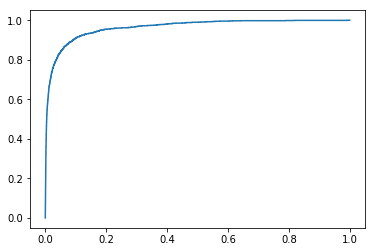

In [35]:
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])
AUC = auc(fpr, tpr)
print(AUC)
plt.plot(fpr, tpr)

In [16]:
cls_results = {}
for fold in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    print(fold)
    with open('./results2/%s_fp_densenet.json' % fold) as f:
        cls_results.update(json.load(f))

fold0
fold1
fold2
fold3
fold4


In [17]:
with open('./results2/cls_fp_densenet.json', 'w') as f:
    json.dump(cls_results, f, indent=2)

In [21]:
with open('./results2/fpr_cls_fp_densenet.json', 'w') as f:
    json.dump(fpr_result, f, indent=2)

In [8]:
detection_results = {}
detection_results_FPN = {}

cls_results = {}
cls_results_FPN = {}
cls_results_FPN_SE = {}
for fold in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    print(fold)
    cls = []
    with open('./results/%s.json' % fold) as f:
        detection_results.update(json.load(f))
    with open('./results/%s_fp.json' % fold) as f:
        cls_results.update(json.load(f))
    
    with open('./results/%s.json' % fold) as f:
        detection_results_FPN.update(json.load(f))
    with open('./results/%s_fp.json' % fold) as f:
        cls_results_FPN.update(json.load(f))

    with open('./results/%s_fp_se.json' % fold) as f:
        cls_results_FPN_SE.update(json.load(f))


fold0
fold1
fold2
fold3
fold4


In [18]:
cls_results = get_FPR_Result(detection_results, cls_results)
cls_results_FPN = get_FPR_Result(detection_results_FPN, cls_results_FPN)
cls_results_FPN_SE = get_FPR_Result(detection_results_FPN, cls_results_FPN_SE)

NameError: name 'detection_results' is not defined

In [15]:
def get_diffsize_result(lesion_size, detect_results):
    results = [{}, {}, {}, {}, {}]
    for name in detect_results.keys():
        s = np.mean(lesion_size[name][0])
        if s < 30:
            results[0][name] = detect_results[name]
        elif s >= 30 and s < 50:
            results[1][name] = detect_results[name]
        elif s >= 50 and s < 70:
            results[2][name] = detect_results[name]
        elif s >= 70 and s < 100:
            results[3][name] = detect_results[name]
        elif s >= 100:
            results[4][name] = detect_results[name]
#     for i in range(5):
#         fpr, tpr, _ = froc(results[i], method="iobb", iou_threshold=0.3, nms=False)
#         res = get_sensitivity(fpr, tpr)
    return results

In [16]:
with open('results/lesion_size.json', 'r') as f:
    lesion = json.load(f)

In [56]:
get_diffsize_result(lesion, cls_results_FPN_SE)

  0%|          | 0/178 [00:00<?, ?it/s]

0.125 0.9465
0.25 0.9616
0.5 0.9616
1 0.9616
2 0.9616
4 0.9616
8 0.9616
avg:  0.9594
0.125 0.9361
0.25 0.9537
0.5 0.9537
1 0.9537
2 0.9537
4 0.9537
8 0.9537
avg:  0.9512


100%|██████████| 52/52 [00:00<00:00, 1698.59it/s]

0.125 0.9270
0.25 0.9422
0.5 0.9569
1 0.9569
2 0.9569
4 0.9569
8 0.9569
avg:  0.9505
0.125 0.8326
0.25 0.9056
0.5 0.9417
1 0.9543
2 0.9543
4 0.9543
8 0.9543
avg:  0.9281
0.125 0.6010
0.25 0.7038
0.5 0.8934
1 0.9038
2 0.9338
4 0.9338
8 0.9338
avg:  0.8434


In [17]:
def get_matrix(y_true, y_pred):
    n = y_true.shape[0]
    y_pred1 = np.array(y_pred > 0.5, dtype=np.int)
    TP = np.sum(y_pred1[y_true == 1] == 1)
    FN = np.sum(y_true) - TP
    FP = np.sum(y_pred1) - TP
    TN = n - TP - FN - FP
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (FP + TN)
    accuracy = (TP + TN) / n
    res = {
        'TP': TP,
        'FN': FN,
        'FP': FP,
        'TN': TN,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'specificity': specificity,
        
    }
    return res
    

In [18]:
def get_multi_matrix(y_true, y_pred1, y_pred2):
    y_true = np.array(y_true)
    y_pred1 = np.argmax(np.array(y_pred1), axis=1)
    y_pred2 = np.argmax(np.array(y_pred2), axis=1) + 1
    y_pred = np.where(y_pred1 > 0, y_pred2, y_pred1)
    for i in range(3):
        print(i, np.bincount(y_pred[y_true==i]), np.sum(y_true==i))

In [19]:
def get_roc(y_true, y_pred1, y_pred2):
    y_true = np.array(y_true)
    y_pred1 = np.array(y_pred1)
    y_pred2 = np.array(y_pred2)
    
    y_true1 = np.where(y_true > 0, np.ones_like(y_true), y_true)
    y_true2 = y_true[y_true > 0] - 1
    y_pred2 = y_pred2[y_true > 0]
    fpr1, tpr1, _ = roc_curve(y_true1, y_pred1[:, 1])
    fpr2, tpr2, _ = roc_curve(y_true2, y_pred2[:, 1])
    print(get_matrix(y_true2, y_pred2[:, 1]))
#     plt.plot(fpr1, tpr1)
    return fpr2, tpr2
#     AUC = auc(fpr2, tpr2)
#     plt.plot(fpr2, tpr2)

resnet18+cls2
0 [20764  1747   768] 23279
1 [ 65 628 162] 855
2 [ 25 131 239] 395
{'TP': 254, 'FN': 141, 'FP': 170, 'TN': 685, 'accuracy': 0.7512, 'recall': 0.6430379746835443, 'precision': 0.5990566037735849, 'specificity': 0.8011695906432749}
seresnet18+cls3
0 [20437  1798  1044] 23279
1 [ 57 657 141] 855
2 [ 10 147 238] 395
seresnet18+cls2
0 [20193  1995  1091] 23279
1 [ 57 664 134] 855
2 [  7 124 264] 395
{'TP': 267, 'FN': 128, 'FP': 138, 'TN': 717, 'accuracy': 0.7872, 'recall': 0.6759493670886076, 'precision': 0.6592592592592592, 'specificity': 0.8385964912280702}


Text(0, 0.5, 'TPR')

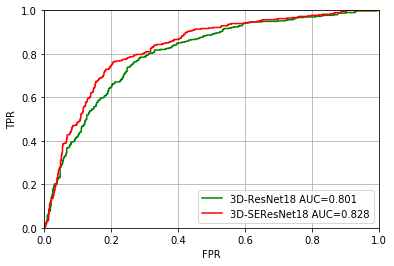

In [67]:
color = ['g', 'r']
i = 0
aucs = []
for name in cls_result_map:
    print(name)
    cls_result = cls_result_map[name]
    y_true = []
    y_pred1 = []
    y_pred2 = []
    for k in cls_result:
        cnt = (np.array(detection_results[k]['score']) >= 0.02).sum()
        y_true += cls_result[k]['y_true'][:cnt]
        y_pred1 += cls_result[k]['y_pred1'][:cnt]
        y_pred2 += cls_result[k]['y_pred2'][:cnt]
    get_multi_matrix(y_true, y_pred1, y_pred2)
    if "cls3" in name:
        continue
    fpr, tpr = get_roc(y_true, y_pred1, y_pred2)
    AUC = auc(fpr, tpr)
    aucs.append(AUC)
    plt.plot(fpr, tpr, color[i])
    i += 1
plt.legend(["3D-ResNet18 AUC=%.3f" % aucs[0], "3D-SEResNet18 AUC=%.3f" % aucs[1]], loc='lower right')
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
# plt.savefig("results2/cls2.png")

In [36]:
get_multi_matrix(y_true, y_pred1, y_pred2)

0 [123421   8114   2658]
1 [ 83 691 169]
2 [ 29 139 255]


In [46]:
for k in detection_results:
    print((np.array(detection_results[k]['score']) > 0.02).sum())
#     break

23
11
17
19
24
26
22
19
22
23
19
22
13
13
16
24
26
23
14
30
18
30
9
24
11
19
18
9
24
20
20
34
22
24
19
20
17
15
11
28
29
27
18
21
16
15
21
15
11
14
30
25
16
14
20
19
20
14
21
14
21
18
24
28
24
26
20
15
23
25
17
19
19
15
17
19
29
21
21
22
17
29
20
21
27
19
14
9
30
17
14
31
28
24
19
15
11
29
6
11
25
23
7
24
22
18
25
29
22
18
10
19
18
24
27
12
16
28
30
35
17
21
20
20
17
34
19
18
14
16
15
27
16
22
25
13
16
15
23
16
14
26
23
26
17
20
20
13
28
25
17
12
23
21
18
19
17
20
23
25
17
31
20
14
21
25
11
13
13
12
17
25
24
15
23
30
18
15
17
15
33
19
22
20
20
22
25
15
27
19
18
23
17
16
14
17
25
24
26
21
16
22
20
21
22
19
23
14
19
8
22
20
24
24
29
21
30
30
25
20
19
29
16
23
21
17
10
17
17
18
27
14
33
22
21
14
20
17
25
21
17
21
26
16
17
34
14
21
21
21
15
29
20
17
22
21
20
20
22
17
24
21
25
18
20
19
30
23
25
12
28
13
24
21
34
26
24
17
19
23
13
14
19
22
27
26
22
18
32
25
22
12
21
27
20
29
14
18
27
22
19
19
27
21
22
18
11
20
24
18
28
20
22
17
29
18
18
17
19
13
36
19
11
19
29
17
13
18
24
27
20
20
30
24
29
2

In [67]:
from sklearn.metrics import confusion_matrix

  0%|          | 0/188 [00:00<?, ?it/s]

fold0
detection:
0.125 0.8594
0.25 0.8939
0.5 0.9223
1 0.9427
2 0.9477
4 0.9577
8 0.9741
avg:  0.9283


100%|██████████| 188/188 [00:00<00:00, 1817.52it/s]


FPR:
0.125 0.9092
0.25 0.9473
0.5 0.9521
1 0.9521
2 0.9521
4 0.9521
8 0.9521
avg:  0.9453
0.7550200803212851 0.8135941644562334
fold1


100%|██████████| 187/187 [00:00<00:00, 1941.20it/s]


detection:
0.125 0.8031
0.25 0.8570
0.5 0.8770
1 0.9097
2 0.9176
4 0.9243
8 0.9376
avg:  0.8895
FPR:
0.125 0.8455
0.25 0.8767
0.5 0.9294
1 0.9390
2 0.9483
4 0.9483
8 0.9483
avg:  0.9194
0.8137254901960784 0.8561202576950608
fold2


 90%|████████▉ | 168/187 [00:00<00:00, 1675.10it/s]

detection:
0.125 0.8492
0.25 0.8931
0.5 0.9323
1 0.9440
2 0.9522
4 0.9533
8 0.9555
avg:  0.9257
FPR:
0.125 0.8901
0.25 0.9428
0.5 0.9572
1 0.9572
2 0.9572
4 0.9572
8 0.9572
avg:  0.9456
0.8558139534883721 0.8741258741258741
fold3


100%|██████████| 187/187 [00:00<00:00, 1740.12it/s]


detection:
0.125 0.8513
0.25 0.9069
0.5 0.9355
1 0.9471
2 0.9493
4 0.9538
8 0.9626
avg:  0.9295
FPR:
0.125 0.9309
0.25 0.9453
0.5 0.9569
1 0.9591
2 0.9591
4 0.9591
8 0.9591
avg:  0.9528
0.8363636363636363 0.8949724517906336
fold4


100%|██████████| 187/187 [00:00<00:00, 2011.04it/s]


detection:
0.125 0.8341
0.25 0.8925
0.5 0.9198
1 0.9262
2 0.9365
4 0.9521
8 0.9690
avg:  0.9186
FPR:
0.125 0.8951
0.25 0.9258
0.5 0.9613
1 0.9689
2 0.9689
4 0.9689
8 0.9689
avg:  0.9511
0.8571428571428571 0.89


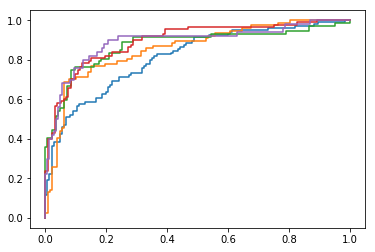

In [68]:
y_preds = []
y_trues = []
for fold in ["fold0", "fold1", "fold2", "fold3", "fold4"]:
    print(fold)
    cls = []
    with open('./results/%s.json' % fold) as f:
        detect_result1 = json.load(f)
    with open('./results/%s_fp.json' % fold) as f:
        cls_result1 = json.load(f)
    fpr_result = get_FPR_Result(detect_result1, cls_result1)
    fpr, tpr, _ = froc(detect_result1, method="iobb", iou_threshold=0.3, nms=False)
    print("detection:")
    res = get_sensitivity(fpr, tpr)
    fpr, tpr, _ = froc(fpr_result, method="iobb", iou_threshold=0.3, nms=False)
    print("FPR:")
    res = get_sensitivity(fpr, tpr)
    
    y_pred, y_true, acc = get_cls_result(fpr_result)
    y_preds.append(y_pred[:, 1])
    y_trues.append(y_true)
    tpr, fpr, th = roc_curve(y_true, y_pred[:, 1])
    AUC = auc(tpr, fpr)
    print(acc, AUC)
    plt.plot(tpr, fpr)

In [20]:
with open('./results2/detection.json', 'r') as f:
    detection_results = json.load(f)
# with open('./results2/cls_cls3_format.json', 'r') as f:
#     cls_results = json.load(f)
with open('./results2/detection_mrcnn.json', 'r') as f:
    detection_mrcnn = json.load(f)
with open('./results2/detection_runet.json', 'r') as f:
    detection_runet = json.load(f)

In [21]:
with open('./results2/cls_fp_format.json', 'r') as f:
    cls_results = json.load(f)
with open('./results2/cls_fp_se_format.json', 'r') as f:
    cls_se_results = json.load(f)
with open('./results2/cls_fp_se_cls3_format.json', 'r') as f:
    cls3_results = json.load(f)
with open('./results2/cls_fp_vgg.json', 'r') as f:
    cls_vgg_results = json.load(f)
with open('./results2/cls_fp_densenet.json', 'r') as f:
    cls_densenet_results = json.load(f)

In [22]:
with open('./results2/fpr_cls_format.json', 'r') as f:
    fpr_results = json.load(f)
with open('./results2/fpr_cls_se_format.json', 'r') as f:
    fpr_se_results = json.load(f)
with open('./results2/fpr_cls_se_cls3_format.json', 'r') as f:
    fpr3_results = json.load(f)
with open('./results2/fpr_cls_fp_vgg.json', 'r') as f:
    fpr_vgg_results = json.load(f)
with open('./results2/fpr_cls_fp_densenet.json', 'r') as f:
    fpr_densenet_results = json.load(f)

In [20]:
for k in cls_results:
    print(cls_results[k])
    print(cls3_results[k])
    break

{'y_true': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'y_pred1': [[0.013495013117790222, 0.9865049719810486], [0.9251271486282349, 0.07487282902002335], [0.934123158454895, 0.06587684899568558], [0.9644050002098083, 0.03559495136141777], [0.9825758934020996, 0.017424171790480614], [0.9796038269996643, 0.02039620280265808], [0.9770157933235168, 0.02298416756093502], [0.9927284717559814, 0.007271584589034319], [0.9963086247444153, 0.0036912953946739435], [0.9962540864944458, 0.0037459239829331636], [0.9961981177330017, 0.0038018347695469856], [0.9802383184432983, 0.01976162940263748], [0.9874243140220642, 0.012575732544064522], [0.9386012554168701, 0.

In [23]:
detection_map = {
    'our method': detection_results,
    'Mask-RCNN': detection_mrcnn,
    'Retina U-Net': detection_runet,
}
fpr_result_map = {
    'detection': detection_results,
    'resnet18': fpr_results,
    'seresnet18+cls3': fpr3_results,
    'seresnet18': fpr_se_results,
    'vgg': fpr_vgg_results,
    'densenet': fpr_densenet_results,
}
cls_result_map = {
    'resnet18': cls_results,
    'seresnet18+cls3': cls3_results,
    'seresnet18': cls_se_results,
    'vgg': cls_vgg_results,
    'densenet': cls_densenet_results,
}

In [20]:
detect = {}
for k in cls_results:
    detect[k] = detection_results[k]

In [44]:
y_trues = []
y_preds = []
for k in fpr_results:
    y1, y2, acc = get_cls_result(fpr_results[k])
    y_trues.append(y2)
    y_preds.append(y1[:, 1])

In [46]:
for i in range(len(y_trues)):
    print(get_matrix(y_trues[i], y_preds[i]))

{'TP': 327, 'FN': 78, 'FP': 92, 'TN': 804, 'accuracy': 0.8693312836279785, 'recall': 0.8074074074074075, 'precision': 0.7804295942720764, 'specificity': 0.8973214285714286}
{'TP': 272, 'FN': 129, 'FP': 74, 'TN': 820, 'accuracy': 0.8432432432432433, 'recall': 0.6783042394014963, 'precision': 0.7861271676300579, 'specificity': 0.9172259507829977}
{'TP': 339, 'FN': 57, 'FP': 99, 'TN': 787, 'accuracy': 0.8783151326053042, 'recall': 0.8560606060606061, 'precision': 0.773972602739726, 'specificity': 0.8882618510158014}


In [24]:
fpr_result = get_FPR_Result(detection_results, cls_results)
y_pred, y_true, acc = get_cls_result(fpr_result)
y_true1, y_pred1 = y_true, y_pred[:, 1]
get_matrix(y_true1, y_pred1)

{'TP': 269,
 'FN': 150,
 'FP': 177,
 'TN': 735,
 'accuracy': 0.754320060105184,
 'recall': 0.6420047732696897,
 'precision': 0.6031390134529148,
 'specificity': 0.805921052631579}

In [25]:
fpr_result = get_FPR_Result(detection_results, cls_se_results)
y_pred, y_true, acc = get_cls_result(fpr_result)
y_true1, y_pred1 = y_true, y_pred[:, 1]
get_matrix(y_true1, y_pred1)

{'TP': 285,
 'FN': 135,
 'FP': 148,
 'TN': 777,
 'accuracy': 0.7895910780669145,
 'recall': 0.6785714285714286,
 'precision': 0.6581986143187067,
 'specificity': 0.84}

In [26]:
fpr_result = get_FPR_Result(detection_results, cls_vgg_results)
y_pred, y_true, acc = get_cls_result(fpr_result)
y_true1, y_pred1 = y_true, y_pred[:, 1]
get_matrix(y_true1, y_pred1)

{'TP': 211,
 'FN': 203,
 'FP': 156,
 'TN': 745,
 'accuracy': 0.7269961977186312,
 'recall': 0.5096618357487923,
 'precision': 0.5749318801089919,
 'specificity': 0.8268590455049944}

In [27]:
fpr_result = get_FPR_Result(detection_results, cls_densenet_results)
y_pred, y_true, acc = get_cls_result(fpr_result)
y_true1, y_pred1 = y_true, y_pred[:, 1]
get_matrix(y_true1, y_pred1)

{'TP': 253,
 'FN': 166,
 'FP': 170,
 'TN': 751,
 'accuracy': 0.7492537313432835,
 'recall': 0.60381861575179,
 'precision': 0.5981087470449172,
 'specificity': 0.8154180238870793}

In [68]:
dif_size_fpr = get_diffsize_result(lesion, fpr_se_results)

In [27]:
for k in cls_results:
    print(cls_results[k].keys())
    break

dict_keys(['y_true', 'y_pred1', 'y_pred2'])


In [28]:
for k in fpr_result_map:
    if k == "detection":
        continue
    print(k)
    y1, y2, acc = get_cls_result(fpr_result_map[k])
    print(get_matrix(y2, y1[:, 1]))

resnet18
{'TP': 269, 'FN': 150, 'FP': 177, 'TN': 735, 'accuracy': 0.754320060105184, 'recall': 0.6420047732696897, 'precision': 0.6031390134529148, 'specificity': 0.805921052631579}
seresnet18+cls3
{'TP': 259, 'FN': 161, 'FP': 162, 'TN': 759, 'accuracy': 0.7591349739000746, 'recall': 0.6166666666666667, 'precision': 0.6152019002375297, 'specificity': 0.8241042345276873}
seresnet18
{'TP': 285, 'FN': 135, 'FP': 148, 'TN': 777, 'accuracy': 0.7895910780669145, 'recall': 0.6785714285714286, 'precision': 0.6581986143187067, 'specificity': 0.84}
vgg
{'TP': 211, 'FN': 203, 'FP': 156, 'TN': 745, 'accuracy': 0.7269961977186312, 'recall': 0.5096618357487923, 'precision': 0.5749318801089919, 'specificity': 0.8268590455049944}
densenet
{'TP': 253, 'FN': 166, 'FP': 170, 'TN': 751, 'accuracy': 0.7492537313432835, 'recall': 0.60381861575179, 'precision': 0.5981087470449172, 'specificity': 0.8154180238870793}


In [69]:
for fpr in dif_size_fpr:
    print(len(fpr.keys()))
    y1, y2, acc = get_cls_result(fpr)
    a = get_matrix(y2, y1[:, 1])
    print(a)

353
{'TP': 25, 'FN': 38, 'FP': 17, 'TN': 249, 'accuracy': 0.8328267477203647, 'recall': 0.3968253968253968, 'precision': 0.5952380952380952, 'specificity': 0.9360902255639098}
361
{'TP': 78, 'FN': 37, 'FP': 45, 'TN': 221, 'accuracy': 0.7847769028871391, 'recall': 0.6782608695652174, 'precision': 0.6341463414634146, 'specificity': 0.8308270676691729}
232
{'TP': 103, 'FN': 22, 'FP': 31, 'TN': 135, 'accuracy': 0.8178694158075601, 'recall': 0.824, 'precision': 0.7686567164179104, 'specificity': 0.8132530120481928}
118
{'TP': 55, 'FN': 17, 'FP': 35, 'TN': 79, 'accuracy': 0.7204301075268817, 'recall': 0.7638888888888888, 'precision': 0.6111111111111112, 'specificity': 0.6929824561403509}
72
{'TP': 24, 'FN': 21, 'FP': 20, 'TN': 93, 'accuracy': 0.740506329113924, 'recall': 0.5333333333333333, 'precision': 0.5454545454545454, 'specificity': 0.8230088495575221}


0.8026014843193904 0.754320060105184 resnet18
0.830958815958816 0.7895910780669145 seresnet18
0.742965411485896 0.7269961977186312 vgg
0.7853415012736493 0.7492537313432835 densenet


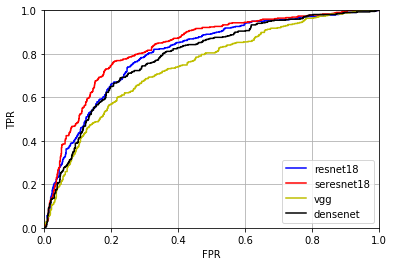

In [74]:
colors = ['b', 'g', 'r', 'y', 'k']
legend = []
for i, key in enumerate(cls_result_map):
    if 'cls3' in key:
        continue
#     y_pred, y_true, acc = get_fp_cls_result(cls_result_map[key])
    y_pred, y_true, acc = get_cls_result(fpr_result_map[key])
    fpr, tpr, th = roc_curve(y_true, y_pred[:, 1])
    print(auc(fpr, tpr), acc, key)
    legend.append(key)
    plt.plot(fpr, tpr, colors[i])
# fpr1, tpr1, th1 = roc_curve(y_true1, y_pred1)
# AUC1 = auc(fpr1, tpr1)
# AUC2 = auc(fpr2, tpr2)
# print(AUC1, AUC2)
# print(np.mean((y_pred1 >= 0.5) == y_true1), np.mean((y_pred2 >= 0.5) == y_true2))
# plt.plot(fpr1, tpr1, 'b')
# plt.plot(fpr2, tpr2, 'r')
plt.legend(legend, loc='lower right')
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig("results2/cls_4compare.png")

In [24]:
fpr, tpr, _ = froc(detection_results, method="iobb", iou_threshold=0.3, nms=False)

100%|██████████| 1136/1136 [00:00<00:00, 1516.18it/s]


0.125 0.8126
0.25 0.8731
0.5 0.9141
1 0.9386
2 0.9486
4 0.9546
8 0.9631
avg:  0.9150


[0.8125800256081946,
 0.873093778498328,
 0.9140884953735356,
 0.9386032863849766,
 0.9486375554500406,
 0.9545976970034025,
 0.9630812521959492,
 0.9149545843592038]

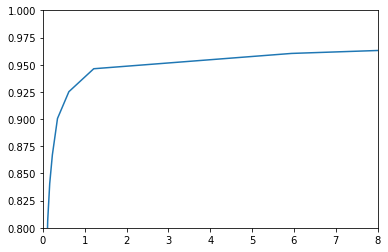

In [25]:
plt.plot(fpr, tpr)
plt.xlim(0, 8)
plt.ylim(0.8, 1.0)
get_sensitivity(fpr, tpr)

0.125 0.8502
0.25 0.9113
0.5 0.9416
1 0.9494
2 0.9579
4 0.9664
8 0.9701
avg:  0.9353


[0.8501617814998097,
 0.91130403108305,
 0.9415864160868828,
 0.9494177413880875,
 0.9578899643934554,
 0.9664381339229918,
 0.9700786344918201,
 0.9352681004094424]

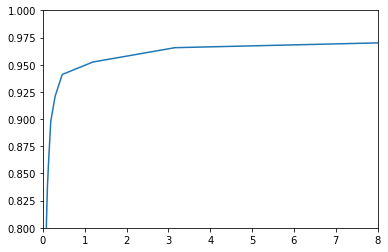

In [23]:
plt.plot(fpr, tpr)
plt.xlim(0, 8)
plt.ylim(0.8, 1.0)
get_sensitivity(fpr, tpr)

In [38]:
for i in idx:
    print(names[i])
    iou = IOU_3d(fpr_results[names[i]]['bbox_pred'], fpr_results[names[i]]['bbox_gt'][0])
    for io in iou:
        if io > 0:
            print("##########")
            break
    print(fpr_results[names[i]]['score2'])

0628962
[[0.9580878615379333, 0.04191213473677635]]
0521447
[[0.9995304346084595, 0.0004695329407695681]]
0940910
[[0.00021854419901501387, 0.9997814297676086], [0.05011661350727081, 0.9498833417892456], [0.19657140970230103, 0.8034286499023438], [0.2856578528881073, 0.7143421173095703]]
0775636
[[0.9997901320457458, 0.000209941528737545], [0.5424940586090088, 0.4575059413909912]]
0685289
[[0.9627137184143066, 0.03728633001446724], [0.6455392241477966, 0.35446077585220337]]
0784582
##########
[[0.0026839463971555233, 0.9973160624504089]]
0259933
[[0.9996950626373291, 0.0003049430961254984], [0.6475083827972412, 0.35249167680740356]]
0758211
##########
[[0.8946265578269958, 0.10537345707416534], [0.02408437617123127, 0.9759156703948975]]
1001655
[[0.9998182654380798, 0.00018181398627348244]]
0361248
[[0.9574060440063477, 0.04259392246603966]]
0553929
[[0.17903609573841095, 0.820963978767395]]
0453066
##########
[[0.9971100687980652, 0.0028899351600557566], [0.6394872069358826, 0.3605127

In [36]:
sen_FPN = np.mean(np.array(sen1), axis=0)
sen_FPN_fpr = np.mean(np.array(sen2), axis=0)

In [53]:
sen_FPN_fpr2 = np.mean(np.array(sen2), axis=0)

In [12]:
sen = np.mean(np.array(sen1), axis=0)
sen_fpr = np.mean(np.array(sen2), axis=0)

In [10]:
sen_fpr2 = np.mean(np.array(sen2), axis=0)

In [68]:
sens = []
for k in fpr_results:
    print(k)
    fpr, tpr, _ = froc(fpr_results[k], method='iobb', iou_threshold=0.3, nms=False)
    sen = get_sen(fpr, tpr)
#     plt.plot(np.arange(0, 8, 0.05), sen)
    sens.append(sen)
fpr, tpr, _ = froc(detection_results, method='iobb', iou_threshold=0.3, nms=False)
sen = get_sen(fpr, tpr)
sens.append(sen)

 14%|█▎        | 156/1136 [00:00<00:00, 1558.93it/s]

resnet18+cls2


 15%|█▌        | 174/1136 [00:00<00:00, 1731.27it/s]

resnet18+cls3


 31%|███▏      | 356/1136 [00:00<00:00, 1772.64it/s]

seresnet18+cls2


100%|██████████| 1136/1136 [00:00<00:00, 1678.62it/s]


  9%|▉         | 107/1136 [00:00<00:00, 1063.29it/s]

our method


 10%|▉         | 108/1136 [00:00<00:00, 1076.50it/s]

Mask-RCNN


100%|██████████| 1136/1136 [00:01<00:00, 930.48it/s]


Retina U-Net


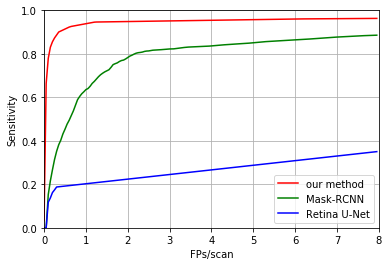

In [64]:
colors = ['r', 'g', 'b', 'y']
plt.figure()
for i, key in enumerate(detection_map):
    fpr, tpr, _ = froc(detection_map[key], method='iobb', mesh=np.arange(0, 1, 0.01), iou_threshold=0.3 if 'our' in key else 0.1, nms=False)
    sen = get_sen(fpr, tpr)
    print(key)
    plt.plot(np.arange(0, 8, 0.05), sen, colors[i])
plt.legend(["our method", "Mask-RCNN", "Retina U-Net"])
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0, 1.0)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig("results/sen_compare.png")

In [61]:
'our' in 'our method'

True

In [40]:
fpr, tpr, _ = froc(detection_mrcnn, method='iobb', mesh=np.arange(0, 1, 0.01), iou_threshold=0.3, nms=False)


100%|██████████| 1136/1136 [00:01<00:00, 962.19it/s]


In [52]:
a = get_sen(fpr, tpr)

In [53]:
len(a)

160

In [9]:
fpr_results = get_FPR_Result(detection_results, cls_results)

In [5]:
with open("results2/fpr_cls_se_format.json", 'r') as f:
    
    fpr_results = json.load(f)

In [33]:
def draw_pred(im, bbox_pred, bbox_gt,score, num_bbox=None, num_bboxgt=None, dir_='./results/img/'):
    '''
    :param im: numpy array (w, h, d)
    :param bbox_pred: numpy array (n, 6)  已归一化
    :param bbox_gt:  numpy array (n, 6)  已归一化
    :param num_bbox:  max num of bboxes to draw
    :return:
    '''
    if bbox_gt.ndim == 1:
        bbox_gt = np.expand_dims(bbox_gt, 0)
    if bbox_pred.ndim == 1:
        bbox_pred = np.expand_dims(bbox_pred, 0)

#     keep = nms_3d(bbox_pred, score)
#     bbox_pred = bbox_pred[keep]
#     score = score[keep]
    n = bbox_pred.shape[0]
    if num_bbox is None:
        num_bbox = n
    if num_bboxgt is None:
        num_bboxgt = bbox_gt.shape[0]
    w, h, t = im.shape
    bbox_pred = (bbox_pred * np.array([w, h, t, w, h, t]))
    bbox_gt = (bbox_gt * np.array([w, h, t, w, h, t]))
    dirs = []
#     if n > 1:
#         print("more than 1: ", dir_)
    for j in range(w):
        vis_im = np.zeros((h, t, 3))
        # print(vis_im.shape)
        vis_im[..., 0] = im[j, :, :]
        vis_im[..., 1] = im[j, :, :]
        vis_im[..., 2] = im[j, :, :]
        flag = False
        for i in range(min(num_bboxgt, bbox_gt.shape[0])):
            a, b = int(bbox_gt[i, 1] - bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] - bbox_gt[i, 5] / 2)
            c, d = int(bbox_gt[i, 1] + bbox_gt[i, 4] / 2), int(bbox_gt[i, 2] + bbox_gt[i, 5] / 2)
            if bbox_gt[i, 0] - bbox_gt[i, 3] / 2 <= j <= bbox_gt[i, 0] + bbox_gt[i, 3] / 2:
                cv2.rectangle(vis_im, (b, a), (d, c), (0, 255, 0), 2)
                flag = True
        for i in range(min(n, num_bbox)):
            a, b = int(bbox_pred[i, 1] - bbox_pred[i, 4] / 2), int(bbox_pred[i, 2] - bbox_pred[i, 5] / 2)
            c, d = int(bbox_pred[i, 1] + bbox_pred[i, 4] / 2), int(bbox_pred[i, 2] + bbox_pred[i, 5] / 2)
            if bbox_pred[i, 0] - bbox_pred[i, 3] / 2 <= j <= bbox_pred[i, 0] + bbox_pred[i, 3] / 2:
                cv2.rectangle(vis_im, (b, a), (d, c), (255, 0, 0), 2)
                sc = np.random.rand() / 50 + 0.98
                if score[i] < sc:
                    sc = score[i]
#                     if dir_ not in dirs:
#                         dirs.append(dir_)
#                         print("less than 0.98", dir_)
                cv2.putText(vis_im, '%.3f' % sc, (b, a-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
                flag = True
        if flag:
            imageio.imsave(os.path.join(dir_, '{}.png'.format(j)), np.uint8(vis_im))

In [115]:
np.random.rand(1)

array([0.31601136])

In [34]:
def draw_res(name, cls_results, path):
# for name in tqdm(cls_results.keys()):
    if not os.path.exists(path):
        os.mkdir(path)
    if os.path.exists(os.path.join(cfg.DATA_ROOT, name, name+'.nii')):
        data, _ = load_raw_data(cfg.DATA_ROOT, name, True)
        data = resize(data, (150, 300, 300))
        data = hu2gray(data, WL=400, WW=500)
        pred = np.array(cls_results[name]['bbox_pred'])
        gt = np.array(cls_results[name]["bbox_gt"])
        score = np.array(cls_results[name]['score2'])[:, 1]
        draw_pred(data, pred, gt,score, 0, path)

In [35]:
def draw_cls(name, cls_results, path):
# for name in tqdm(cls_results.keys()):
    if not os.path.exists(path):
        os.mkdir(path)
    if os.path.exists(os.path.join(cfg.DATA_ROOT, name, name+'.nii')):
        data, _ = load_raw_data(cfg.DATA_ROOT, name, True)
        data = resize(data, (150, 300, 300))
        data = hu2gray(data, WL=40, WW=500)
        pred = np.array(cls_results[name]['bbox_pred'])
        gt = np.array(cls_results[name]["bbox_gt"])
        score = np.array(cls_results[name]['cls_pred'])[:, 1]
        draw_pred(data, pred, gt,score, 2, None, path)

In [36]:
for name in tqdm(fpr_results.keys()):
    draw_cls(name, fpr_results, './results/img/' + name)




  0%|          | 0/1136 [00:00<?, ?it/s]


  0%|          | 1/1136 [00:05<1:36:08,  5.08s/it]


  0%|          | 2/1136 [00:10<1:39:21,  5.26s/it]


  0%|          | 3/1136 [00:16<1:43:31,  5.48s/it]


  0%|          | 4/1136 [00:23<1:52:46,  5.98s/it]


  0%|          | 5/1136 [00:29<1:52:03,  5.94s/it]


  1%|          | 6/1136 [00:36<1:58:48,  6.31s/it]


  1%|          | 7/1136 [00:44<2:06:41,  6.73s/it]


  1%|          | 8/1136 [00:50<2:01:40,  6.47s/it]


  1%|          | 9/1136 [00:57<2:01:47,  6.48s/it]


  1%|          | 10/1136 [01:03<2:02:48,  6.54s/it]


  1%|          | 11/1136 [01:08<1:54:53,  6.13s/it]


  1%|          | 12/1136 [01:15<2:00:00,  6.41s/it]


  1%|          | 13/1136 [01:22<1:59:52,  6.40s/it]


  1%|          | 14/1136 [01:28<1:59:03,  6.37s/it]


  1%|▏         | 15/1136 [01:33<1:53:22,  6.07s/it]


  1%|▏         | 16/1136 [01:38<1:42:44,  5.50s/it]


  1%|▏         | 17/1136 [01:43<1:43:08,  5.53s/it]


  2%|▏         | 18/1136 [01:50<1:48:30,  5.8

 23%|██▎       | 257/1136 [25:13<1:24:59,  5.80s/it]


 23%|██▎       | 258/1136 [25:18<1:21:41,  5.58s/it]


 23%|██▎       | 259/1136 [25:25<1:28:08,  6.03s/it]


 23%|██▎       | 260/1136 [25:31<1:29:01,  6.10s/it]


 23%|██▎       | 261/1136 [25:37<1:29:09,  6.11s/it]


 23%|██▎       | 262/1136 [25:43<1:28:51,  6.10s/it]


 23%|██▎       | 263/1136 [25:49<1:26:47,  5.97s/it]


 23%|██▎       | 264/1136 [25:58<1:37:46,  6.73s/it]


 23%|██▎       | 265/1136 [26:05<1:41:09,  6.97s/it]


 23%|██▎       | 266/1136 [26:20<2:15:13,  9.33s/it]


 24%|██▎       | 267/1136 [26:25<1:57:11,  8.09s/it]


 24%|██▎       | 268/1136 [26:32<1:52:24,  7.77s/it]


 24%|██▎       | 269/1136 [26:38<1:43:50,  7.19s/it]


 24%|██▍       | 270/1136 [26:44<1:36:59,  6.72s/it]


 24%|██▍       | 271/1136 [26:51<1:41:27,  7.04s/it]


 24%|██▍       | 272/1136 [26:58<1:41:13,  7.03s/it]


 24%|██▍       | 273/1136 [27:04<1:35:51,  6.66s/it]


 24%|██▍       | 274/1136 [27:09<1:29:24,  6.22s/it]


 24%|██▍  

 45%|████▌     | 513/1136 [50:04<57:18,  5.52s/it]


 45%|████▌     | 514/1136 [50:10<57:54,  5.59s/it]


 45%|████▌     | 515/1136 [50:15<55:46,  5.39s/it]


 45%|████▌     | 516/1136 [50:21<57:53,  5.60s/it]


 46%|████▌     | 517/1136 [50:28<1:04:16,  6.23s/it]


 46%|████▌     | 518/1136 [50:35<1:04:03,  6.22s/it]


 46%|████▌     | 519/1136 [50:39<58:56,  5.73s/it]  


 46%|████▌     | 520/1136 [50:44<54:29,  5.31s/it]


 46%|████▌     | 521/1136 [50:49<55:46,  5.44s/it]


 46%|████▌     | 522/1136 [50:54<53:16,  5.21s/it]


 46%|████▌     | 523/1136 [51:00<55:58,  5.48s/it]


 46%|████▌     | 524/1136 [51:07<1:00:55,  5.97s/it]


 46%|████▌     | 525/1136 [51:14<1:01:58,  6.09s/it]


 46%|████▋     | 526/1136 [51:18<57:59,  5.70s/it]  


 46%|████▋     | 527/1136 [51:23<54:44,  5.39s/it]


 46%|████▋     | 528/1136 [51:29<57:08,  5.64s/it]


 47%|████▋     | 529/1136 [51:34<53:57,  5.33s/it]


 47%|████▋     | 530/1136 [51:39<54:02,  5.35s/it]


 47%|████▋     | 531/1136 [51:43<4

 68%|██████▊   | 771/1136 [1:14:40<35:45,  5.88s/it]


 68%|██████▊   | 772/1136 [1:14:46<35:24,  5.84s/it]


 68%|██████▊   | 773/1136 [1:14:51<33:33,  5.55s/it]


 68%|██████▊   | 774/1136 [1:14:55<31:35,  5.24s/it]


 68%|██████▊   | 775/1136 [1:15:01<31:27,  5.23s/it]


 68%|██████▊   | 776/1136 [1:15:06<32:33,  5.43s/it]


 68%|██████▊   | 777/1136 [1:15:13<34:32,  5.77s/it]


 68%|██████▊   | 778/1136 [1:15:20<37:06,  6.22s/it]


 69%|██████▊   | 779/1136 [1:15:26<36:25,  6.12s/it]


 69%|██████▊   | 780/1136 [1:15:32<35:58,  6.06s/it]


 69%|██████▉   | 781/1136 [1:15:38<35:45,  6.04s/it]


 69%|██████▉   | 782/1136 [1:15:44<34:55,  5.92s/it]


 69%|██████▉   | 783/1136 [1:15:48<32:39,  5.55s/it]


 69%|██████▉   | 784/1136 [1:15:53<31:19,  5.34s/it]


 69%|██████▉   | 785/1136 [1:15:59<32:16,  5.52s/it]


 69%|██████▉   | 786/1136 [1:16:03<29:46,  5.10s/it]


 69%|██████▉   | 787/1136 [1:16:08<29:04,  5.00s/it]


 69%|██████▉   | 788/1136 [1:16:13<28:44,  4.95s/it]


 69%|█████

 90%|█████████ | 1026/1136 [1:38:08<09:15,  5.05s/it]


 90%|█████████ | 1027/1136 [1:38:14<09:32,  5.26s/it]


 90%|█████████ | 1028/1136 [1:38:20<10:08,  5.63s/it]


 91%|█████████ | 1029/1136 [1:38:28<11:03,  6.20s/it]


 91%|█████████ | 1030/1136 [1:38:33<10:41,  6.05s/it]


 91%|█████████ | 1031/1136 [1:38:40<10:42,  6.12s/it]


 91%|█████████ | 1032/1136 [1:38:43<09:17,  5.36s/it]


 91%|█████████ | 1033/1136 [1:38:46<08:08,  4.75s/it]


 91%|█████████ | 1034/1136 [1:38:51<07:48,  4.60s/it]


 91%|█████████ | 1035/1136 [1:38:56<08:02,  4.78s/it]


 91%|█████████ | 1036/1136 [1:39:01<08:11,  4.91s/it]


 91%|█████████▏| 1037/1136 [1:39:08<09:06,  5.52s/it]


 91%|█████████▏| 1038/1136 [1:39:13<08:43,  5.34s/it]


 91%|█████████▏| 1039/1136 [1:39:19<08:47,  5.43s/it]


 92%|█████████▏| 1040/1136 [1:39:24<08:51,  5.54s/it]


 92%|█████████▏| 1041/1136 [1:39:32<09:31,  6.02s/it]


 92%|█████████▏| 1042/1136 [1:39:37<09:10,  5.86s/it]


 92%|█████████▏| 1043/1136 [1:39:42<08:46,  5.66

In [29]:
cnt = 0
cnt = [0, 0, 0, 0, 0]
path = './results/img3/'
for name in tqdm(fpr_results.keys()):
    s = np.mean(lesion[name])
    idx = -1
    if s < 30:
        idx = 0
    elif 30 <= s < 50:
        idx = 1
    elif 50 <= s < 70:
        idx = 2
    elif 70 <= s < 100:
        idx = 3
    else:
        idx = 4
    cnt[idx] += 1
#     if cnt[idx] < 10:
    p = os.path.join(path, str(idx))
    if not os.path.exists(p):
        os.mkdir(p)
    p = os.path.join(p, name)
    draw_res(name, fpr_results, p)





  0%|          | 0/936 [00:00<?, ?it/s]

less than 0.98 ./results/img3/0/0723089






  0%|          | 1/936 [00:02<44:56,  2.88s/it]

more than 1:  ./results/img3/1/0314838
less than 0.98 ./results/img3/1/0314838






  0%|          | 2/936 [00:07<50:39,  3.25s/it]



  0%|          | 3/936 [00:10<52:41,  3.39s/it]



  0%|          | 4/936 [00:14<52:55,  3.41s/it]



  1%|          | 5/936 [00:18<55:12,  3.56s/it]



  1%|          | 6/936 [00:22<57:43,  3.72s/it]



  1%|          | 7/936 [00:25<54:54,  3.55s/it]



  1%|          | 8/936 [00:29<56:20,  3.64s/it]



  1%|          | 9/936 [00:32<56:05,  3.63s/it]



  1%|          | 10/936 [00:36<55:25,  3.59s/it]

less than 0.98 ./results/img3/3/0329727






  1%|          | 11/936 [00:40<58:58,  3.83s/it]



  1%|▏         | 12/936 [00:46<1:08:16,  4.43s/it]

less than 0.98 ./results/img3/1/0628962






  1%|▏         | 13/936 [00:54<1:23:34,  5.43s/it]

less than 0.98 ./results/img3/3/0529390






  1%|▏         | 14/936 [01:00<1:25:28,  5.56s/it]

less than 0.98 ./results/img3/1/1047648






  2%|▏         | 15/936 [01:05<1:26:02,  5.61s/it]

less than 0.98 ./results/img3/2/0521447






  2%|▏         | 16/936 [01:10<1:20:58,  5.28s/it]

less than 0.98 ./results/img3/4/1005868






  2%|▏         | 17/936 [01:17<1:31:07,  5.95s/it]

less than 0.98 ./results/img3/0/0584472






  2%|▏         | 18/936 [01:22<1:26:02,  5.62s/it]



  2%|▏         | 19/936 [01:27<1:20:16,  5.25s/it]



  2%|▏         | 20/936 [01:33<1:24:17,  5.52s/it]

less than 0.98 ./results/img3/0/0565799






  2%|▏         | 21/936 [01:38<1:23:49,  5.50s/it]

less than 0.98 ./results/img3/2/0397965






  2%|▏         | 22/936 [01:45<1:29:00,  5.84s/it]



  2%|▏         | 23/936 [01:49<1:23:14,  5.47s/it]

more than 1:  ./results/img3/1/0466374
less than 0.98 ./results/img3/1/0466374






  3%|▎         | 24/936 [01:57<1:30:47,  5.97s/it]



  3%|▎         | 25/936 [02:01<1:22:40,  5.45s/it]



  3%|▎         | 26/936 [02:07<1:25:14,  5.62s/it]



  3%|▎         | 27/936 [02:11<1:18:21,  5.17s/it]

less than 0.98 ./results/img3/2/0602737






  3%|▎         | 28/936 [02:17<1:21:12,  5.37s/it]

less than 0.98 ./results/img3/0/0996588






  3%|▎         | 29/936 [02:22<1:20:26,  5.32s/it]

less than 0.98 ./results/img3/0/0555130






  3%|▎         | 30/936 [02:27<1:18:08,  5.17s/it]

more than 1:  ./results/img3/1/1012352
less than 0.98 ./results/img3/1/1012352






  3%|▎         | 31/936 [02:34<1:25:33,  5.67s/it]



  3%|▎         | 32/936 [02:39<1:25:44,  5.69s/it]



  4%|▎         | 33/936 [02:45<1:26:51,  5.77s/it]

less than 0.98 ./results/img3/1/0561675






  4%|▎         | 34/936 [02:51<1:24:58,  5.65s/it]



  4%|▎         | 35/936 [02:58<1:30:36,  6.03s/it]

less than 0.98 ./results/img3/0/0753072






  4%|▍         | 36/936 [03:05<1:37:45,  6.52s/it]

less than 0.98 ./results/img3/1/0270655






  4%|▍         | 37/936 [03:09<1:26:42,  5.79s/it]



  4%|▍         | 38/936 [03:17<1:36:05,  6.42s/it]

less than 0.98 ./results/img3/1/0362439






  4%|▍         | 39/936 [03:25<1:40:35,  6.73s/it]



  4%|▍         | 40/936 [03:34<1:50:23,  7.39s/it]



  4%|▍         | 41/936 [03:41<1:49:05,  7.31s/it]



  4%|▍         | 42/936 [03:47<1:42:53,  6.91s/it]



  5%|▍         | 43/936 [03:52<1:33:56,  6.31s/it]

less than 0.98 ./results/img3/0/0906707






  5%|▍         | 44/936 [03:59<1:39:01,  6.66s/it]



  5%|▍         | 45/936 [04:04<1:31:10,  6.14s/it]



  5%|▍         | 46/936 [04:11<1:33:56,  6.33s/it]

less than 0.98 ./results/img3/2/0560176






  5%|▌         | 47/936 [04:17<1:32:10,  6.22s/it]

less than 0.98 ./results/img3/0/0911131






  5%|▌         | 48/936 [04:23<1:31:59,  6.22s/it]



  5%|▌         | 49/936 [04:29<1:32:56,  6.29s/it]



  5%|▌         | 50/936 [04:35<1:31:21,  6.19s/it]



  5%|▌         | 51/936 [04:41<1:28:12,  5.98s/it]

less than 0.98 ./results/img3/0/0359224






  6%|▌         | 52/936 [04:45<1:20:17,  5.45s/it]

less than 0.98 ./results/img3/1/0646601






  6%|▌         | 53/936 [04:50<1:19:05,  5.37s/it]



  6%|▌         | 54/936 [04:54<1:13:15,  4.98s/it]



  6%|▌         | 55/936 [05:03<1:28:08,  6.00s/it]

less than 0.98 ./results/img3/0/0255426






  6%|▌         | 56/936 [05:06<1:15:17,  5.13s/it]

more than 1:  ./results/img3/1/0425769
less than 0.98 ./results/img3/1/0425769






  6%|▌         | 57/936 [05:12<1:17:58,  5.32s/it]



  6%|▌         | 58/936 [05:16<1:13:38,  5.03s/it]

less than 0.98 ./results/img3/0/0501259






  6%|▋         | 59/936 [05:22<1:17:45,  5.32s/it]

less than 0.98 ./results/img3/1/0483228






  6%|▋         | 60/936 [05:27<1:17:33,  5.31s/it]



  7%|▋         | 61/936 [05:33<1:18:57,  5.41s/it]



  7%|▋         | 62/936 [05:38<1:15:25,  5.18s/it]

less than 0.98 ./results/img3/0/0692029






  7%|▋         | 63/936 [05:43<1:15:21,  5.18s/it]

less than 0.98 ./results/img3/1/0775636






  7%|▋         | 64/936 [05:49<1:20:56,  5.57s/it]



  7%|▋         | 65/936 [05:56<1:26:34,  5.96s/it]



  7%|▋         | 66/936 [06:02<1:26:00,  5.93s/it]



  7%|▋         | 67/936 [06:07<1:21:23,  5.62s/it]

less than 0.98 ./results/img3/0/1001955
less than 0.98 ./results/img3/0/0835187






  7%|▋         | 68/936 [06:13<1:21:49,  5.66s/it]



  7%|▋         | 69/936 [06:22<1:37:30,  6.75s/it]

less than 0.98 ./results/img3/0/0651037






  7%|▋         | 70/936 [06:25<1:23:31,  5.79s/it]



  8%|▊         | 71/936 [06:30<1:16:29,  5.31s/it]



  8%|▊         | 72/936 [06:35<1:18:01,  5.42s/it]

more than 1:  ./results/img3/1/0463298
less than 0.98 ./results/img3/1/0463298






  8%|▊         | 73/936 [06:42<1:24:20,  5.86s/it]

less than 0.98 ./results/img3/0/0685289






  8%|▊         | 74/936 [06:48<1:21:39,  5.68s/it]

more than 1:  ./results/img3/0/0602198
less than 0.98 ./results/img3/0/0602198






  8%|▊         | 75/936 [06:52<1:17:47,  5.42s/it]



  8%|▊         | 76/936 [06:59<1:24:01,  5.86s/it]



  8%|▊         | 77/936 [07:04<1:19:47,  5.57s/it]



  8%|▊         | 78/936 [07:09<1:15:17,  5.27s/it]



  8%|▊         | 79/936 [07:13<1:09:10,  4.84s/it]



  9%|▊         | 80/936 [07:18<1:11:54,  5.04s/it]



  9%|▊         | 81/936 [07:23<1:11:49,  5.04s/it]



  9%|▉         | 82/936 [07:28<1:11:57,  5.06s/it]

less than 0.98 ./results/img3/2/0581949






  9%|▉         | 83/936 [07:34<1:15:25,  5.31s/it]



  9%|▉         | 84/936 [07:40<1:16:25,  5.38s/it]



  9%|▉         | 85/936 [07:45<1:18:21,  5.52s/it]



  9%|▉         | 86/936 [07:49<1:10:30,  4.98s/it]

less than 0.98 ./results/img3/0/0957174






  9%|▉         | 87/936 [07:54<1:11:12,  5.03s/it]

less than 0.98 ./results/img3/2/0405449






  9%|▉         | 88/936 [07:59<1:10:52,  5.02s/it]

more than 1:  ./results/img3/1/0467087
less than 0.98 ./results/img3/1/0467087






 10%|▉         | 89/936 [08:06<1:18:13,  5.54s/it]



 10%|▉         | 90/936 [08:19<1:51:20,  7.90s/it]



 10%|▉         | 91/936 [08:24<1:35:41,  6.79s/it]

less than 0.98 ./results/img3/1/0534806






 10%|▉         | 92/936 [08:28<1:25:58,  6.11s/it]

less than 0.98 ./results/img3/1/0442015






 10%|▉         | 93/936 [08:34<1:23:22,  5.93s/it]



 10%|█         | 94/936 [08:39<1:21:18,  5.79s/it]

less than 0.98 ./results/img3/0/0639653






 10%|█         | 95/936 [08:45<1:22:37,  5.89s/it]

less than 0.98 ./results/img3/3/0443198






 10%|█         | 96/936 [08:51<1:22:59,  5.93s/it]



 10%|█         | 97/936 [08:56<1:16:46,  5.49s/it]

less than 0.98 ./results/img3/2/0447990






 10%|█         | 98/936 [09:01<1:15:10,  5.38s/it]



 11%|█         | 99/936 [09:06<1:15:10,  5.39s/it]



 11%|█         | 100/936 [09:12<1:15:07,  5.39s/it]

less than 0.98 ./results/img3/0/0804183






 11%|█         | 101/936 [09:16<1:12:23,  5.20s/it]



 11%|█         | 102/936 [09:22<1:13:28,  5.29s/it]

less than 0.98 ./results/img3/2/0844597






 11%|█         | 103/936 [09:28<1:16:17,  5.49s/it]



 11%|█         | 104/936 [09:33<1:16:19,  5.50s/it]



 11%|█         | 105/936 [09:40<1:20:49,  5.84s/it]



 11%|█▏        | 106/936 [09:45<1:16:32,  5.53s/it]

less than 0.98 ./results/img3/1/0769488






 11%|█▏        | 107/936 [09:50<1:14:54,  5.42s/it]



 12%|█▏        | 108/936 [09:57<1:19:08,  5.73s/it]



 12%|█▏        | 109/936 [10:03<1:20:19,  5.83s/it]



 12%|█▏        | 110/936 [10:07<1:15:19,  5.47s/it]

less than 0.98 ./results/img3/1/0563023






 12%|█▏        | 111/936 [10:18<1:38:19,  7.15s/it]



 12%|█▏        | 112/936 [10:23<1:27:35,  6.38s/it]

more than 1:  ./results/img3/0/0960167
less than 0.98 ./results/img3/0/0960167






 12%|█▏        | 113/936 [10:28<1:21:20,  5.93s/it]



 12%|█▏        | 114/936 [10:32<1:16:00,  5.55s/it]



 12%|█▏        | 115/936 [10:37<1:12:12,  5.28s/it]

more than 1:  ./results/img3/1/0577431
less than 0.98 ./results/img3/1/0577431






 12%|█▏        | 116/936 [10:43<1:15:03,  5.49s/it]



 12%|█▎        | 117/936 [10:48<1:11:45,  5.26s/it]

less than 0.98 ./results/img3/0/0586314






 13%|█▎        | 118/936 [10:52<1:08:49,  5.05s/it]



 13%|█▎        | 119/936 [10:58<1:09:54,  5.13s/it]

less than 0.98 ./results/img3/2/0497000






 13%|█▎        | 120/936 [11:03<1:10:09,  5.16s/it]

less than 0.98 ./results/img3/1/0784582






 13%|█▎        | 121/936 [11:09<1:12:43,  5.35s/it]

less than 0.98 ./results/img3/1/0425088






 13%|█▎        | 122/936 [11:15<1:15:53,  5.59s/it]



 13%|█▎        | 123/936 [11:18<1:06:03,  4.88s/it]

less than 0.98 ./results/img3/0/0782453






 13%|█▎        | 124/936 [11:22<1:04:11,  4.74s/it]

more than 1:  ./results/img3/0/0687467
less than 0.98 ./results/img3/0/0687467






 13%|█▎        | 125/936 [11:27<1:04:00,  4.74s/it]

less than 0.98 ./results/img3/0/1054604






 13%|█▎        | 126/936 [11:31<1:01:57,  4.59s/it]



 14%|█▎        | 127/936 [11:37<1:04:37,  4.79s/it]

less than 0.98 ./results/img3/1/0664124






 14%|█▎        | 128/936 [11:43<1:09:59,  5.20s/it]



 14%|█▍        | 129/936 [11:49<1:15:02,  5.58s/it]



 14%|█▍        | 130/936 [11:54<1:12:00,  5.36s/it]



 14%|█▍        | 131/936 [12:00<1:14:30,  5.55s/it]

less than 0.98 ./results/img3/0/0706163






 14%|█▍        | 132/936 [12:05<1:13:18,  5.47s/it]

less than 0.98 ./results/img3/3/0456348






 14%|█▍        | 133/936 [12:11<1:11:50,  5.37s/it]

less than 0.98 ./results/img3/1/0756408






 14%|█▍        | 134/936 [12:16<1:11:24,  5.34s/it]



 14%|█▍        | 135/936 [12:26<1:29:52,  6.73s/it]

more than 1:  ./results/img3/3/0904146
less than 0.98 ./results/img3/3/0904146






 15%|█▍        | 136/936 [12:32<1:28:49,  6.66s/it]



 15%|█▍        | 137/936 [12:37<1:22:10,  6.17s/it]



 15%|█▍        | 138/936 [12:42<1:15:55,  5.71s/it]

less than 0.98 ./results/img3/1/0720870






 15%|█▍        | 139/936 [12:46<1:10:39,  5.32s/it]



 15%|█▍        | 140/936 [12:52<1:12:52,  5.49s/it]



 15%|█▌        | 141/936 [12:57<1:11:35,  5.40s/it]

less than 0.98 ./results/img3/4/0396642






 15%|█▌        | 142/936 [13:05<1:19:47,  6.03s/it]

less than 0.98 ./results/img3/1/0683025






 15%|█▌        | 143/936 [13:10<1:17:35,  5.87s/it]



 15%|█▌        | 144/936 [13:16<1:14:42,  5.66s/it]

less than 0.98 ./results/img3/0/0483166
less than 0.98 ./results/img3/1/0912498






 15%|█▌        | 145/936 [13:20<1:10:49,  5.37s/it]



 16%|█▌        | 146/936 [13:25<1:09:39,  5.29s/it]

less than 0.98 ./results/img3/0/1052567






 16%|█▌        | 147/936 [13:30<1:06:27,  5.05s/it]

less than 0.98 ./results/img3/1/0791536






 16%|█▌        | 148/936 [13:36<1:09:32,  5.30s/it]

less than 0.98 ./results/img3/0/0548720






 16%|█▌        | 149/936 [13:42<1:12:11,  5.50s/it]

less than 0.98 ./results/img3/1/0550035






 16%|█▌        | 150/936 [13:47<1:09:18,  5.29s/it]



 16%|█▌        | 151/936 [13:52<1:08:11,  5.21s/it]



 16%|█▌        | 152/936 [13:58<1:11:01,  5.44s/it]

less than 0.98 ./results/img3/1/0259933






 16%|█▋        | 153/936 [14:02<1:07:29,  5.17s/it]

less than 0.98 ./results/img3/3/0758211






 16%|█▋        | 154/936 [14:09<1:12:50,  5.59s/it]



 17%|█▋        | 155/936 [14:15<1:16:16,  5.86s/it]



 17%|█▋        | 156/936 [14:20<1:11:55,  5.53s/it]

more than 1:  ./results/img3/0/0538389
less than 0.98 ./results/img3/0/0538389






 17%|█▋        | 157/936 [14:25<1:10:14,  5.41s/it]



 17%|█▋        | 158/936 [14:32<1:15:58,  5.86s/it]

less than 0.98 ./results/img3/2/0786137






 17%|█▋        | 159/936 [14:38<1:16:15,  5.89s/it]



 17%|█▋        | 160/936 [14:44<1:16:38,  5.93s/it]

less than 0.98 ./results/img3/2/0992301






 17%|█▋        | 161/936 [14:52<1:25:18,  6.60s/it]

more than 1:  ./results/img3/2/0505011
less than 0.98 ./results/img3/2/0505011






 17%|█▋        | 162/936 [14:58<1:22:05,  6.36s/it]



 17%|█▋        | 163/936 [15:04<1:20:25,  6.24s/it]



 18%|█▊        | 164/936 [15:07<1:08:27,  5.32s/it]



 18%|█▊        | 165/936 [15:12<1:07:16,  5.24s/it]

less than 0.98 ./results/img3/1/1053839






 18%|█▊        | 166/936 [15:18<1:10:10,  5.47s/it]



 18%|█▊        | 167/936 [15:24<1:12:46,  5.68s/it]



 18%|█▊        | 168/936 [15:30<1:13:54,  5.77s/it]

less than 0.98 ./results/img3/1/0895924






 18%|█▊        | 169/936 [15:35<1:10:17,  5.50s/it]

less than 0.98 ./results/img3/0/1022016






 18%|█▊        | 170/936 [15:44<1:22:25,  6.46s/it]



 18%|█▊        | 171/936 [15:51<1:23:31,  6.55s/it]



 18%|█▊        | 172/936 [15:56<1:20:34,  6.33s/it]

less than 0.98 ./results/img3/3/0796015






 18%|█▊        | 173/936 [16:02<1:16:49,  6.04s/it]

less than 0.98 ./results/img3/1/1048847






 19%|█▊        | 174/936 [16:07<1:13:35,  5.79s/it]

less than 0.98 ./results/img3/4/0569546






 19%|█▊        | 175/936 [16:13<1:13:57,  5.83s/it]



 19%|█▉        | 176/936 [16:17<1:07:28,  5.33s/it]

less than 0.98 ./results/img3/0/0691982






 19%|█▉        | 177/936 [16:22<1:04:39,  5.11s/it]



 19%|█▉        | 178/936 [16:27<1:04:15,  5.09s/it]

less than 0.98 ./results/img3/0/1005725






 19%|█▉        | 179/936 [16:33<1:08:37,  5.44s/it]

less than 0.98 ./results/img3/0/0834232






 19%|█▉        | 180/936 [16:38<1:08:22,  5.43s/it]



 19%|█▉        | 181/936 [16:43<1:05:35,  5.21s/it]

more than 1:  ./results/img3/1/0534337
less than 0.98 ./results/img3/1/0534337






 19%|█▉        | 182/936 [16:48<1:02:37,  4.98s/it]

less than 0.98 ./results/img3/2/0601298






 20%|█▉        | 183/936 [16:53<1:05:01,  5.18s/it]



 20%|█▉        | 184/936 [16:59<1:05:58,  5.26s/it]



 20%|█▉        | 185/936 [17:03<1:02:55,  5.03s/it]

less than 0.98 ./results/img3/0/1001655






 20%|█▉        | 186/936 [17:09<1:07:14,  5.38s/it]



 20%|█▉        | 187/936 [17:15<1:07:47,  5.43s/it]



 20%|██        | 188/936 [17:21<1:09:29,  5.57s/it]



 20%|██        | 189/936 [17:26<1:09:14,  5.56s/it]



 20%|██        | 190/936 [17:32<1:10:13,  5.65s/it]



 20%|██        | 191/936 [17:37<1:07:09,  5.41s/it]



 21%|██        | 192/936 [17:43<1:10:52,  5.72s/it]



 21%|██        | 193/936 [17:50<1:13:00,  5.90s/it]



 21%|██        | 194/936 [17:58<1:22:07,  6.64s/it]



 21%|██        | 195/936 [18:03<1:15:01,  6.08s/it]

more than 1:  ./results/img3/1/0316174
less than 0.98 ./results/img3/1/0316174






 21%|██        | 196/936 [18:09<1:13:55,  5.99s/it]

less than 0.98 ./results/img3/0/0564510






 21%|██        | 197/936 [18:13<1:09:20,  5.63s/it]



 21%|██        | 198/936 [18:18<1:03:39,  5.18s/it]

less than 0.98 ./results/img3/1/0548499






 21%|██▏       | 199/936 [18:23<1:05:45,  5.35s/it]

less than 0.98 ./results/img3/1/0450070






 21%|██▏       | 200/936 [18:29<1:05:50,  5.37s/it]



 21%|██▏       | 201/936 [18:34<1:05:34,  5.35s/it]



 22%|██▏       | 202/936 [18:40<1:09:04,  5.65s/it]

more than 1:  ./results/img3/0/0563548
less than 0.98 ./results/img3/0/0563548






 22%|██▏       | 203/936 [18:47<1:13:07,  5.99s/it]



 22%|██▏       | 204/936 [18:52<1:08:34,  5.62s/it]

more than 1:  ./results/img3/1/0586570
less than 0.98 ./results/img3/1/0586570






 22%|██▏       | 205/936 [18:58<1:11:14,  5.85s/it]



 22%|██▏       | 206/936 [19:04<1:11:51,  5.91s/it]

less than 0.98 ./results/img3/1/0458811






 22%|██▏       | 207/936 [19:11<1:14:42,  6.15s/it]

less than 0.98 ./results/img3/0/0658824






 22%|██▏       | 208/936 [19:17<1:15:38,  6.23s/it]

less than 0.98 ./results/img3/2/0884827






 22%|██▏       | 209/936 [19:24<1:15:52,  6.26s/it]

less than 0.98 ./results/img3/1/1087971






 22%|██▏       | 210/936 [19:28<1:08:37,  5.67s/it]

less than 0.98 ./results/img3/0/0591496






 23%|██▎       | 211/936 [19:34<1:10:52,  5.87s/it]

less than 0.98 ./results/img3/0/0691342






 23%|██▎       | 212/936 [19:40<1:09:41,  5.78s/it]



 23%|██▎       | 213/936 [19:51<1:27:29,  7.26s/it]



 23%|██▎       | 214/936 [19:57<1:25:10,  7.08s/it]

less than 0.98 ./results/img3/1/0753188






 23%|██▎       | 215/936 [20:03<1:19:46,  6.64s/it]



 23%|██▎       | 216/936 [20:09<1:17:23,  6.45s/it]

less than 0.98 ./results/img3/1/0619752






 23%|██▎       | 217/936 [20:16<1:19:06,  6.60s/it]



 23%|██▎       | 218/936 [20:21<1:15:12,  6.28s/it]



 23%|██▎       | 219/936 [20:27<1:13:39,  6.16s/it]

less than 0.98 ./results/img3/2/0625283






 24%|██▎       | 220/936 [20:33<1:11:05,  5.96s/it]

less than 0.98 ./results/img3/0/0473614






 24%|██▎       | 221/936 [20:39<1:10:38,  5.93s/it]

less than 0.98 ./results/img3/0/0375780






 24%|██▎       | 222/936 [20:46<1:14:24,  6.25s/it]

more than 1:  ./results/img3/0/0352907






 24%|██▍       | 223/936 [20:51<1:12:21,  6.09s/it]

less than 0.98 ./results/img3/1/0970975






 24%|██▍       | 224/936 [20:58<1:13:34,  6.20s/it]



 24%|██▍       | 225/936 [21:04<1:13:02,  6.16s/it]



 24%|██▍       | 226/936 [21:10<1:12:59,  6.17s/it]



 24%|██▍       | 227/936 [21:15<1:08:31,  5.80s/it]

less than 0.98 ./results/img3/1/0797919






 24%|██▍       | 228/936 [21:21<1:09:57,  5.93s/it]

more than 1:  ./results/img3/3/0463694
less than 0.98 ./results/img3/3/0463694






 24%|██▍       | 229/936 [21:28<1:14:11,  6.30s/it]



 25%|██▍       | 230/936 [21:35<1:15:06,  6.38s/it]



 25%|██▍       | 231/936 [21:41<1:11:52,  6.12s/it]



 25%|██▍       | 232/936 [21:46<1:10:50,  6.04s/it]



 25%|██▍       | 233/936 [21:51<1:06:14,  5.65s/it]

less than 0.98 ./results/img3/0/0876290






 25%|██▌       | 234/936 [21:56<1:04:10,  5.49s/it]

less than 0.98 ./results/img3/2/0715118






 25%|██▌       | 235/936 [22:02<1:03:58,  5.48s/it]



 25%|██▌       | 236/936 [22:07<1:02:40,  5.37s/it]



 25%|██▌       | 237/936 [22:13<1:04:11,  5.51s/it]



 25%|██▌       | 238/936 [22:20<1:10:35,  6.07s/it]

less than 0.98 ./results/img3/0/0294631






 26%|██▌       | 239/936 [22:23<1:00:43,  5.23s/it]

less than 0.98 ./results/img3/1/1031074






 26%|██▌       | 240/936 [22:30<1:04:32,  5.56s/it]

less than 0.98 ./results/img3/1/0424226






 26%|██▌       | 241/936 [22:37<1:09:46,  6.02s/it]



 26%|██▌       | 242/936 [22:42<1:07:23,  5.83s/it]



 26%|██▌       | 243/936 [22:47<1:04:56,  5.62s/it]



 26%|██▌       | 244/936 [22:53<1:04:44,  5.61s/it]



 26%|██▌       | 245/936 [23:01<1:11:56,  6.25s/it]

less than 0.98 ./results/img3/1/0381339






 26%|██▋       | 246/936 [23:07<1:12:13,  6.28s/it]



 26%|██▋       | 247/936 [23:13<1:10:21,  6.13s/it]



 26%|██▋       | 248/936 [23:21<1:17:20,  6.74s/it]



 27%|██▋       | 249/936 [23:26<1:11:56,  6.28s/it]

less than 0.98 ./results/img3/0/0361248






 27%|██▋       | 250/936 [23:29<59:11,  5.18s/it]  



 27%|██▋       | 251/936 [23:34<58:27,  5.12s/it]

less than 0.98 ./results/img3/1/0254546






 27%|██▋       | 252/936 [23:37<50:58,  4.47s/it]



 27%|██▋       | 253/936 [23:43<58:33,  5.14s/it]



 27%|██▋       | 254/936 [23:50<1:02:43,  5.52s/it]

less than 0.98 ./results/img3/1/0447884






 27%|██▋       | 255/936 [23:55<1:03:02,  5.55s/it]

less than 0.98 ./results/img3/3/0774813






 27%|██▋       | 256/936 [24:02<1:06:37,  5.88s/it]



 27%|██▋       | 257/936 [24:10<1:13:40,  6.51s/it]



 28%|██▊       | 258/936 [24:17<1:13:51,  6.54s/it]



 28%|██▊       | 259/936 [24:22<1:09:25,  6.15s/it]

more than 1:  ./results/img3/3/0584688
less than 0.98 ./results/img3/3/0584688






 28%|██▊       | 260/936 [24:28<1:10:45,  6.28s/it]

less than 0.98 ./results/img3/2/0553929






 28%|██▊       | 261/936 [24:34<1:09:42,  6.20s/it]



 28%|██▊       | 262/936 [24:40<1:08:54,  6.13s/it]

more than 1:  ./results/img3/1/0858451
less than 0.98 ./results/img3/1/0858451






 28%|██▊       | 263/936 [24:48<1:15:17,  6.71s/it]



 28%|██▊       | 264/936 [24:54<1:11:25,  6.38s/it]



 28%|██▊       | 265/936 [24:58<1:03:22,  5.67s/it]



 28%|██▊       | 266/936 [25:05<1:08:07,  6.10s/it]

more than 1:  ./results/img3/0/0826654
less than 0.98 ./results/img3/0/0826654






 29%|██▊       | 267/936 [25:13<1:12:05,  6.47s/it]

more than 1:  ./results/img3/0/0493107
less than 0.98 ./results/img3/0/0493107






 29%|██▊       | 268/936 [25:18<1:07:58,  6.11s/it]



 29%|██▊       | 269/936 [25:24<1:08:41,  6.18s/it]

more than 1:  ./results/img3/1/0574862
less than 0.98 ./results/img3/1/0574862






 29%|██▉       | 270/936 [25:30<1:06:33,  6.00s/it]



 29%|██▉       | 271/936 [25:35<1:03:09,  5.70s/it]



 29%|██▉       | 272/936 [25:40<1:01:04,  5.52s/it]



 29%|██▉       | 273/936 [25:46<1:03:14,  5.72s/it]



 29%|██▉       | 274/936 [25:51<59:42,  5.41s/it]  



 29%|██▉       | 275/936 [25:55<57:07,  5.18s/it]



 29%|██▉       | 276/936 [26:00<54:42,  4.97s/it]

less than 0.98 ./results/img3/2/0783819






 30%|██▉       | 277/936 [26:06<58:59,  5.37s/it]



 30%|██▉       | 278/936 [26:12<59:23,  5.42s/it]



 30%|██▉       | 279/936 [26:19<1:04:02,  5.85s/it]

less than 0.98 ./results/img3/1/0463753






 30%|██▉       | 280/936 [26:24<1:02:21,  5.70s/it]



 30%|███       | 281/936 [26:30<1:03:02,  5.77s/it]

less than 0.98 ./results/img3/0/1001736






 30%|███       | 282/936 [26:36<1:04:05,  5.88s/it]



 30%|███       | 283/936 [26:43<1:06:35,  6.12s/it]



 30%|███       | 284/936 [26:48<1:04:00,  5.89s/it]



 30%|███       | 285/936 [26:55<1:08:13,  6.29s/it]



 31%|███       | 286/936 [27:00<1:04:32,  5.96s/it]



 31%|███       | 287/936 [27:06<1:03:52,  5.91s/it]



 31%|███       | 288/936 [27:12<1:03:56,  5.92s/it]



 31%|███       | 289/936 [27:17<1:01:47,  5.73s/it]

less than 0.98 ./results/img3/0/0469067






 31%|███       | 290/936 [27:24<1:03:35,  5.91s/it]



 31%|███       | 291/936 [27:30<1:05:40,  6.11s/it]



 31%|███       | 292/936 [27:35<1:01:11,  5.70s/it]



 31%|███▏      | 293/936 [27:40<58:54,  5.50s/it]  

less than 0.98 ./results/img3/4/0453066






 31%|███▏      | 294/936 [27:47<1:03:59,  5.98s/it]

less than 0.98 ./results/img3/0/0970716






 32%|███▏      | 295/936 [27:52<1:00:15,  5.64s/it]

less than 0.98 ./results/img3/0/0635096






 32%|███▏      | 296/936 [27:56<56:00,  5.25s/it]  



 32%|███▏      | 297/936 [28:02<55:51,  5.24s/it]



 32%|███▏      | 298/936 [28:07<55:47,  5.25s/it]



 32%|███▏      | 299/936 [28:12<56:03,  5.28s/it]

less than 0.98 ./results/img3/0/0517822






 32%|███▏      | 300/936 [28:16<52:41,  4.97s/it]

less than 0.98 ./results/img3/0/0750647






 32%|███▏      | 301/936 [28:22<54:09,  5.12s/it]

more than 1:  ./results/img3/0/1044804
less than 0.98 ./results/img3/0/1044804






 32%|███▏      | 302/936 [28:28<56:12,  5.32s/it]

less than 0.98 ./results/img3/1/1047977






 32%|███▏      | 303/936 [28:33<55:01,  5.22s/it]

less than 0.98 ./results/img3/2/1078068






 32%|███▏      | 304/936 [28:37<53:07,  5.04s/it]



 33%|███▎      | 305/936 [28:42<52:12,  4.96s/it]

more than 1:  ./results/img3/2/0713611
less than 0.98 ./results/img3/2/0713611






 33%|███▎      | 306/936 [28:50<1:01:36,  5.87s/it]

less than 0.98 ./results/img3/1/0660531






 33%|███▎      | 307/936 [28:55<57:31,  5.49s/it]  

less than 0.98 ./results/img3/0/0578506






 33%|███▎      | 308/936 [28:59<54:38,  5.22s/it]



 33%|███▎      | 309/936 [29:04<54:21,  5.20s/it]



 33%|███▎      | 310/936 [29:11<59:43,  5.73s/it]



 33%|███▎      | 311/936 [29:16<54:59,  5.28s/it]



 33%|███▎      | 312/936 [29:21<55:28,  5.33s/it]

more than 1:  ./results/img3/2/0440434
less than 0.98 ./results/img3/2/0440434






 33%|███▎      | 313/936 [29:29<1:04:01,  6.17s/it]



 34%|███▎      | 314/936 [29:34<58:49,  5.67s/it]  



 34%|███▎      | 315/936 [29:38<55:49,  5.39s/it]

less than 0.98 ./results/img3/0/0599469






 34%|███▍      | 316/936 [29:43<53:17,  5.16s/it]



 34%|███▍      | 317/936 [29:48<51:54,  5.03s/it]

less than 0.98 ./results/img3/0/0920574






 34%|███▍      | 318/936 [29:54<55:14,  5.36s/it]

less than 0.98 ./results/img3/1/1036634






 34%|███▍      | 319/936 [29:59<53:51,  5.24s/it]

less than 0.98 ./results/img3/1/0491566






 34%|███▍      | 320/936 [30:04<52:32,  5.12s/it]



 34%|███▍      | 321/936 [30:10<54:41,  5.34s/it]



 34%|███▍      | 322/936 [30:15<54:55,  5.37s/it]

less than 0.98 ./results/img3/3/0255491






 35%|███▍      | 323/936 [30:20<52:26,  5.13s/it]

less than 0.98 ./results/img3/0/0446336






 35%|███▍      | 324/936 [30:26<55:16,  5.42s/it]



 35%|███▍      | 325/936 [30:30<52:55,  5.20s/it]



 35%|███▍      | 326/936 [30:36<53:08,  5.23s/it]



 35%|███▍      | 327/936 [30:40<50:44,  5.00s/it]

less than 0.98 ./results/img3/1/0439240






 35%|███▌      | 328/936 [30:45<51:30,  5.08s/it]



 35%|███▌      | 329/936 [30:50<50:12,  4.96s/it]



 35%|███▌      | 330/936 [30:55<50:28,  5.00s/it]

less than 0.98 ./results/img3/0/1011772






 35%|███▌      | 331/936 [31:00<49:52,  4.95s/it]



 35%|███▌      | 332/936 [31:04<47:03,  4.67s/it]



 36%|███▌      | 333/936 [31:10<49:57,  4.97s/it]



 36%|███▌      | 334/936 [31:16<54:58,  5.48s/it]

less than 0.98 ./results/img3/0/0782070






 36%|███▌      | 335/936 [31:23<57:54,  5.78s/it]



 36%|███▌      | 336/936 [31:29<1:00:08,  6.01s/it]



 36%|███▌      | 337/936 [31:34<56:22,  5.65s/it]  

more than 1:  ./results/img3/3/0409596
less than 0.98 ./results/img3/3/0409596






 36%|███▌      | 338/936 [31:41<59:25,  5.96s/it]

less than 0.98 ./results/img3/0/1057207






 36%|███▌      | 339/936 [31:45<53:45,  5.40s/it]



 36%|███▋      | 340/936 [31:51<54:08,  5.45s/it]

less than 0.98 ./results/img3/1/0471730






 36%|███▋      | 341/936 [31:56<54:05,  5.45s/it]



 37%|███▋      | 342/936 [32:02<54:42,  5.53s/it]

less than 0.98 ./results/img3/1/0413649






 37%|███▋      | 343/936 [32:08<56:56,  5.76s/it]



 37%|███▋      | 344/936 [32:12<50:11,  5.09s/it]

less than 0.98 ./results/img3/1/0504487






 37%|███▋      | 345/936 [32:16<49:11,  4.99s/it]

less than 0.98 ./results/img3/0/0574519






 37%|███▋      | 346/936 [32:21<48:59,  4.98s/it]



 37%|███▋      | 347/936 [32:26<46:57,  4.78s/it]

less than 0.98 ./results/img3/3/0610443






 37%|███▋      | 348/936 [32:31<47:50,  4.88s/it]



 37%|███▋      | 349/936 [32:37<51:41,  5.28s/it]

less than 0.98 ./results/img3/0/0594063






 37%|███▋      | 350/936 [32:42<50:04,  5.13s/it]



 38%|███▊      | 351/936 [32:47<50:59,  5.23s/it]



 38%|███▊      | 352/936 [32:53<53:08,  5.46s/it]

less than 0.98 ./results/img3/3/0427090






 38%|███▊      | 353/936 [33:01<1:00:13,  6.20s/it]

more than 1:  ./results/img3/2/0814746
less than 0.98 ./results/img3/2/0814746






 38%|███▊      | 354/936 [33:09<1:04:07,  6.61s/it]



 38%|███▊      | 355/936 [33:13<57:50,  5.97s/it]  



 38%|███▊      | 356/936 [33:20<59:28,  6.15s/it]

less than 0.98 ./results/img3/0/0770929






 38%|███▊      | 357/936 [33:25<57:25,  5.95s/it]



 38%|███▊      | 358/936 [33:30<54:46,  5.69s/it]

less than 0.98 ./results/img3/1/0433674






 38%|███▊      | 359/936 [33:36<56:18,  5.85s/it]



 38%|███▊      | 360/936 [33:43<59:07,  6.16s/it]



 39%|███▊      | 361/936 [33:48<54:05,  5.64s/it]



 39%|███▊      | 362/936 [33:54<55:07,  5.76s/it]

more than 1:  ./results/img3/1/0637968
less than 0.98 ./results/img3/1/0637968






 39%|███▉      | 363/936 [34:00<55:40,  5.83s/it]

more than 1:  ./results/img3/1/0869131
less than 0.98 ./results/img3/1/0869131






 39%|███▉      | 364/936 [34:07<58:05,  6.09s/it]

less than 0.98 ./results/img3/3/0792267






 39%|███▉      | 365/936 [34:13<1:00:04,  6.31s/it]



 39%|███▉      | 366/936 [34:18<53:57,  5.68s/it]  

more than 1:  ./results/img3/0/0915176
less than 0.98 ./results/img3/0/0915176






 39%|███▉      | 367/936 [34:25<59:12,  6.24s/it]

less than 0.98 ./results/img3/1/0664649






 39%|███▉      | 368/936 [34:32<1:00:49,  6.43s/it]



 39%|███▉      | 369/936 [34:37<55:43,  5.90s/it]  

more than 1:  ./results/img3/3/0640765
less than 0.98 ./results/img3/3/0640765






 40%|███▉      | 370/936 [34:43<57:51,  6.13s/it]



 40%|███▉      | 371/936 [34:48<52:37,  5.59s/it]



 40%|███▉      | 372/936 [34:53<51:13,  5.45s/it]

less than 0.98 ./results/img3/0/0862507






 40%|███▉      | 373/936 [34:58<49:57,  5.32s/it]

less than 0.98 ./results/img3/1/0400045






 40%|███▉      | 374/936 [35:03<50:45,  5.42s/it]



 40%|████      | 375/936 [35:08<48:05,  5.14s/it]

less than 0.98 ./results/img3/1/0862794






 40%|████      | 376/936 [35:13<48:39,  5.21s/it]



 40%|████      | 377/936 [35:19<50:44,  5.45s/it]



 40%|████      | 378/936 [35:25<51:24,  5.53s/it]



 40%|████      | 379/936 [35:32<55:48,  6.01s/it]

less than 0.98 ./results/img3/0/0771461






 41%|████      | 380/936 [35:37<51:16,  5.53s/it]



 41%|████      | 381/936 [35:42<51:25,  5.56s/it]



 41%|████      | 382/936 [35:47<49:54,  5.41s/it]



 41%|████      | 383/936 [35:52<46:45,  5.07s/it]



 41%|████      | 384/936 [35:59<53:39,  5.83s/it]

less than 0.98 ./results/img3/0/1008222






 41%|████      | 385/936 [36:08<1:01:23,  6.69s/it]



 41%|████      | 386/936 [36:12<54:39,  5.96s/it]  



 41%|████▏     | 387/936 [36:18<53:23,  5.84s/it]

less than 0.98 ./results/img3/0/0643099






 41%|████▏     | 388/936 [36:22<49:19,  5.40s/it]



 42%|████▏     | 389/936 [36:27<48:16,  5.29s/it]

less than 0.98 ./results/img3/1/0646319






 42%|████▏     | 390/936 [36:32<46:33,  5.12s/it]

less than 0.98 ./results/img3/0/1001387






 42%|████▏     | 391/936 [36:37<47:36,  5.24s/it]



 42%|████▏     | 392/936 [36:42<44:42,  4.93s/it]

less than 0.98 ./results/img3/0/0975956






 42%|████▏     | 393/936 [36:46<44:06,  4.87s/it]



 42%|████▏     | 394/936 [36:53<49:04,  5.43s/it]



 42%|████▏     | 395/936 [36:58<48:31,  5.38s/it]



 42%|████▏     | 396/936 [37:06<53:49,  5.98s/it]

less than 0.98 ./results/img3/0/0502347






 42%|████▏     | 397/936 [37:11<52:45,  5.87s/it]



 43%|████▎     | 398/936 [37:17<53:28,  5.96s/it]



 43%|████▎     | 399/936 [37:24<55:21,  6.19s/it]

less than 0.98 ./results/img3/1/0741975






 43%|████▎     | 400/936 [37:29<51:27,  5.76s/it]

less than 0.98 ./results/img3/1/0352700






 43%|████▎     | 401/936 [37:34<50:03,  5.61s/it]

less than 0.98 ./results/img3/0/0471867






 43%|████▎     | 402/936 [37:41<52:14,  5.87s/it]



 43%|████▎     | 403/936 [37:47<52:14,  5.88s/it]

less than 0.98 ./results/img3/0/0732255






 43%|████▎     | 404/936 [37:53<54:15,  6.12s/it]



 43%|████▎     | 405/936 [37:58<50:52,  5.75s/it]



 43%|████▎     | 406/936 [38:03<47:30,  5.38s/it]



 43%|████▎     | 407/936 [38:08<48:11,  5.47s/it]



 44%|████▎     | 408/936 [38:13<44:59,  5.11s/it]

less than 0.98 ./results/img3/0/0631199






 44%|████▎     | 409/936 [38:18<44:50,  5.11s/it]

less than 0.98 ./results/img3/0/0594243






 44%|████▍     | 410/936 [38:22<43:46,  4.99s/it]

less than 0.98 ./results/img3/2/0525594






 44%|████▍     | 411/936 [38:29<48:25,  5.53s/it]



 44%|████▍     | 412/936 [38:39<59:10,  6.78s/it]

less than 0.98 ./results/img3/0/0689336






 44%|████▍     | 413/936 [38:43<51:50,  5.95s/it]



 44%|████▍     | 414/936 [38:51<57:51,  6.65s/it]



 44%|████▍     | 415/936 [38:58<58:01,  6.68s/it]



 44%|████▍     | 416/936 [39:05<57:36,  6.65s/it]



 45%|████▍     | 417/936 [39:12<1:00:17,  6.97s/it]



 45%|████▍     | 418/936 [39:17<54:33,  6.32s/it]  



 45%|████▍     | 419/936 [39:24<55:05,  6.39s/it]

less than 0.98 ./results/img3/0/0847576






 45%|████▍     | 420/936 [39:28<50:23,  5.86s/it]

less than 0.98 ./results/img3/1/0597436






 45%|████▍     | 421/936 [39:33<46:43,  5.44s/it]

less than 0.98 ./results/img3/2/0527332






 45%|████▌     | 422/936 [39:37<44:48,  5.23s/it]



 45%|████▌     | 423/936 [39:42<43:41,  5.11s/it]

less than 0.98 ./results/img3/2/0505006






 45%|████▌     | 424/936 [39:47<43:03,  5.05s/it]



 45%|████▌     | 425/936 [39:53<45:31,  5.35s/it]



 46%|████▌     | 426/936 [39:58<45:09,  5.31s/it]

less than 0.98 ./results/img3/1/0680634






 46%|████▌     | 427/936 [40:04<44:49,  5.28s/it]



 46%|████▌     | 428/936 [40:09<44:30,  5.26s/it]

less than 0.98 ./results/img3/2/0427832






 46%|████▌     | 429/936 [40:15<45:52,  5.43s/it]



 46%|████▌     | 430/936 [40:20<44:20,  5.26s/it]



 46%|████▌     | 431/936 [40:24<42:59,  5.11s/it]



 46%|████▌     | 432/936 [40:31<46:06,  5.49s/it]

less than 0.98 ./results/img3/0/0844345






 46%|████▋     | 433/936 [40:37<47:28,  5.66s/it]

less than 0.98 ./results/img3/0/0740102






 46%|████▋     | 434/936 [40:41<43:51,  5.24s/it]



 46%|████▋     | 435/936 [40:47<46:11,  5.53s/it]

less than 0.98 ./results/img3/0/0541196






 47%|████▋     | 436/936 [40:52<44:12,  5.30s/it]

less than 0.98 ./results/img3/2/0599670






 47%|████▋     | 437/936 [40:57<42:42,  5.13s/it]

less than 0.98 ./results/img3/1/0451543






 47%|████▋     | 438/936 [41:01<41:43,  5.03s/it]



 47%|████▋     | 439/936 [41:09<48:37,  5.87s/it]



 47%|████▋     | 440/936 [41:14<45:19,  5.48s/it]



 47%|████▋     | 441/936 [41:21<48:17,  5.85s/it]

less than 0.98 ./results/img3/1/0271871






 47%|████▋     | 442/936 [41:25<44:56,  5.46s/it]



 47%|████▋     | 443/936 [41:31<44:41,  5.44s/it]



 47%|████▋     | 444/936 [41:35<42:02,  5.13s/it]

less than 0.98 ./results/img3/0/0608154






 48%|████▊     | 445/936 [41:41<43:25,  5.31s/it]



 48%|████▊     | 446/936 [41:46<44:36,  5.46s/it]

less than 0.98 ./results/img3/0/0449278






 48%|████▊     | 447/936 [41:51<42:21,  5.20s/it]



 48%|████▊     | 448/936 [41:57<44:48,  5.51s/it]



 48%|████▊     | 449/936 [42:03<45:51,  5.65s/it]



 48%|████▊     | 450/936 [42:09<45:05,  5.57s/it]



 48%|████▊     | 451/936 [42:14<43:21,  5.36s/it]



 48%|████▊     | 452/936 [42:19<43:48,  5.43s/it]



 48%|████▊     | 453/936 [42:24<43:14,  5.37s/it]



 49%|████▊     | 454/936 [42:29<41:20,  5.15s/it]



 49%|████▊     | 455/936 [42:34<41:50,  5.22s/it]



 49%|████▊     | 456/936 [42:40<43:03,  5.38s/it]

less than 0.98 ./results/img3/2/0550470






 49%|████▉     | 457/936 [42:46<43:50,  5.49s/it]



 49%|████▉     | 458/936 [42:52<44:19,  5.56s/it]



 49%|████▉     | 459/936 [42:56<42:03,  5.29s/it]



 49%|████▉     | 460/936 [43:02<42:44,  5.39s/it]

less than 0.98 ./results/img3/1/0661995






 49%|████▉     | 461/936 [43:07<40:58,  5.18s/it]



 49%|████▉     | 462/936 [43:12<40:39,  5.15s/it]



 49%|████▉     | 463/936 [43:18<43:25,  5.51s/it]



 50%|████▉     | 464/936 [43:24<44:08,  5.61s/it]



 50%|████▉     | 465/936 [43:31<47:27,  6.05s/it]



 50%|████▉     | 466/936 [43:35<43:17,  5.53s/it]



 50%|████▉     | 467/936 [43:39<40:02,  5.12s/it]

less than 0.98 ./results/img3/0/0634306






 50%|█████     | 468/936 [43:44<39:50,  5.11s/it]

less than 0.98 ./results/img3/3/0486693






 50%|█████     | 469/936 [43:50<40:04,  5.15s/it]



 50%|█████     | 470/936 [43:54<37:26,  4.82s/it]



 50%|█████     | 471/936 [43:59<37:48,  4.88s/it]

less than 0.98 ./results/img3/0/0918631






 50%|█████     | 472/936 [44:04<39:07,  5.06s/it]

less than 0.98 ./results/img3/0/1037296






 51%|█████     | 473/936 [44:08<36:21,  4.71s/it]



 51%|█████     | 474/936 [44:12<35:22,  4.59s/it]

less than 0.98 ./results/img3/1/0470405






 51%|█████     | 475/936 [44:18<37:00,  4.82s/it]



 51%|█████     | 476/936 [44:25<42:00,  5.48s/it]



 51%|█████     | 477/936 [44:30<40:18,  5.27s/it]



 51%|█████     | 478/936 [44:35<40:10,  5.26s/it]

less than 0.98 ./results/img3/4/0505704






 51%|█████     | 479/936 [44:41<42:48,  5.62s/it]



 51%|█████▏    | 480/936 [44:47<41:54,  5.51s/it]



 51%|█████▏    | 481/936 [44:53<43:14,  5.70s/it]

less than 0.98 ./results/img3/1/0322789






 51%|█████▏    | 482/936 [44:57<40:56,  5.41s/it]



 52%|█████▏    | 483/936 [45:03<40:52,  5.41s/it]



 52%|█████▏    | 484/936 [45:09<42:59,  5.71s/it]



 52%|█████▏    | 485/936 [45:17<46:31,  6.19s/it]

less than 0.98 ./results/img3/0/0362998






 52%|█████▏    | 486/936 [45:22<44:54,  5.99s/it]



 52%|█████▏    | 487/936 [45:27<41:35,  5.56s/it]



 52%|█████▏    | 488/936 [45:34<45:06,  6.04s/it]

less than 0.98 ./results/img3/0/1065506






 52%|█████▏    | 489/936 [45:39<43:56,  5.90s/it]

less than 0.98 ./results/img3/1/1048779






 52%|█████▏    | 490/936 [45:46<46:21,  6.24s/it]



 52%|█████▏    | 491/936 [45:51<42:47,  5.77s/it]



 53%|█████▎    | 492/936 [45:56<41:10,  5.56s/it]

less than 0.98 ./results/img3/0/0606081
less than 0.98 ./results/img3/1/0708737






 53%|█████▎    | 493/936 [46:02<41:42,  5.65s/it]

less than 0.98 ./results/img3/0/0532698






 53%|█████▎    | 494/936 [46:07<40:17,  5.47s/it]



 53%|█████▎    | 495/936 [46:12<38:38,  5.26s/it]



 53%|█████▎    | 496/936 [46:19<42:19,  5.77s/it]



 53%|█████▎    | 497/936 [46:25<42:55,  5.87s/it]



 53%|█████▎    | 498/936 [46:31<44:20,  6.07s/it]

less than 0.98 ./results/img3/1/0611372






 53%|█████▎    | 499/936 [46:39<47:15,  6.49s/it]



 53%|█████▎    | 500/936 [46:50<57:12,  7.87s/it]



 54%|█████▎    | 501/936 [47:01<1:02:57,  8.68s/it]



 54%|█████▎    | 502/936 [47:06<55:37,  7.69s/it]  



 54%|█████▎    | 503/936 [47:12<52:14,  7.24s/it]



 54%|█████▍    | 504/936 [47:18<48:44,  6.77s/it]



 54%|█████▍    | 505/936 [47:22<43:07,  6.00s/it]

less than 0.98 ./results/img3/3/0621395






 54%|█████▍    | 506/936 [47:28<41:58,  5.86s/it]

less than 0.98 ./results/img3/0/1063927






 54%|█████▍    | 507/936 [47:33<40:14,  5.63s/it]



 54%|█████▍    | 508/936 [47:40<42:56,  6.02s/it]



 54%|█████▍    | 509/936 [47:42<36:10,  5.08s/it]



 54%|█████▍    | 510/936 [47:50<42:13,  5.95s/it]



 55%|█████▍    | 511/936 [47:54<36:37,  5.17s/it]



 55%|█████▍    | 512/936 [48:00<39:07,  5.54s/it]

less than 0.98 ./results/img3/0/0764515






 55%|█████▍    | 513/936 [48:11<49:09,  6.97s/it]

less than 0.98 ./results/img3/0/0800504






 55%|█████▍    | 514/936 [48:15<43:36,  6.20s/it]



 55%|█████▌    | 515/936 [48:20<41:43,  5.95s/it]

less than 0.98 ./results/img3/2/0401731






 55%|█████▌    | 516/936 [48:28<45:37,  6.52s/it]

less than 0.98 ./results/img3/0/0459272






 55%|█████▌    | 517/936 [48:33<42:25,  6.08s/it]

less than 0.98 ./results/img3/0/0915902






 55%|█████▌    | 518/936 [48:39<41:54,  6.02s/it]

less than 0.98 ./results/img3/1/0720000






 55%|█████▌    | 519/936 [48:44<39:05,  5.62s/it]



 56%|█████▌    | 520/936 [48:48<36:25,  5.25s/it]



 56%|█████▌    | 521/936 [48:53<36:02,  5.21s/it]



 56%|█████▌    | 522/936 [48:59<36:33,  5.30s/it]



 56%|█████▌    | 523/936 [49:03<35:02,  5.09s/it]

less than 0.98 ./results/img3/1/0438635






 56%|█████▌    | 524/936 [49:08<33:57,  4.94s/it]



 56%|█████▌    | 525/936 [49:13<34:27,  5.03s/it]



 56%|█████▌    | 526/936 [49:18<33:54,  4.96s/it]



 56%|█████▋    | 527/936 [49:24<34:54,  5.12s/it]



 56%|█████▋    | 528/936 [49:29<36:26,  5.36s/it]



 57%|█████▋    | 529/936 [49:35<35:56,  5.30s/it]



 57%|█████▋    | 530/936 [49:39<34:11,  5.05s/it]



 57%|█████▋    | 531/936 [49:44<33:59,  5.04s/it]



 57%|█████▋    | 532/936 [49:50<36:01,  5.35s/it]



 57%|█████▋    | 533/936 [49:54<33:42,  5.02s/it]

less than 0.98 ./results/img3/1/0631252






 57%|█████▋    | 534/936 [50:00<34:47,  5.19s/it]



 57%|█████▋    | 535/936 [50:05<33:40,  5.04s/it]



 57%|█████▋    | 536/936 [50:10<34:46,  5.22s/it]

less than 0.98 ./results/img3/2/0572104






 57%|█████▋    | 537/936 [50:15<34:38,  5.21s/it]

less than 0.98 ./results/img3/2/0885986






 57%|█████▋    | 538/936 [50:21<34:15,  5.16s/it]



 58%|█████▊    | 539/936 [50:24<31:09,  4.71s/it]



 58%|█████▊    | 540/936 [50:30<33:03,  5.01s/it]

less than 0.98 ./results/img3/4/0345373






 58%|█████▊    | 541/936 [50:36<34:34,  5.25s/it]



 58%|█████▊    | 542/936 [50:42<37:20,  5.69s/it]



 58%|█████▊    | 543/936 [50:47<35:22,  5.40s/it]

less than 0.98 ./results/img3/1/0444791






 58%|█████▊    | 544/936 [50:52<34:40,  5.31s/it]

less than 0.98 ./results/img3/1/0682041






 58%|█████▊    | 545/936 [50:56<31:46,  4.88s/it]



 58%|█████▊    | 546/936 [51:02<32:59,  5.08s/it]



 58%|█████▊    | 547/936 [51:07<32:46,  5.05s/it]



 59%|█████▊    | 548/936 [51:13<35:03,  5.42s/it]

less than 0.98 ./results/img3/2/0376305






 59%|█████▊    | 549/936 [51:18<35:06,  5.44s/it]

less than 0.98 ./results/img3/0/0461463






 59%|█████▉    | 550/936 [51:24<36:11,  5.63s/it]



 59%|█████▉    | 551/936 [51:30<36:03,  5.62s/it]

less than 0.98 ./results/img3/0/0773663






 59%|█████▉    | 552/936 [51:35<35:09,  5.49s/it]

less than 0.98 ./results/img3/0/0689745






 59%|█████▉    | 553/936 [51:39<32:15,  5.05s/it]



 59%|█████▉    | 554/936 [51:46<34:23,  5.40s/it]

less than 0.98 ./results/img3/4/0785600






 59%|█████▉    | 555/936 [51:52<36:15,  5.71s/it]



 59%|█████▉    | 556/936 [51:58<35:59,  5.68s/it]



 60%|█████▉    | 557/936 [52:03<34:56,  5.53s/it]

less than 0.98 ./results/img3/1/0714947






 60%|█████▉    | 558/936 [52:07<33:08,  5.26s/it]



 60%|█████▉    | 559/936 [52:12<32:40,  5.20s/it]



 60%|█████▉    | 560/936 [52:18<33:17,  5.31s/it]

less than 0.98 ./results/img3/3/0794855






 60%|█████▉    | 561/936 [52:24<34:38,  5.54s/it]



 60%|██████    | 562/936 [52:28<30:57,  4.97s/it]

less than 0.98 ./results/img3/0/0346156
less than 0.98 ./results/img3/0/0411614






 60%|██████    | 563/936 [52:32<30:19,  4.88s/it]



 60%|██████    | 564/936 [52:38<32:14,  5.20s/it]



 60%|██████    | 565/936 [52:44<32:51,  5.32s/it]

less than 0.98 ./results/img3/2/0908385






 60%|██████    | 566/936 [52:50<33:39,  5.46s/it]

less than 0.98 ./results/img3/2/0562029






 61%|██████    | 567/936 [52:56<35:08,  5.71s/it]



 61%|██████    | 568/936 [53:00<31:37,  5.16s/it]

more than 1:  ./results/img3/1/0352038
less than 0.98 ./results/img3/1/0352038






 61%|██████    | 569/936 [53:05<32:16,  5.28s/it]

less than 0.98 ./results/img3/0/0633549






 61%|██████    | 570/936 [53:10<31:32,  5.17s/it]

less than 0.98 ./results/img3/1/0261263






 61%|██████    | 571/936 [53:14<28:27,  4.68s/it]



 61%|██████    | 572/936 [53:19<29:05,  4.80s/it]



 61%|██████    | 573/936 [53:24<28:41,  4.74s/it]



 61%|██████▏   | 574/936 [53:37<43:49,  7.26s/it]



 61%|██████▏   | 575/936 [53:43<41:30,  6.90s/it]

less than 0.98 ./results/img3/1/0461712






 62%|██████▏   | 576/936 [53:47<37:21,  6.23s/it]

more than 1:  ./results/img3/0/1070691
less than 0.98 ./results/img3/0/1070691






 62%|██████▏   | 577/936 [53:53<36:12,  6.05s/it]



 62%|██████▏   | 578/936 [53:59<35:28,  5.95s/it]



 62%|██████▏   | 579/936 [54:04<33:15,  5.59s/it]



 62%|██████▏   | 580/936 [54:09<32:34,  5.49s/it]



 62%|██████▏   | 581/936 [54:13<30:23,  5.14s/it]



 62%|██████▏   | 582/936 [54:18<30:33,  5.18s/it]



 62%|██████▏   | 583/936 [54:23<29:03,  4.94s/it]

less than 0.98 ./results/img3/2/0765212






 62%|██████▏   | 584/936 [54:29<31:46,  5.42s/it]



 62%|██████▎   | 585/936 [54:34<30:12,  5.16s/it]



 63%|██████▎   | 586/936 [54:40<31:10,  5.34s/it]

more than 1:  ./results/img3/0/1086016
less than 0.98 ./results/img3/0/1086016






 63%|██████▎   | 587/936 [54:47<34:24,  5.92s/it]



 63%|██████▎   | 588/936 [54:51<31:41,  5.46s/it]

less than 0.98 ./results/img3/2/0451554






 63%|██████▎   | 589/936 [54:56<30:50,  5.33s/it]



 63%|██████▎   | 590/936 [55:02<30:48,  5.34s/it]



 63%|██████▎   | 591/936 [55:07<31:29,  5.48s/it]



 63%|██████▎   | 592/936 [55:12<30:27,  5.31s/it]



 63%|██████▎   | 593/936 [55:16<28:06,  4.92s/it]



 63%|██████▎   | 594/936 [55:24<33:21,  5.85s/it]



 64%|██████▎   | 595/936 [55:29<31:55,  5.62s/it]



 64%|██████▎   | 596/936 [55:35<31:40,  5.59s/it]



 64%|██████▍   | 597/936 [55:39<29:08,  5.16s/it]



 64%|██████▍   | 598/936 [55:45<29:59,  5.32s/it]

more than 1:  ./results/img3/0/0564153
less than 0.98 ./results/img3/0/0564153






 64%|██████▍   | 599/936 [55:50<29:36,  5.27s/it]



 64%|██████▍   | 600/936 [55:54<26:30,  4.73s/it]



 64%|██████▍   | 601/936 [56:01<30:44,  5.51s/it]



 64%|██████▍   | 602/936 [56:05<28:44,  5.16s/it]



 64%|██████▍   | 603/936 [56:09<27:07,  4.89s/it]



 65%|██████▍   | 604/936 [56:14<26:27,  4.78s/it]



 65%|██████▍   | 605/936 [56:19<27:00,  4.89s/it]

less than 0.98 ./results/img3/0/0703755






 65%|██████▍   | 606/936 [56:23<25:28,  4.63s/it]



 65%|██████▍   | 607/936 [56:28<25:02,  4.57s/it]

less than 0.98 ./results/img3/1/0946055






 65%|██████▍   | 608/936 [56:32<24:11,  4.43s/it]



 65%|██████▌   | 609/936 [56:36<23:25,  4.30s/it]



 65%|██████▌   | 610/936 [56:41<24:48,  4.57s/it]



 65%|██████▌   | 611/936 [56:45<23:43,  4.38s/it]

less than 0.98 ./results/img3/0/0371554






 65%|██████▌   | 612/936 [56:49<24:09,  4.47s/it]



 65%|██████▌   | 613/936 [56:55<26:16,  4.88s/it]

more than 1:  ./results/img3/1/0382783
less than 0.98 ./results/img3/1/0382783






 66%|██████▌   | 614/936 [57:02<29:37,  5.52s/it]



 66%|██████▌   | 615/936 [57:09<30:50,  5.76s/it]



 66%|██████▌   | 616/936 [57:15<31:28,  5.90s/it]



 66%|██████▌   | 617/936 [57:19<28:57,  5.45s/it]



 66%|██████▌   | 618/936 [57:25<29:05,  5.49s/it]



 66%|██████▌   | 619/936 [57:29<27:35,  5.22s/it]



 66%|██████▌   | 620/936 [57:36<28:59,  5.51s/it]



 66%|██████▋   | 621/936 [57:47<38:29,  7.33s/it]

more than 1:  ./results/img3/2/0463557
less than 0.98 ./results/img3/2/0463557






 66%|██████▋   | 622/936 [57:53<35:12,  6.73s/it]

less than 0.98 ./results/img3/0/0464168






 67%|██████▋   | 623/936 [57:56<30:45,  5.90s/it]



 67%|██████▋   | 624/936 [58:01<28:42,  5.52s/it]



 67%|██████▋   | 625/936 [58:07<29:29,  5.69s/it]



 67%|██████▋   | 626/936 [58:11<26:32,  5.14s/it]



 67%|██████▋   | 627/936 [58:16<25:25,  4.94s/it]

less than 0.98 ./results/img3/2/0470519






 67%|██████▋   | 628/936 [58:21<26:25,  5.15s/it]



 67%|██████▋   | 629/936 [58:25<24:56,  4.87s/it]



 67%|██████▋   | 630/936 [58:30<25:11,  4.94s/it]



 67%|██████▋   | 631/936 [58:36<26:09,  5.15s/it]



 68%|██████▊   | 632/936 [58:40<24:07,  4.76s/it]



 68%|██████▊   | 633/936 [58:45<24:20,  4.82s/it]



 68%|██████▊   | 634/936 [58:50<24:18,  4.83s/it]



 68%|██████▊   | 635/936 [58:56<25:55,  5.17s/it]



 68%|██████▊   | 636/936 [59:01<26:24,  5.28s/it]



 68%|██████▊   | 637/936 [59:06<26:05,  5.23s/it]

more than 1:  ./results/img3/2/0498713
less than 0.98 ./results/img3/2/0498713






 68%|██████▊   | 638/936 [59:12<26:04,  5.25s/it]



 68%|██████▊   | 639/936 [59:18<27:10,  5.49s/it]



 68%|██████▊   | 640/936 [59:25<29:27,  5.97s/it]



 68%|██████▊   | 641/936 [59:31<29:58,  6.10s/it]



 69%|██████▊   | 642/936 [59:37<28:44,  5.87s/it]



 69%|██████▊   | 643/936 [59:42<27:59,  5.73s/it]



 69%|██████▉   | 644/936 [59:47<26:16,  5.40s/it]

less than 0.98 ./results/img3/3/0500208






 69%|██████▉   | 645/936 [59:52<26:18,  5.43s/it]

less than 0.98 ./results/img3/0/0490865






 69%|██████▉   | 646/936 [59:57<25:17,  5.23s/it]



 69%|██████▉   | 647/936 [1:00:03<26:00,  5.40s/it]



 69%|██████▉   | 648/936 [1:00:10<28:56,  6.03s/it]



 69%|██████▉   | 649/936 [1:00:15<26:45,  5.60s/it]



 69%|██████▉   | 650/936 [1:00:23<29:53,  6.27s/it]

less than 0.98 ./results/img3/1/0369225






 70%|██████▉   | 651/936 [1:00:27<27:45,  5.84s/it]



 70%|██████▉   | 652/936 [1:00:34<29:16,  6.18s/it]



 70%|██████▉   | 653/936 [1:00:40<28:16,  6.00s/it]



 70%|██████▉   | 654/936 [1:00:44<25:42,  5.47s/it]



 70%|██████▉   | 655/936 [1:00:53<30:37,  6.54s/it]



 70%|███████   | 656/936 [1:00:58<28:38,  6.14s/it]



 70%|███████   | 657/936 [1:01:05<29:18,  6.30s/it]



 70%|███████   | 658/936 [1:01:10<27:12,  5.87s/it]



 70%|███████   | 659/936 [1:01:16<26:49,  5.81s/it]



 71%|███████   | 660/936 [1:01:21<26:31,  5.77s/it]



 71%|███████   | 661/936 [1:01:26<24:59,  5.45s/it]



 71%|███████   | 662/936 [1:01:31<24:18,  5.32s/it]



 71%|███████   | 663/936 [1:01:36<23:51,  5.24s/it]



 71%|███████   | 664/936 [1:01:41<23:44,  5.24s/it]

less than 0.98 ./results/img3/1/0355152






 71%|███████   | 665/936 [1:01:46<22:59,  5.09s/it]



 71%|███████   | 666/936 [1:01:52<23:23,  5.20s/it]



 71%|███████▏  | 667/936 [1:02:04<33:36,  7.50s/it]



 71%|███████▏  | 668/936 [1:02:10<30:36,  6.85s/it]

more than 1:  ./results/img3/2/0291698
less than 0.98 ./results/img3/2/0291698






 71%|███████▏  | 669/936 [1:02:15<28:56,  6.50s/it]



 72%|███████▏  | 670/936 [1:02:21<27:00,  6.09s/it]

less than 0.98 ./results/img3/0/0776643






 72%|███████▏  | 671/936 [1:02:26<25:43,  5.83s/it]



 72%|███████▏  | 672/936 [1:02:31<24:40,  5.61s/it]



 72%|███████▏  | 673/936 [1:02:39<27:21,  6.24s/it]

less than 0.98 ./results/img3/2/0356986






 72%|███████▏  | 674/936 [1:02:44<25:52,  5.93s/it]



 72%|███████▏  | 675/936 [1:02:49<25:16,  5.81s/it]



 72%|███████▏  | 676/936 [1:02:55<25:12,  5.82s/it]



 72%|███████▏  | 677/936 [1:03:00<24:18,  5.63s/it]



 72%|███████▏  | 678/936 [1:03:06<24:43,  5.75s/it]

less than 0.98 ./results/img3/1/0561996






 73%|███████▎  | 679/936 [1:03:11<23:09,  5.41s/it]



 73%|███████▎  | 680/936 [1:03:18<25:25,  5.96s/it]



 73%|███████▎  | 681/936 [1:03:24<24:48,  5.84s/it]



 73%|███████▎  | 682/936 [1:03:30<25:19,  5.98s/it]

less than 0.98 ./results/img3/0/1087548






 73%|███████▎  | 683/936 [1:03:34<22:43,  5.39s/it]



 73%|███████▎  | 684/936 [1:03:40<23:39,  5.63s/it]

less than 0.98 ./results/img3/2/0897482
less than 0.98 ./results/img3/1/0680918






 73%|███████▎  | 685/936 [1:03:46<23:26,  5.60s/it]



 73%|███████▎  | 686/936 [1:03:53<25:19,  6.08s/it]



 73%|███████▎  | 687/936 [1:04:04<31:21,  7.56s/it]



 74%|███████▎  | 688/936 [1:04:10<28:51,  6.98s/it]



 74%|███████▎  | 689/936 [1:04:15<27:04,  6.58s/it]



 74%|███████▎  | 690/936 [1:04:20<24:38,  6.01s/it]



 74%|███████▍  | 691/936 [1:04:25<23:42,  5.81s/it]



 74%|███████▍  | 692/936 [1:04:32<24:04,  5.92s/it]



 74%|███████▍  | 693/936 [1:04:37<23:20,  5.76s/it]

less than 0.98 ./results/img3/0/0672953






 74%|███████▍  | 694/936 [1:04:41<21:23,  5.31s/it]

less than 0.98 ./results/img3/1/0471490






 74%|███████▍  | 695/936 [1:04:45<19:58,  4.97s/it]



 74%|███████▍  | 696/936 [1:04:50<18:56,  4.73s/it]



 74%|███████▍  | 697/936 [1:04:55<19:34,  4.91s/it]



 75%|███████▍  | 698/936 [1:05:00<19:21,  4.88s/it]



 75%|███████▍  | 699/936 [1:05:05<20:09,  5.10s/it]

less than 0.98 ./results/img3/0/0927075






 75%|███████▍  | 700/936 [1:05:10<19:11,  4.88s/it]



 75%|███████▍  | 701/936 [1:05:15<19:32,  4.99s/it]



 75%|███████▌  | 702/936 [1:05:20<19:26,  4.99s/it]



 75%|███████▌  | 703/936 [1:05:24<18:31,  4.77s/it]



 75%|███████▌  | 704/936 [1:05:29<18:40,  4.83s/it]



 75%|███████▌  | 705/936 [1:05:34<18:33,  4.82s/it]

less than 0.98 ./results/img3/0/0629377






 75%|███████▌  | 706/936 [1:05:38<17:46,  4.64s/it]

less than 0.98 ./results/img3/1/0745565






 76%|███████▌  | 707/936 [1:05:43<18:25,  4.83s/it]



 76%|███████▌  | 708/936 [1:05:50<20:21,  5.36s/it]



 76%|███████▌  | 709/936 [1:05:54<18:27,  4.88s/it]



 76%|███████▌  | 710/936 [1:05:58<17:57,  4.77s/it]



 76%|███████▌  | 711/936 [1:06:04<18:48,  5.02s/it]



 76%|███████▌  | 712/936 [1:06:09<18:57,  5.08s/it]



 76%|███████▌  | 713/936 [1:06:15<19:40,  5.29s/it]



 76%|███████▋  | 714/936 [1:06:19<18:38,  5.04s/it]



 76%|███████▋  | 715/936 [1:06:26<20:15,  5.50s/it]



 76%|███████▋  | 716/936 [1:06:31<19:54,  5.43s/it]

less than 0.98 ./results/img3/1/0621936






 77%|███████▋  | 717/936 [1:06:37<20:08,  5.52s/it]



 77%|███████▋  | 718/936 [1:06:42<19:17,  5.31s/it]



 77%|███████▋  | 719/936 [1:06:47<19:29,  5.39s/it]



 77%|███████▋  | 720/936 [1:06:53<19:55,  5.53s/it]



 77%|███████▋  | 721/936 [1:06:59<20:17,  5.66s/it]

less than 0.98 ./results/img3/1/0619934






 77%|███████▋  | 722/936 [1:07:04<19:07,  5.36s/it]



 77%|███████▋  | 723/936 [1:07:09<18:39,  5.26s/it]



 77%|███████▋  | 724/936 [1:07:14<19:00,  5.38s/it]



 77%|███████▋  | 725/936 [1:07:20<18:39,  5.31s/it]



 78%|███████▊  | 726/936 [1:07:24<17:37,  5.04s/it]

less than 0.98 ./results/img3/0/0912859






 78%|███████▊  | 727/936 [1:07:29<17:22,  4.99s/it]



 78%|███████▊  | 728/936 [1:07:36<19:25,  5.60s/it]



 78%|███████▊  | 729/936 [1:07:41<19:16,  5.59s/it]



 78%|███████▊  | 730/936 [1:07:47<19:07,  5.57s/it]



 78%|███████▊  | 731/936 [1:07:52<18:29,  5.41s/it]



 78%|███████▊  | 732/936 [1:07:58<19:22,  5.70s/it]



 78%|███████▊  | 733/936 [1:08:04<19:05,  5.64s/it]



 78%|███████▊  | 734/936 [1:08:10<19:54,  5.92s/it]



 79%|███████▊  | 735/936 [1:08:18<21:11,  6.33s/it]



 79%|███████▊  | 736/936 [1:08:23<19:58,  5.99s/it]



 79%|███████▊  | 737/936 [1:08:29<19:36,  5.91s/it]



 79%|███████▉  | 738/936 [1:08:35<19:28,  5.90s/it]



 79%|███████▉  | 739/936 [1:08:40<18:30,  5.64s/it]



 79%|███████▉  | 740/936 [1:08:44<16:43,  5.12s/it]

less than 0.98 ./results/img3/1/0394686






 79%|███████▉  | 741/936 [1:08:52<19:44,  6.08s/it]

less than 0.98 ./results/img3/1/0687864






 79%|███████▉  | 742/936 [1:08:58<19:50,  6.13s/it]



 79%|███████▉  | 743/936 [1:09:04<19:52,  6.18s/it]



 79%|███████▉  | 744/936 [1:09:10<19:05,  5.97s/it]



 80%|███████▉  | 745/936 [1:09:17<19:58,  6.28s/it]



 80%|███████▉  | 746/936 [1:09:21<17:41,  5.59s/it]

less than 0.98 ./results/img3/0/0650165






 80%|███████▉  | 747/936 [1:09:26<16:53,  5.36s/it]

less than 0.98 ./results/img3/2/0886038






 80%|███████▉  | 748/936 [1:09:31<16:41,  5.33s/it]



 80%|████████  | 749/936 [1:09:37<17:35,  5.64s/it]

less than 0.98 ./results/img3/0/0964349






 80%|████████  | 750/936 [1:09:42<16:19,  5.27s/it]



 80%|████████  | 751/936 [1:09:47<16:11,  5.25s/it]

less than 0.98 ./results/img3/1/0555909






 80%|████████  | 752/936 [1:09:52<16:20,  5.33s/it]



 80%|████████  | 753/936 [1:09:58<16:53,  5.54s/it]



 81%|████████  | 754/936 [1:10:03<16:07,  5.32s/it]

more than 1:  ./results/img3/1/0649941
less than 0.98 ./results/img3/1/0649941






 81%|████████  | 755/936 [1:10:08<15:56,  5.29s/it]



 81%|████████  | 756/936 [1:10:14<15:45,  5.25s/it]

less than 0.98 ./results/img3/1/0515473






 81%|████████  | 757/936 [1:10:18<15:10,  5.08s/it]

less than 0.98 ./results/img3/0/1079926






 81%|████████  | 758/936 [1:10:23<14:32,  4.90s/it]

less than 0.98 ./results/img3/0/0421939






 81%|████████  | 759/936 [1:10:28<14:47,  5.02s/it]



 81%|████████  | 760/936 [1:10:32<13:56,  4.75s/it]



 81%|████████▏ | 761/936 [1:10:38<14:29,  4.97s/it]



 81%|████████▏ | 762/936 [1:10:43<15:02,  5.18s/it]



 82%|████████▏ | 763/936 [1:10:49<15:07,  5.25s/it]

less than 0.98 ./results/img3/4/0340254






 82%|████████▏ | 764/936 [1:10:55<15:40,  5.47s/it]



 82%|████████▏ | 765/936 [1:10:59<14:51,  5.22s/it]



 82%|████████▏ | 766/936 [1:11:06<16:03,  5.67s/it]



 82%|████████▏ | 767/936 [1:11:12<16:30,  5.86s/it]

less than 0.98 ./results/img3/1/0888711






 82%|████████▏ | 768/936 [1:11:17<15:43,  5.62s/it]



 82%|████████▏ | 769/936 [1:11:23<15:33,  5.59s/it]



 82%|████████▏ | 770/936 [1:11:28<15:13,  5.51s/it]

less than 0.98 ./results/img3/1/0885012






 82%|████████▏ | 771/936 [1:11:34<15:04,  5.48s/it]



 82%|████████▏ | 772/936 [1:11:39<14:32,  5.32s/it]



 83%|████████▎ | 773/936 [1:11:44<14:31,  5.35s/it]



 83%|████████▎ | 774/936 [1:11:49<13:48,  5.12s/it]



 83%|████████▎ | 775/936 [1:11:53<13:19,  4.97s/it]



 83%|████████▎ | 776/936 [1:11:59<14:13,  5.34s/it]

less than 0.98 ./results/img3/1/0818133






 83%|████████▎ | 777/936 [1:12:06<15:03,  5.68s/it]



 83%|████████▎ | 778/936 [1:12:12<14:59,  5.69s/it]



 83%|████████▎ | 779/936 [1:12:18<15:01,  5.74s/it]



 83%|████████▎ | 780/936 [1:12:22<13:45,  5.29s/it]



 83%|████████▎ | 781/936 [1:12:27<13:58,  5.41s/it]



 84%|████████▎ | 782/936 [1:12:32<13:20,  5.20s/it]

less than 0.98 ./results/img3/0/0457528






 84%|████████▎ | 783/936 [1:12:37<12:45,  5.00s/it]



 84%|████████▍ | 784/936 [1:12:43<13:21,  5.27s/it]

less than 0.98 ./results/img3/0/0602620






 84%|████████▍ | 785/936 [1:12:46<12:05,  4.81s/it]

less than 0.98 ./results/img3/2/0412807






 84%|████████▍ | 786/936 [1:12:52<12:56,  5.18s/it]



 84%|████████▍ | 787/936 [1:12:58<13:34,  5.47s/it]



 84%|████████▍ | 788/936 [1:13:03<12:38,  5.12s/it]



 84%|████████▍ | 789/936 [1:13:08<12:22,  5.05s/it]



 84%|████████▍ | 790/936 [1:13:13<12:12,  5.01s/it]



 85%|████████▍ | 791/936 [1:13:18<12:37,  5.22s/it]



 85%|████████▍ | 792/936 [1:13:24<13:10,  5.49s/it]

less than 0.98 ./results/img3/0/0997717






 85%|████████▍ | 793/936 [1:13:29<12:40,  5.32s/it]



 85%|████████▍ | 794/936 [1:13:35<12:55,  5.46s/it]



 85%|████████▍ | 795/936 [1:13:40<12:32,  5.34s/it]



 85%|████████▌ | 796/936 [1:13:45<11:51,  5.08s/it]

less than 0.98 ./results/img3/1/0421031






 85%|████████▌ | 797/936 [1:13:51<12:24,  5.36s/it]

less than 0.98 ./results/img3/2/0944023






 85%|████████▌ | 798/936 [1:13:56<12:12,  5.31s/it]



 85%|████████▌ | 799/936 [1:14:02<12:33,  5.50s/it]



 85%|████████▌ | 800/936 [1:14:07<12:19,  5.44s/it]

less than 0.98 ./results/img3/0/0595325






 86%|████████▌ | 801/936 [1:14:13<12:29,  5.55s/it]

less than 0.98 ./results/img3/0/0681146






 86%|████████▌ | 802/936 [1:14:17<11:38,  5.22s/it]



 86%|████████▌ | 803/936 [1:14:22<11:18,  5.10s/it]

less than 0.98 ./results/img3/2/0418703






 86%|████████▌ | 804/936 [1:14:28<11:36,  5.27s/it]



 86%|████████▌ | 805/936 [1:14:33<11:38,  5.33s/it]



 86%|████████▌ | 806/936 [1:14:39<11:33,  5.34s/it]

more than 1:  ./results/img3/2/0512828
less than 0.98 ./results/img3/2/0512828






 86%|████████▌ | 807/936 [1:14:45<12:01,  5.59s/it]

less than 0.98 ./results/img3/0/0841273






 86%|████████▋ | 808/936 [1:14:51<11:56,  5.60s/it]



 86%|████████▋ | 809/936 [1:14:55<11:14,  5.31s/it]



 87%|████████▋ | 810/936 [1:14:59<10:29,  4.99s/it]



 87%|████████▋ | 811/936 [1:15:03<09:35,  4.60s/it]



 87%|████████▋ | 812/936 [1:15:07<09:07,  4.41s/it]

less than 0.98 ./results/img3/0/0864017






 87%|████████▋ | 813/936 [1:15:12<09:19,  4.55s/it]

less than 0.98 ./results/img3/0/0906641






 87%|████████▋ | 814/936 [1:15:16<09:05,  4.47s/it]



 87%|████████▋ | 815/936 [1:15:21<09:24,  4.67s/it]



 87%|████████▋ | 816/936 [1:15:25<08:56,  4.47s/it]



 87%|████████▋ | 817/936 [1:15:31<09:42,  4.89s/it]

less than 0.98 ./results/img3/2/0463873






 87%|████████▋ | 818/936 [1:15:37<10:07,  5.15s/it]



 88%|████████▊ | 819/936 [1:15:43<10:31,  5.40s/it]

less than 0.98 ./results/img3/2/0592016






 88%|████████▊ | 820/936 [1:15:49<10:43,  5.55s/it]

less than 0.98 ./results/img3/2/0468202






 88%|████████▊ | 821/936 [1:15:55<10:52,  5.67s/it]



 88%|████████▊ | 822/936 [1:15:59<09:57,  5.24s/it]

less than 0.98 ./results/img3/0/0659521






 88%|████████▊ | 823/936 [1:16:06<10:40,  5.67s/it]

less than 0.98 ./results/img3/2/0333025






 88%|████████▊ | 824/936 [1:16:10<09:34,  5.13s/it]



 88%|████████▊ | 825/936 [1:16:14<09:01,  4.88s/it]



 88%|████████▊ | 826/936 [1:16:18<08:45,  4.78s/it]

less than 0.98 ./results/img3/1/0467993






 88%|████████▊ | 827/936 [1:16:22<08:08,  4.48s/it]



 88%|████████▊ | 828/936 [1:16:27<08:15,  4.59s/it]

more than 1:  ./results/img3/0/0939553
less than 0.98 ./results/img3/0/0939553






 89%|████████▊ | 829/936 [1:16:33<08:54,  4.99s/it]

less than 0.98 ./results/img3/1/0653542






 89%|████████▊ | 830/936 [1:16:38<08:35,  4.86s/it]



 89%|████████▉ | 831/936 [1:16:42<08:10,  4.67s/it]



 89%|████████▉ | 832/936 [1:16:47<08:12,  4.74s/it]

less than 0.98 ./results/img3/2/0714141






 89%|████████▉ | 833/936 [1:16:53<09:00,  5.25s/it]

less than 0.98 ./results/img3/2/0379240






 89%|████████▉ | 834/936 [1:16:58<08:53,  5.23s/it]



 89%|████████▉ | 835/936 [1:17:05<09:42,  5.77s/it]



 89%|████████▉ | 836/936 [1:17:11<09:40,  5.81s/it]



 89%|████████▉ | 837/936 [1:17:16<08:52,  5.38s/it]

less than 0.98 ./results/img3/0/0659623






 90%|████████▉ | 838/936 [1:17:20<08:07,  4.98s/it]



 90%|████████▉ | 839/936 [1:17:24<07:51,  4.86s/it]



 90%|████████▉ | 840/936 [1:17:28<07:22,  4.61s/it]

less than 0.98 ./results/img3/0/0911413






 90%|████████▉ | 841/936 [1:17:34<07:54,  5.00s/it]



 90%|████████▉ | 842/936 [1:17:38<07:21,  4.69s/it]

less than 0.98 ./results/img3/0/0520027






 90%|█████████ | 843/936 [1:17:42<07:02,  4.55s/it]



 90%|█████████ | 844/936 [1:17:48<07:19,  4.78s/it]



 90%|█████████ | 845/936 [1:17:52<07:13,  4.77s/it]



 90%|█████████ | 846/936 [1:17:57<06:58,  4.65s/it]

less than 0.98 ./results/img3/2/0258576






 90%|█████████ | 847/936 [1:18:00<06:19,  4.27s/it]

less than 0.98 ./results/img3/1/0303270






 91%|█████████ | 848/936 [1:18:05<06:25,  4.38s/it]



 91%|█████████ | 849/936 [1:18:10<06:36,  4.56s/it]



 91%|█████████ | 850/936 [1:18:14<06:30,  4.54s/it]



 91%|█████████ | 851/936 [1:18:20<06:47,  4.79s/it]



 91%|█████████ | 852/936 [1:18:24<06:43,  4.80s/it]



 91%|█████████ | 853/936 [1:18:30<06:56,  5.02s/it]



 91%|█████████ | 854/936 [1:18:36<07:11,  5.26s/it]

less than 0.98 ./results/img3/0/0972730






 91%|█████████▏| 855/936 [1:18:40<06:51,  5.08s/it]



 91%|█████████▏| 856/936 [1:18:46<06:48,  5.10s/it]

less than 0.98 ./results/img3/1/0775782






 92%|█████████▏| 857/936 [1:18:52<07:11,  5.46s/it]

less than 0.98 ./results/img3/0/0734227






 92%|█████████▏| 858/936 [1:18:55<06:20,  4.88s/it]



 92%|█████████▏| 859/936 [1:19:01<06:39,  5.18s/it]



 92%|█████████▏| 860/936 [1:19:05<06:10,  4.87s/it]



 92%|█████████▏| 861/936 [1:19:10<06:01,  4.82s/it]

less than 0.98 ./results/img3/0/0418595






 92%|█████████▏| 862/936 [1:19:16<06:12,  5.03s/it]

less than 0.98 ./results/img3/1/0410472






 92%|█████████▏| 863/936 [1:19:21<06:15,  5.14s/it]



 92%|█████████▏| 864/936 [1:19:26<05:57,  4.97s/it]



 92%|█████████▏| 865/936 [1:19:32<06:11,  5.23s/it]

less than 0.98 ./results/img3/0/0682951






 93%|█████████▎| 866/936 [1:19:36<05:53,  5.05s/it]

less than 0.98 ./results/img3/0/0492065






 93%|█████████▎| 867/936 [1:19:41<05:48,  5.05s/it]



 93%|█████████▎| 868/936 [1:19:46<05:39,  4.99s/it]



 93%|█████████▎| 869/936 [1:19:51<05:32,  4.97s/it]



 93%|█████████▎| 870/936 [1:19:57<05:46,  5.25s/it]



 93%|█████████▎| 871/936 [1:20:02<05:42,  5.27s/it]



 93%|█████████▎| 872/936 [1:20:07<05:27,  5.12s/it]



 93%|█████████▎| 873/936 [1:20:12<05:26,  5.19s/it]



 93%|█████████▎| 874/936 [1:20:18<05:35,  5.41s/it]

less than 0.98 ./results/img3/1/0519697






 93%|█████████▎| 875/936 [1:20:24<05:28,  5.39s/it]



 94%|█████████▎| 876/936 [1:20:29<05:19,  5.32s/it]



 94%|█████████▎| 877/936 [1:20:34<05:15,  5.35s/it]



 94%|█████████▍| 878/936 [1:20:40<05:14,  5.42s/it]

less than 0.98 ./results/img3/2/0980033






 94%|█████████▍| 879/936 [1:20:46<05:24,  5.69s/it]



 94%|█████████▍| 880/936 [1:20:52<05:20,  5.72s/it]



 94%|█████████▍| 881/936 [1:20:58<05:19,  5.80s/it]

less than 0.98 ./results/img3/2/0617115






 94%|█████████▍| 882/936 [1:21:03<05:03,  5.63s/it]



 94%|█████████▍| 883/936 [1:21:07<04:33,  5.16s/it]

less than 0.98 ./results/img3/0/0494051






 94%|█████████▍| 884/936 [1:21:11<04:10,  4.82s/it]



 95%|█████████▍| 885/936 [1:21:15<03:45,  4.41s/it]

less than 0.98 ./results/img3/1/0751010






 95%|█████████▍| 886/936 [1:21:20<04:00,  4.80s/it]



 95%|█████████▍| 887/936 [1:21:25<03:57,  4.84s/it]



 95%|█████████▍| 888/936 [1:21:32<04:16,  5.34s/it]

less than 0.98 ./results/img3/1/0348505






 95%|█████████▍| 889/936 [1:21:37<04:12,  5.37s/it]



 95%|█████████▌| 890/936 [1:21:42<04:05,  5.33s/it]



 95%|█████████▌| 891/936 [1:21:48<03:57,  5.28s/it]



 95%|█████████▌| 892/936 [1:21:57<04:50,  6.61s/it]

less than 0.98 ./results/img3/1/0390667






 95%|█████████▌| 893/936 [1:22:01<04:05,  5.72s/it]



 96%|█████████▌| 894/936 [1:22:06<03:54,  5.59s/it]



 96%|█████████▌| 895/936 [1:22:12<03:46,  5.54s/it]



 96%|█████████▌| 896/936 [1:22:19<04:06,  6.17s/it]

less than 0.98 ./results/img3/0/0550990






 96%|█████████▌| 897/936 [1:22:24<03:45,  5.79s/it]



 96%|█████████▌| 898/936 [1:22:30<03:39,  5.78s/it]



 96%|█████████▌| 899/936 [1:22:36<03:35,  5.83s/it]



 96%|█████████▌| 900/936 [1:22:40<03:12,  5.34s/it]

less than 0.98 ./results/img3/1/0485329






 96%|█████████▋| 901/936 [1:22:45<02:59,  5.14s/it]



 96%|█████████▋| 902/936 [1:22:52<03:13,  5.68s/it]



 96%|█████████▋| 903/936 [1:22:57<03:03,  5.55s/it]

less than 0.98 ./results/img3/4/0559045






 97%|█████████▋| 904/936 [1:23:03<03:05,  5.80s/it]

less than 0.98 ./results/img3/0/0574888






 97%|█████████▋| 905/936 [1:23:07<02:41,  5.21s/it]



 97%|█████████▋| 906/936 [1:23:12<02:36,  5.21s/it]



 97%|█████████▋| 907/936 [1:23:17<02:22,  4.91s/it]



 97%|█████████▋| 908/936 [1:23:22<02:25,  5.20s/it]

less than 0.98 ./results/img3/2/0776137






 97%|█████████▋| 909/936 [1:23:29<02:30,  5.56s/it]



 97%|█████████▋| 910/936 [1:23:33<02:14,  5.18s/it]



 97%|█████████▋| 911/936 [1:23:38<02:08,  5.15s/it]



 97%|█████████▋| 912/936 [1:23:43<02:04,  5.19s/it]



 98%|█████████▊| 913/936 [1:23:49<02:03,  5.35s/it]

less than 0.98 ./results/img3/0/0789810






 98%|█████████▊| 914/936 [1:23:55<01:58,  5.41s/it]



 98%|█████████▊| 915/936 [1:23:59<01:47,  5.12s/it]



 98%|█████████▊| 916/936 [1:24:05<01:44,  5.20s/it]

less than 0.98 ./results/img3/1/1015140






 98%|█████████▊| 917/936 [1:24:10<01:39,  5.25s/it]

less than 0.98 ./results/img3/2/0317880






 98%|█████████▊| 918/936 [1:24:14<01:26,  4.78s/it]



 98%|█████████▊| 919/936 [1:24:19<01:26,  5.10s/it]



 98%|█████████▊| 920/936 [1:24:25<01:22,  5.13s/it]



 98%|█████████▊| 921/936 [1:24:29<01:14,  4.98s/it]



 99%|█████████▊| 922/936 [1:24:34<01:09,  4.96s/it]



 99%|█████████▊| 923/936 [1:24:39<01:04,  4.98s/it]



 99%|█████████▊| 924/936 [1:24:45<01:00,  5.08s/it]



 99%|█████████▉| 925/936 [1:24:51<00:58,  5.34s/it]

less than 0.98 ./results/img3/0/0507470






 99%|█████████▉| 926/936 [1:24:55<00:51,  5.15s/it]



 99%|█████████▉| 927/936 [1:25:01<00:46,  5.22s/it]



 99%|█████████▉| 928/936 [1:25:06<00:43,  5.38s/it]

less than 0.98 ./results/img3/1/0749659






 99%|█████████▉| 929/936 [1:25:10<00:34,  4.98s/it]



 99%|█████████▉| 930/936 [1:25:17<00:33,  5.60s/it]



 99%|█████████▉| 931/936 [1:25:24<00:29,  5.89s/it]



100%|█████████▉| 932/936 [1:25:28<00:20,  5.21s/it]



100%|█████████▉| 933/936 [1:25:34<00:16,  5.50s/it]



100%|█████████▉| 934/936 [1:25:39<00:10,  5.33s/it]



100%|█████████▉| 935/936 [1:25:45<00:05,  5.46s/it]



100%|██████████| 936/936 [1:25:49<00:00,  5.24s/it]

In [14]:
draw_res('0379741',fpr_results, './112')

In [21]:
fpr_results['0379741']

{'bbox_gt': [[0.818007662835249,
   0.4765625,
   0.431640625,
   0.14811580786989012,
   0.12673392857142857,
   0.127935]],
 'bbox_pred': [[0.8125,
   0.4765625,
   0.4296875,
   0.15034371614456177,
   0.13734953105449677,
   0.1326851099729538],
  [0.8671875,
   0.53125,
   0.4453125,
   0.1587267965078354,
   0.10462159663438797,
   0.09873565286397934],
  [0.109375,
   0.6484375,
   0.3984375,
   0.18361587822437286,
   0.2251553237438202,
   0.20335128903388977],
  [0.328125,
   0.3203125,
   0.3828125,
   0.25820186734199524,
   0.23240071535110474,
   0.2399514764547348],
  [0.3984375,
   0.375,
   0.3828125,
   0.13174867630004883,
   0.09819003939628601,
   0.12806017696857452],
  [0.3359375,
   0.3984375,
   0.3984375,
   0.294760525226593,
   0.23325565457344055,
   0.23572994768619537],
  [0.28125,
   0.578125,
   0.109375,
   0.12127067148685455,
   0.09004992246627808,
   0.05991866812109947]],
 'score': [0.19781742990016937,
  0.024828540161252022,
  0.0133977904915809

In [15]:
sorted(fpr_results.keys())

['0237983',
 '0248469',
 '0249306',
 '0254546',
 '0255426',
 '0255491',
 '0258576',
 '0259933',
 '0261263',
 '0263833',
 '0270655',
 '0271871',
 '0276205',
 '0278959',
 '0291698',
 '0294631',
 '0303270',
 '0303732',
 '0308211',
 '0308594',
 '0314838',
 '0316174',
 '0317181',
 '0317536',
 '0317681',
 '0317880',
 '0322226',
 '0322789',
 '0325193',
 '0329727',
 '0331441',
 '0332534',
 '0333025',
 '0335668',
 '0340254',
 '0341463',
 '0345373',
 '0346156',
 '0348505',
 '0351329',
 '0352038',
 '0352107',
 '0352700',
 '0352907',
 '0355152',
 '0355167',
 '0355530',
 '0356917',
 '0356986',
 '0356988',
 '0359224',
 '0359794',
 '0361248',
 '0362439',
 '0362998',
 '0365210',
 '0366081',
 '0366375',
 '0366936',
 '0367827',
 '0367873',
 '0368345',
 '0369225',
 '0369771',
 '0371554',
 '0372802',
 '0373182',
 '0375780',
 '0376305',
 '0376310',
 '0379240',
 '0379741',
 '0379883',
 '0381339',
 '0382783',
 '0384856',
 '0387622',
 '0387800',
 '0388980',
 '0390667',
 '0393951',
 '0394129',
 '0394193',
 '03

In [7]:
from multiprocessing import Pool
p = Pool(4)
for name in tqdm(cls_results.keys()):
    p.apply_async(draw_res, (name,))
p.close()
p.join()

100%|██████████| 200/200 [00:00<00:00, 50567.29it/s]


In [13]:
data, _ = load_raw_data(cfg.TEST_DATA_ROOT2, "0283441", True)
data = hu2gray(data, WL=40, WW=500)

In [14]:
draw_pred_results(data, np.array(cls_results["0283441"]['bbox_pred']), np.array(cls_results["0283441"]["bbox_gt"]))

In [146]:
fpr_result = get_FPR_Result(detect_result1, cls_result1)

In [8]:
fpr, tpr, _ = froc(cls_results, method="iobb", iou_threshold=0.3, nms=False)

100%|██████████| 200/200 [00:00<00:00, 1511.44it/s]


In [134]:
30 * 30 * 30 / 35 / 35 / 35

0.6297376093294461

In [18]:
l = []
for i, k in enumerate(cls_results.keys()):
    l.append(k)
#     if _[i, 0] == 0:
#         print(k)
    if np.mean(lesion_size[k][0]) < 20:
        print(k)


0266404
0270328
0408494
0409670
0432000
0356234
1135427
0789939
1089647


In [13]:
with open('results/lesion_size.json', 'r') as f:
    lesion_size = json.load(f)

In [151]:
fpr, tpr, _ = froc(fpr_result, method="iobb", iou_threshold=0.3, nms=False)

100%|██████████| 187/187 [00:00<00:00, 1718.98it/s]


In [124]:
get_sensitivity(fpr, tpr)

0.125 0.892379679144385
0.25 0.9442959001782532
0.5 0.9572192513368984
1 0.9572192513368984
2 0.9572192513368984
4 0.9572192513368984
8 0.9572192513368984
avg:  0.9461102622867328


Text(0, 0.5, 'Sensitivity')

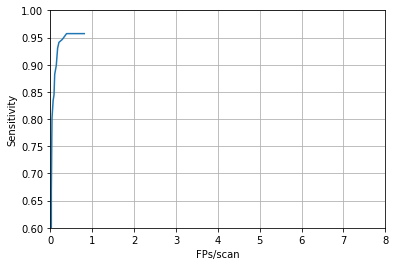

In [125]:
plt.plot(fpr,tpr)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0.6, 1.0)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')

In [79]:
def get_metrics(y_true, y_pred):
    FPR, TPR, _ = roc_curve(y_true, y_pred)
    auc_score = auc(FPR, TPR)
    n = len(y_true)
    y_pred_cls = np.where(y_pred > 0.5, 1, 0).astype(np.int)
    TP = np.sum(y_pred[y_true == 1])
    FN = np.sum(y_true) - TP
    FP = np.sum(y_pred) - TP
    TN = n - TP - FN - FP
    acc = (TP + TN) / n
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    return acc, precision, recall, auc_score

In [80]:
def eval_cls(y_true, res):
    y = []
    for x in y_true:
        y += x    
    y = np.array(y)
#     print(y)
    fpr = torch.cat([x[0] for x in res])
    cls = torch.cat([x[1] for x in res])
    fpr = torch.softmax(fpr, dim=1).numpy()[:, 1]
    cls = torch.softmax(cls, dim=1).numpy()[:, 1]
    y1 = y.copy()
    y1[y>1] = 1
    y2 = y[y>0] - 1
    cls = cls[y>0]
    
    metric1 = get_metrics(y1, fpr)
    metric2 = get_metrics(y2, cls)
    return metric1, metric2

In [17]:
def get_FP_recall(y_true1, res1):
    y_true1_ = []
    for y in y_true1:
        y_true1_ += y
    y_true1_ = np.array(y_true1_)
    res1_ = [torch.argmax(x, dim=1) for x in res1]
    res1_ = torch.cat(res1_).numpy()
#     res1_[res1_>0] = 1
    FP = np.mean(res1_[y_true1_ > 0] > 0)
    cls2 = np.mean(res1_[y_true1_ == 2] == 2)
    cls1 = np.mean(res1_[y_true1_ == 1] == 1)
    cls = np.mean(res1_[y_true1_ > 0] == y_true1_[y_true1_ > 0])
    return FP, cls1, cls2, cls

In [85]:
eval_cls(y_true, res)

((0.9687000662061127, 0.2949597, 0.9139293569379148, 0.9858521468756173),
 (0.7349792075368156, 0.71266145, 0.5086215706758721, 0.7808970099667775))

In [112]:
with open('results/lesion_size.json', 'r') as f:
    lesion = json.load(f)

len(lesion.keys())

1136

In [66]:
fpr = torch.cat([x[0] for x in res])
cls = torch.cat([x[1] for x in res])
fpr = torch.softmax(fpr, dim=1).numpy()[:, 1]
cls = torch.softmax(cls, dim=1).numpy()[:, 1]

In [77]:
np.where(fpr > 0.5, 0, 1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [78]:
fpr

array([0.        , 0.        , 0.        , 0.00628931, 0.00628931,
       0.01886792, 0.01886792, 0.02515723, 0.02515723, 0.03773585,
       0.03773585, 0.04402516, 0.04402516, 0.05031447, 0.05031447,
       0.05660377, 0.05660377, 0.06289308, 0.06289308, 0.06918239,
       0.06918239, 0.0754717 , 0.0754717 , 0.08176101, 0.08176101,
       0.08805031, 0.08805031, 0.09433962, 0.09433962, 0.10062893,
       0.10062893, 0.10691824, 0.10691824, 0.13207547, 0.13207547,
       0.14465409, 0.14465409, 0.1509434 , 0.1509434 , 0.1572327 ,
       0.1572327 , 0.18238994, 0.18238994, 0.20125786, 0.20125786,
       0.22641509, 0.22641509, 0.24528302, 0.24528302, 0.25157233,
       0.25157233, 0.25786164, 0.25786164, 0.27044025, 0.27044025,
       0.28301887, 0.28301887, 0.31446541, 0.31446541, 0.32075472,
       0.32075472, 0.33333333, 0.33333333, 0.40880503, 0.40880503,
       0.42767296, 0.42767296, 0.43396226, 0.43396226, 0.44025157,
       0.44025157, 0.44654088, 0.44654088, 0.47169811, 0.47169

In [57]:
y1 = y.copy()
y1[y>1] = 1

In [71]:
y2 = y[y>0] - 1
cls = cls[y>0]

In [72]:
fpr, tpr, _ = roc_curve(y2, cls)

In [73]:
auc(fpr, tpr)

0.7882954908858331

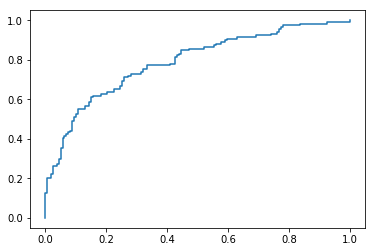

In [74]:
plt.plot(fpr, tpr)

In [34]:
y_true1_ = []
for y in y_true1:
    y_true1_ += y

In [36]:
y_true1_ = np.array(y_true1_)

In [28]:
res1_ = [torch.argmax(x, dim=1) for x in res1]

In [30]:
res1_ = torch.cat(res1_)

In [37]:
res1_ = res1_.numpy()

In [38]:
res1_[res1_>0] = 1

In [39]:
np.mean(res1_[y_true1_ > 0] == 1)

0.9090909090909091

In [18]:
get_FP_recall(y_true, res)

(0.8849557522123894,
 0.7857142857142857,
 0.5465116279069767,
 0.6946902654867256)

In [20]:
get_FP_recall(y_true1, res1)

/home/jxw/anaconda3/envs/tf2.0/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jxw/anaconda3/envs/tf2.0/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.9090909090909091, 0.6318181818181818, nan, 0.6318181818181818)

In [13]:
test_acc

0.9889600487953645

In [40]:
preds = [sigmiod_(pred.numpy()) for pred in res]

In [14]:
recall

0.6946902654867256

In [29]:
def sigmiod_(x):
    return -np.log(1/x-1)

In [41]:
preds = [torch.softmax(torch.from_numpy(pred), 1) for pred in preds]

In [43]:
preds = [pred.numpy() for pred in preds]

In [45]:
preds[0].shape

(73, 2)

In [23]:
len(test_res[names[0]]['bbox_pred'])

73

In [53]:
preds[0][:, 1] > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [50]:
names[0]

'0274937'

In [46]:
test_res_new = {}
for i, name in enumerate(names):
    now = test_res[name]
    idx = preds[i][:, 1] >= 0.5
    now['bbox_pred'] = np.array(test_res[name]['bbox_pred'])[idx].tolist()
    now['score'] = np.array(test_res[name]['score'])[idx].tolist()
    test_res_new[name] = now

In [58]:
for name in names:
    if test_res_new[name]['bbox_pred'] ==[]:
        print(name)

0383210


In [61]:
a = np.array(test_res['0383210']['bbox_pred'])

In [62]:
a.ndim

1

In [64]:
test_res_new.pop('0383210')

{'bbox_gt': [[0.8412371134020619,
   0.501953125,
   0.52734375,
   0.11206313752461358,
   0.09577241645244217,
   0.09376904884318765]],
 'bbox_pred': [],
 'score': []}

100%|██████████| 186/186 [00:00<00:00, 1906.40it/s]


Text(0, 0.5, 'Sensitivity')

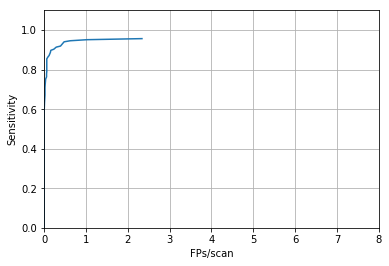

In [10]:
fps, tps, traintps = froc(test_res_new, 'iou', iou_threshold=0.3)
plt.plot(fps,tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0, 1.1)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
# plt.savefig('results/FP_reduction.png')

In [11]:
tps

array([0.95698925, 0.9516129 , 0.94623656, 0.94086022, 0.91935484,
       0.91397849, 0.90322581, 0.89784946, 0.88709677, 0.88709677,
       0.87096774, 0.87096774, 0.8655914 , 0.86021505, 0.85483871,
       0.83870968, 0.80107527, 0.79032258, 0.77956989, 0.76344086,
       0.75268817, 0.72580645, 0.70967742, 0.67204301, 0.6344086 ,
       0.57526882, 0.53225806, 0.48387097, 0.40860215, 0.33333333,
       0.2311828 , 0.1344086 , 0.06989247, 0.03763441, 0.03225806,
       0.01075269, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [12]:

for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
    for i in range(len(fps)):
        if fps[i] >= n and fps[i+1] <= n:
            temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
            print(n, temp)
            break

0.125 0.8743279569892473
0.25 0.9066471163245357
0.5 0.9416567104739149
1 0.9512544802867384
2 0.9556010928961749


In [6]:
a = [[] for i in range(5)]
for name in test_res.keys():
    idx = int(sum(lesion_size[name][0]) / 3 // 10)
    if idx < 3:
        a[0].append(name)
    elif 3<=idx<5:
        a[1].append(name)
    elif 5<=idx<7:
        a[2].append(name)
    elif 7<=idx<10:
        a[3].append(name)
    else:
        a[4].append(name)

In [44]:
for b in a:
    print(len(b))
    res = {}
    for name in b:
        if name not in test_res_new: continue
        res[name] = test_res_new[name]
        fps, tps, traintps = froc(res, 'iou', iou_threshold=0.3)
        sen = []
    for n in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
        for i in range(len(fps)):
            if fps[i] >= n and fps[i+1] <= n:
                temp = (tps[i] - tps[i+1]) / (fps[i] - fps[i+1]) * (n - fps[i+1]) + tps[i+1]
                print(n, temp)
                sen.append(temp)
                break
    print(np.mean(sen))

  0%|          | 0/15 [00:00<?, ?it/s]

25


100%|██████████| 15/15 [00:00<00:00, 717.13it/s]


0.125 0.8
0.25 0.8
0.5 0.84
1 0.8844444444444445
0.8311111111111111
61


  0%|          | 0/15 [00:00<?, ?it/s]

0.125 0.9333333333333333
0.25 0.9333333333333333
0.5 0.95
1 0.95
0.9416666666666667
53


  0%|          | 0/19 [00:00<?, ?it/s]

0.125 0.8985849056603774
0.25 0.9141509433962265
0.5 0.9433962264150944
1 0.9433962264150944
2 0.9433962264150944
0.9285849056603774
28


100%|██████████| 20/20 [00:00<00:00, 2200.46it/s]

0.125 1.0
0.25 1.0
0.5 1.0
1 1.0
2 1.0
1.0
20
0.125 0.25
0.25 0.5
0.5 0.8
1 0.9249999999999999
2 1.0
4 1.0
0.7458333333333332


In [10]:
for name in a[1]:
    print(name, lesion_size[name])

0489094 [[37.718770078614305, 45.77748, 43.733340000000005]]
0337370 [[41.708473107384854, 29.44557, 38.367419999999996]]
0271298 [[44.91522, 48.075720000000004, 39.22485]]
0448657 [[31.31691635096425, 37.70445, 32.68146]]
0283441 [[54.60000000000001, 34.483470000000004, 54.14976]]
0365751 [[37.828367993598135, 42.36183, 42.75831]]
0274306 [[36.183209999999995, 27.007679999999997, 38.40795000000001]]
0287514 [[63.804300000000005, 39.08667, 44.17182]]
0364881 [[40.99623018052074, 38.2305, 48.88023]]
0393979 [[38.392876738560375, 41.21838, 36.399930000000005]]
0498180 [[42.3174050833045, 27.16728, 36.110969999999995]]
0416700 [[55.74179759863976, 40.94013, 46.467540000000014]]
0350104 [[50.8474182241308, 31.68522, 41.30133]]
0447107 [[54.64098221509735, 46.61412, 47.12273999999999]]
0335980 [[39.24644846338595, 30.39582, 20.436465]]
0321859 [[42.34635865376913, 31.31415, 34.925520000000006]]
0362227 [[42.93369143021308, 31.27362, 33.190290000000005]]
0284239 [[54.97485, 31.10751000000000

In [42]:
def sigmiod(x):
    return 1 / (1 + np.exp(-x))

In [37]:
recall

0.990909090909091

In [41]:
num_postive

220.0

In [21]:
a = [1, 4, 2,5]
b = a.copy()

In [22]:
a[0] = 3

In [23]:
np.random.shuffle(a)

In [25]:
b

[1, 4, 2, 5]

In [103]:
labels = []
preds = []
res = {}
model.model.eval()
with torch.no_grad():
    for name in tqdm(datagenerator.train_list):
        t = {}
        labels = []
        preds = []
        bbox, label = datagenerator.get_all_bbox(name, True, False)
        for i in range(0, len(label), 16):
            ims = torch.tensor(bbox[i:i+16], dtype=torch.float32).cuda()
            pred, _ = model.model(ims)
            pred = pred.cpu().detach()
#             pred = torch.softmax(pred, dim=0).cpu().detach()
            preds.append(pred)
        preds = torch.cat(tuple(preds), dim=0).numpy()
        labels += label
        t['label'] = labels
        t['pred'] = preds
        res[name] = t

100%|██████████| 187/187 [25:51<00:00,  8.71s/it]


In [105]:
with open('./results/test_single_torch.json', 'r') as f:
    test_res1 = json.load(f)

In [9]:
with open('./results/test_single_torch_fp.json', 'r') as f:
    test_res_new = json.load(f)

In [4]:
with open('./results/lesion_size.json', 'r') as f:
    lesion_size = json.load(f)

In [127]:
with open('./results/fold0_test_fp.json', 'w') as f:
    json.dump(test_res3, f)

In [106]:
for name in res.keys():
    test_res1[name]['cls'] = np.argmax(res[name]['pred'], axis=1).tolist()

In [107]:
def get_new_res(test_res):
    test_res2 = {}
    for i, name in enumerate(test_res.keys()):
    #     if i < 13:
    #         continue
        temp = {}
        bbox = np.array(test_res[name]['bbox_pred'])
        score = np.array(test_res[name]['score'])
        cls = np.array(test_res[name]['cls'])
        idx = cls > 0
        if np.sum(idx) < 1:
            idx = np.array([0])
        temp['bbox_pred'] = bbox[idx].tolist()
        temp['score'] = score[idx].tolist()
        temp['bbox_gt'] = test_res[name]['bbox_gt']
        test_res2[name] = temp
    return test_res2
#     print(bbox.shape, score.shape, cls.shape)
#     break

In [15]:
with open('./results/lesion_size.json', 'r') as f:
    lesion = json.load(f)


In [16]:
results = [0, 0, 0, 0, 0]
c = 0
for name in lesion.keys():
    for l in lesion[name]:
        s = np.mean(l)
        c += 1
        if s < 30:
            results[0] += 1
        elif s >= 30 and s < 50:
            results[1]+= 1
        elif s >= 50 and s < 70:
            results[2]+=1
        elif s >= 70 and s < 100:
            results[3]+= 1
        elif s >= 100:
            results[4]+= 1

In [17]:
results

[358, 366, 236, 119, 73]

In [18]:
c

1152

In [108]:
test_res3 = get_new_res(test_res1)

In [111]:
test_res3.update(test_res2)

In [121]:
fps, tps, tr = froc(test_res3, 'iou', mesh=np.arange(0.01, 0.6, 0.001))

100%|██████████| 200/200 [00:01<00:00, 179.26it/s]


In [123]:
fps = np.insert(fps,0, 10)
tps = np.insert(tps,0, np.max(tps))

In [124]:
fps

array([1.000e+01, 1.835e+00, 1.685e+00, 1.595e+00, 1.480e+00, 1.410e+00,
       1.335e+00, 1.265e+00, 1.220e+00, 1.125e+00, 1.085e+00, 1.030e+00,
       9.100e-01, 8.750e-01, 7.950e-01, 7.400e-01, 7.300e-01, 6.950e-01,
       6.750e-01, 6.400e-01, 6.150e-01, 6.000e-01, 5.750e-01, 5.400e-01,
       5.150e-01, 5.100e-01, 4.850e-01, 4.800e-01, 4.700e-01, 4.550e-01,
       4.500e-01, 4.350e-01, 4.200e-01, 4.000e-01, 4.000e-01, 3.850e-01,
       3.800e-01, 3.700e-01, 3.600e-01, 3.500e-01, 3.400e-01, 3.400e-01,
       3.350e-01, 3.300e-01, 3.250e-01, 3.250e-01, 3.000e-01, 2.900e-01,
       2.850e-01, 2.600e-01, 2.550e-01, 2.550e-01, 2.500e-01, 2.500e-01,
       2.500e-01, 2.450e-01, 2.400e-01, 2.400e-01, 2.300e-01, 2.250e-01,
       2.150e-01, 2.150e-01, 2.050e-01, 2.000e-01, 1.900e-01, 1.800e-01,
       1.700e-01, 1.700e-01, 1.700e-01, 1.600e-01, 1.600e-01, 1.600e-01,
       1.600e-01, 1.600e-01, 1.600e-01, 1.600e-01, 1.600e-01, 1.550e-01,
       1.550e-01, 1.500e-01, 1.500e-01, 1.500e-01, 

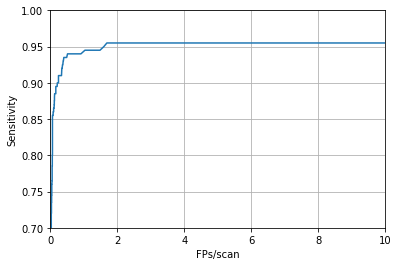

In [126]:
plt.plot(fps, tps)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 10)
plt.ylim(0.7, 1)
plt.xlabel('FPs/scan')
plt.ylabel('Sensitivity')
plt.savefig('fold0_test_fp.jpg')

In [14]:
res1 = res

In [15]:
labels = []
preds = []
res = {}
model.model.eval()
with torch.no_grad():
    for name in tqdm(datagenerator.train_list):
        t = {}
        labels = []
        preds = []
        bbox, label = datagenerator.get_all_bbox(name, True, False)
        for i in range(0, len(label), 16):
            ims = torch.tensor(bbox[i:i+16], dtype=torch.float32).cuda()
            pred = model.model(ims).cpu().detach()
#             pred = torch.softmax(pred, dim=0).cpu().detach()
            preds.append(pred)
        preds = torch.cat(tuple(preds), dim=0).numpy()
        labels += label
        t['label'] = labels
        t['pred'] = preds
        res[name] = t

100%|██████████| 187/187 [11:50<00:00,  4.12s/it]


In [16]:
res

{'0456073': {'label': [1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'pred': array([[-8.007953  ,  3.6368465 , -0.987057  ],
         [-2.2533    ,  1.0842693 , -1.5139507 ],
         [ 3.3138354 , -1.8002194 , -2.8421433 ],
         [10.853862  , -4.5099964 , -8.396045  ],
         [ 5.4464307 , -1.6477982 , -5.204943  ],
         [ 7.876732  , -4.1474156 , -4.798078  ],
         [ 9.59974   , -6.2605805 , -5.1940956 ],
         [ 2.4230068 , -0.16865265, -4.196654  ],
         [12.786015  , -6.540589  , -7.7897024 ],
         [ 9.423223  , -4.836461  , -6.1122227 ],
         [ 9.429345  , -5.302342  , -5.700627  ],
         [ 8.774938  , -3.77040

In [76]:
def roc_cur(preds, labels, preds_, y_true_):
    preds = torch.cat(tuple(preds), dim=0)
#     preds = torch.cat((preds, preds_[-1500:-409]), dim=0)
    preds = torch.softmax(preds, dim=1).numpy()
    pred_label = np.argmax(preds, axis=1)
    labels = np.array(labels)
    preds[:, 1] += preds[:, 2]
    y_true = np.array(labels > 0, dtype=np.int32)
#     y_true = np.append(y_true, y_true_[-1500:-409])
    fpr, tpr, th = roc_curve(y_true, np.maximum(preds[:, 1], 0))
    return fpr, tpr, pred_label

In [71]:
len(preds)

34

In [39]:
len(labels)

409

In [41]:
preds_[-2000:-409]

torch.Size([21545, 3])

In [7]:
preds_ = torch.cat(tuple(preds), dim=0)

In [12]:
preds = torch.softmax(preds_, dim=1)

In [14]:
preds = preds.numpy()

In [17]:
labels = np.array(labels)

In [18]:
preds[:, 1] += preds[:, 2]

In [22]:
y_true = np.array(labels > 0, dtype=np.int32)

In [20]:
from sklearn.metrics import roc_curve, auc

In [78]:
fpr, tpr, pred_label = roc_cur(preds, labels, preds_, y_true)

In [79]:
pred_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [81]:
labels = np.array(labels)

In [82]:
labels

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,

In [83]:
pred1 = np.array(pred_label > 0, np.int32)
label1 = np.array(labels > 0, np.int32)

In [84]:
TP = np.sum(label1[pred1 == 1])
FN = np.sum(label1) - TP
FP = np.sum(pred1[label1==0])
TN = np.sum(label1==0) - FP

In [87]:
print(TP, FN, FP, TN)

16 4 6 383


In [88]:
TP / (TP + FN)

0.8

In [74]:
auc(fpr, tpr)

0.9582262210796916

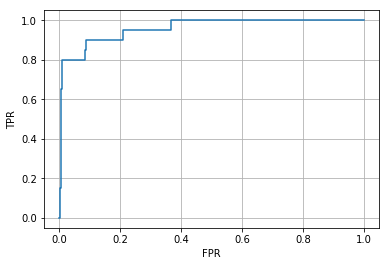

In [75]:
plt.plot(fpr, tpr)
plt.grid(True, which="both",ls="-") 
# plt.xlim(0, 1.0)
# plt.ylim(0, 1.1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('./results/roc.jpg')

In [37]:
tpr

array([0.  , 0.  , 0.15, 0.15, 0.65, 0.65, 0.75, 0.75, 0.8 , 0.8 , 0.85,
       0.85, 0.9 , 0.9 , 0.95, 0.95, 1.  , 1.  ])

In [38]:
fpr

array([0.        , 0.00257069, 0.00257069, 0.00514139, 0.00514139,
       0.00771208, 0.00771208, 0.01028278, 0.01028278, 0.0848329 ,
       0.0848329 , 0.0874036 , 0.0874036 , 0.21079692, 0.21079692,
       0.36760925, 0.36760925, 1.        ])

In [49]:
torch.softmax(pred, dim=1)

tensor([[0.2981, 0.3454, 0.3565],
        [0.2913, 0.3812, 0.3276],
        [0.3206, 0.3002, 0.3792],
        [0.2585, 0.4484, 0.2931],
        [0.4175, 0.2914, 0.2911],
        [0.4446, 0.2646, 0.2908],
        [0.3131, 0.3062, 0.3807]])

In [112]:
torch.argmax(pred, dim=1)

tensor([1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [20]:
torch.eq(a, torch.tensor(label, dtype=torch.long).cuda()).sum().item()

15

In [21]:
label.shape[0]

AttributeError: 'list' object has no attribute 'shape'

In [136]:
res = {}
for i in range(5):
    with open('./results/fold{}.json'.format(i), 'r') as f:
        fold = json.load(f)
        res.update(fold)

In [137]:
len(res.keys())

936

In [25]:
with open('./results/5_fold.json', 'w') as f:
    json.dump(res, f)

TypeError: Object of type ndarray is not JSON serializable

In [56]:
path = "/home/jxw/PycharmProjects/centernet3d/medical-detection-toolkit/experiments/my_exp/exp_dir/"

In [52]:
epoch_rank_file = os.path.join(path, 'fold4/epoch_ranking.npy')
epoch_rank = np.array([52, 42])
np.save(epoch_rank_file, epoch_rank)

In [47]:
epoch_rank

array([29, 42, 27, 52, 25])

In [71]:
detection = {}
for i in range(5):
    name = os.path.join(path, "fold{}/raw_pred_boxes_list.pickle".format(i))
    with open(name, 'rb') as f:
        res = pickle.load(f)
    for d in res:
        now = {}
        box_pred = []
        scores = []
        boxes = d[0]['boxes'][0]
        boxes_gt = transform_bbox(d[0]['boxes_gt']) / 128
        print(len(boxes))
        for box in boxes:
            box_pred.append(box['box_coords'])
            scores.append(float(box['box_score']))
        box_pred = transform_bbox(np.array(box_pred)) / 128
        now['bbox_gt'] = boxes_gt.astype(np.float).tolist()
        now['bbox_pred'] = box_pred.astype(np.float).tolist()
        now['score'] = scores
        detection[d[1]] = now

75
86
85
119
95
150
100
150
76
111
150
150
150
150
114
147
125
91
130
150
145
106
109
58
141
150
150
132
150
147
83
150
150
136
69
150
140
111
149
149
150
104
127
109
126
149
86
139
63
60
150
117
149
71
142
110
150
134
144
118
141
150
143
145
145
127
113
111
101
150
150
150
150
142
133
150
150
98
149
72
150
148
116
147
150
86
150
115
130
137
150
142
80
78
63
84
150
147
92
132
142
112
135
148
80
146
122
104
92
127
149
84
138
134
143
150
109
150
126
122
64
150
63
131
106
144
150
100
130
139
146
149
139
118
99
150
150
105
133
145
104
119
150
150
78
150
142
150
150
95
137
115
133
150
150
85
147
145
149
114
96
96
150
129
83
108
131
108
89
150
88
133
94
99
147
150
150
150
150
146
141
68
95
120
150
101
108
150
150
104
120
118
150
107
124
149
150
150
150
116
75
137
108
141
105
150
141
150
110
114
84
123
150
150
150
136
134
150
150
110
150
150
149
132
95
149
138
150
149
150
144
132
149
150
143
110
127
112
105
150
93
137
133
150
150
150
122
150
150
135
150
150
150
95
113
142
150
88
128
138
150
1

In [61]:
detection['0691505']

{'bbox_gt': [[0.6317016317016317,
   0.43359375,
   0.38671875,
   0.201627952419017,
   0.18532370370370366,
   0.23065648148148155]],
 'bbox_pred': [[0.6484375, 0.4296875, 0.375, 0.1953125, 0.1953125, 0.171875],
  [0.6328125, 0.4296875, 0.359375, 0.2109375, 0.1796875, 0.1875],
  [0.6328125, 0.421875, 0.359375, 0.1796875, 0.1796875, 0.1640625],
  [0.6484375, 0.421875, 0.359375, 0.2421875, 0.21875, 0.2265625],
  [0.6484375, 0.4140625, 0.3671875, 0.1640625, 0.1484375, 0.1640625],
  [0.640625, 0.40625, 0.3359375, 0.2265625, 0.1640625, 0.1640625],
  [0.640625, 0.4296875, 0.375, 0.2421875, 0.1953125, 0.171875],
  [0.6328125, 0.4296875, 0.375, 0.1953125, 0.171875, 0.15625],
  [0.625, 0.4375, 0.3828125, 0.171875, 0.1640625, 0.140625],
  [0.6328125, 0.4296875, 0.3828125, 0.2421875, 0.15625, 0.1640625],
  [0.6484375, 0.421875, 0.390625, 0.171875, 0.1640625, 0.15625],
  [0.6484375, 0.4296875, 0.3671875, 0.171875, 0.203125, 0.1328125],
  [0.65625, 0.421875, 0.34375, 0.2109375, 0.1796875, 0.14843

In [34]:
det2['0691505']

{'bbox_gt': [[0.6317016317016317,
   0.43359375,
   0.38671875,
   0.201627952419017,
   0.18532370370370366,
   0.23065648148148155]],
 'bbox_pred': [[0.6328125,
   0.421875,
   0.359375,
   0.2265625,
   0.1796875,
   0.1796875],
  [0.640625, 0.421875, 0.359375, 0.203125, 0.15625, 0.1796875],
  [0.640625, 0.4296875, 0.359375, 0.203125, 0.1484375, 0.15625],
  [0.625, 0.4296875, 0.3671875, 0.1953125, 0.15625, 0.1640625],
  [0.640625, 0.4296875, 0.3671875, 0.2265625, 0.15625, 0.1796875]],
 'score': [1.0, 0.9999998807907104, 1.0, 1.0, 0.9999998807907104]}

In [32]:
det2.keys()

dict_keys(['0519697', '0691505', '0433653', '0432631', '1054058', '0658824', '0581949', '0465377', '0696453', '0468025', '0484603', '0608154', '0625438', '0755440', '0518724', '0563726', '0418817', '0297439', '0396642', '0446336', '0613060', '0274603', '0529863', '0316109', '1001736', '0996588', '0284239', '0565799', '0435628', '0992584', '0992301', '0369643', '0439879', '0491627', '0430982', '0793634', '0316174', '0429573', '0631935', '1086016', '0442015', '0337370', '0352359', '0899161', '0332291', '0364836', '0317880', '0797919', '0456073', '0439516', '0639653', '0328750', '0456304', '1242902', '0807839', '0308594', '0493107', '0769488', '0944023', '0409810', '0599469', '1011772', '0499642', '0560757', '0703186', '0683197', '0739659', '0544963', '0340334', '0781446', '1044804', '0538681', '0755445', '0394686', '0398752', '1072990', '0461712', '0798373', '0744139', '0534042', '0770929', '1023270', '0430469', '0563023', '0606081', '0472212', '0482660', '0794855', '0789939', '0917409',

In [7]:
def transform_bbox(bbox, maxlen=128):
    if isinstance(bbox, list):
        bbox = np.array(bbox)
    if bbox.ndim == 1:
        bbox = np.expand_dims(bbox, 0)
    bbox_new = np.zeros_like(bbox)
    bbox_new[:, 0] = (bbox[:, 4] + bbox[:, 5]) / 2    # z
    bbox_new[:, 1] = (bbox[:, 0] + bbox[:, 2]) / 2    # x
    bbox_new[:, 2] = (bbox[:, 1] + bbox[:, 3]) / 2    # y
    bbox_new[:, 3] = bbox[:, 5] - bbox[:, 4]    # d
    bbox_new[:, 4] = bbox[:, 2] - bbox[:, 0]    # h
    bbox_new[:, 5] = bbox[:, 3] - bbox[:, 1]    # w
    bbox_new = np.maximum(bbox_new, 0)
    bbox_new = np.minimum(bbox_new, maxlen-1)
    return bbox_new

In [9]:
for k in detection:
    print(detection[k])
    break

{'bbox_gt': [[0.6673819742489271, 0.384765625, 0.564453125, 0.15780046706235917, 0.10436023255813953, 0.10705550387596907]], 'bbox_pred': [[0.0078125, 0.9609375, 0.9609375, 0.015625, 0.078125, 0.0546875], [0.8828125, 0.3984375, 0.5, 0.21875, 0.1796875, 0.1875], [0.9375, 0.1484375, 0.8046875, 0.1015625, 0.1015625, 0.1015625], [0.921875, 0.1640625, 0.90625, 0.0390625, 0.078125, 0.046875], [0.1171875, 0.6796875, 0.6171875, 0.234375, 0.21875, 0.171875], [0.3125, 0.203125, 0.765625, 0.1171875, 0.1328125, 0.09375], [0.9453125, 0.109375, 0.53125, 0.0546875, 0.0625, 0.0546875], [0.59375, 0.515625, 0.25, 0.0546875, 0.0625, 0.046875], [0.890625, 0.5078125, 0.125, 0.0390625, 0.0546875, 0.046875], [0.4609375, 0.515625, 0.25, 0.0546875, 0.0625, 0.046875], [0.1015625, 0.515625, 0.25, 0.0625, 0.0625, 0.0546875], [0.0625, 0.5546875, 0.8046875, 0.1171875, 0.109375, 0.109375], [0.0703125, 0.4296875, 0.8046875, 0.109375, 0.109375, 0.1015625], [0.078125, 0.296875, 0.7578125, 0.1328125, 0.1015625, 0.109375

100%|██████████| 1136/1136 [00:01<00:00, 948.76it/s]


(0.4, 1.0)

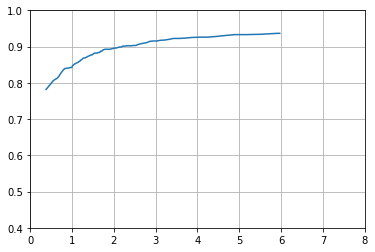

In [10]:
fpr, tpr, _ = froc(detection, method="iobb", mesh=np.arange(0, 1, 0.01) ,iou_threshold=0.3, nms=False)
plt.plot(fpr, tpr)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0.4, 1.0)

100%|██████████| 1136/1136 [00:01<00:00, 998.14it/s] 


(0.4, 1.0)

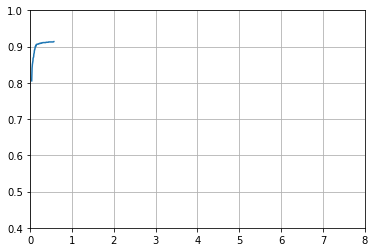

In [73]:
fpr, tpr, _ = froc(detection, method="iobb", mesh=np.arange(0, 1, 0.01) ,iou_threshold=0.3, nms=True)
plt.plot(fpr, tpr)
plt.grid(True, which="both",ls="-") 
plt.xlim(0, 8)
plt.ylim(0.4, 1.0)

In [69]:
fpr

array([54.89612676, 54.89612676, 54.89612676, 54.01760563, 53.05457746,
       52.07570423, 51.00528169, 49.91549296, 48.75264085, 47.50704225,
       46.28080986, 45.0528169 , 43.89876761, 42.66197183, 41.49647887,
       40.34683099, 39.29577465, 38.22183099, 37.17429577, 36.18485915,
       35.24471831, 34.33978873, 33.49911972, 32.66021127, 31.8653169 ,
       31.08714789, 30.36091549, 29.64788732, 28.89172535, 28.22887324,
       27.54577465, 26.90492958, 26.29137324, 25.70862676, 25.14524648,
       24.58362676, 24.06602113, 23.56954225, 23.07394366, 22.54225352,
       22.08890845, 21.59507042, 21.11179577, 20.64524648, 20.18485915,
       19.7209507 , 19.28697183, 18.88116197, 18.46566901, 18.10211268,
       17.69630282, 17.30105634, 16.95598592, 16.58538732, 16.19982394,
       15.85827465, 15.48943662, 15.12147887, 14.79489437, 14.43661972,
       14.09066901, 13.73415493, 13.41725352, 13.11267606, 12.80721831,
       12.52288732, 12.2068662 , 11.90757042, 11.62852113, 11.30

In [77]:
get_sensitivity(fpr, tpr)

0.125 0.9005
0.25 0.9093
0.5 0.9129
1 0.9129
2 0.9129
4 0.9129
8 0.9129
avg:  0.9106


[0.9005281690140845,
 0.909330985915493,
 0.9128521126760564,
 0.9128521126760564,
 0.9128521126760564,
 0.9128521126760564,
 0.9128521126760564,
 0.9105885311871227]

In [46]:
len(detection)

1136

In [78]:
with open('./results2/detection_mrcnn8.json', 'w') as f:
    json.dump(detection, f)

In [30]:
with open('./results2/detection_mrcnn5.json', 'r') as f:
    det2 = json.load(f)

In [38]:
path = './results/img/'
out_path = './results/cls_example/'

In [39]:
src = {
    'tp':[
        ['0581949', '97'],
        ['0398752', '96'],
        ['0281688', '86'],
        ['0417111', '75'],
    ],
    'fp':[
        ['0433653', '105'],
        ['0325177', '98'],
        ['0443902', '108'],
        ['0366996', '80'],
        ['0482121', '70'],
    ],
    'fn':[
        ['0303550', '66'],
        ['0408327', '105'],
        ['1053839', '112'],
        ['0792267', '111'],
        ['0420652', '66'],
    ]
}

In [40]:
for k in src:
    lst = src[k]
    for img in lst:
        org = os.path.join(path, img[0], img[1] + '.png')
        if not os.path.exists(org):
            print(org, 'not exists.')
        out = os.path.join(out_path, k, img[0]+'_'+img[1]+'.png')
        os.popen('cp ' + org + ' ' + out)

In [42]:
fpr, tpr, _ = froc(fpr_results, method="iobb", iou_threshold=0.3, nms=False)




  0%|          | 0/1136 [00:00<?, ?it/s]


 16%|█▋        | 185/1136 [00:00<00:00, 1844.45it/s]


 26%|██▋       | 299/1136 [00:00<00:00, 1554.37it/s]


 41%|████      | 463/1136 [00:00<00:00, 1577.91it/s]


 56%|█████▌    | 636/1136 [00:00<00:00, 1620.33it/s]


 68%|██████▊   | 778/1136 [00:00<00:00, 1554.03it/s]


 85%|████████▍ | 961/1136 [00:00<00:00, 1627.36it/s]


 97%|█████████▋| 1106/1136 [00:00<00:00, 1568.17it/s]


100%|██████████| 1136/1136 [00:00<00:00, 1561.15it/s]

In [47]:
idx = np.where(_[:, 0] == 0)[0]

In [46]:
k = list(fpr_results.keys())

In [48]:
for i in idx:
    print(k[i])

0446336
0418595
1087971
0471730
0784582
0453066
0440434
0361248
0957174
0270328
1022016
0640765
0345373
0758211
0266479
0634306
0261263
0525594
0464168
0383210
1054604
0628962
0521447


In [49]:
src = {
    'tp':[
        
    ],
    'fp':[
        ['0', '0446336', '75'],
        ['1', '0471730', '105'],
        ['1', '0261263', '115'],
        ['0', '0464168', '90'],
    ],
    'fn':[
        ['0', '0446336', '108'],
        ['0', '0418595', '101'],
        ['1', '0471730', '62'],
        ['3', '0640765', '42'],
        ['0', '0634306', '60'],
        ['0', '0464168', '140']
    ]
}

In [50]:
path = './results/img3'
out_path = './results/img3/res'
for k in src:
    lst = src[k]
    for img in lst:
        org = os.path.join(path, img[0], img[1], img[2] + '.png')
        if not os.path.exists(org):
            print(org, 'not exists.')
        out = os.path.join(out_path, k, img[1]+'_'+img[2]+'.png')
        os.popen('cp ' + org + ' ' + out)

In [13]:
path = './results/img3'
out_path = './results/img3/res/org'
imgs = glob.glob(os.path.join(out_path, '*.png'))

In [17]:
imgs

['./results/img3/res/org/17.png',
 './results/img3/res/org/20.png',
 './results/img3/res/org/2.png',
 './results/img3/res/org/1.png',
 './results/img3/res/org/16.png',
 './results/img3/res/org/5.png',
 './results/img3/res/org/12.png',
 './results/img3/res/org/15.png',
 './results/img3/res/org/13.png',
 './results/img3/res/org/11.png',
 './results/img3/res/org/19.png',
 './results/img3/res/org/9.png',
 './results/img3/res/org/3.png',
 './results/img3/res/org/10.png',
 './results/img3/res/org/8.png',
 './results/img3/res/org/14.png',
 './results/img3/res/org/4.png',
 './results/img3/res/org/7.png',
 './results/img3/res/org/6.png',
 './results/img3/res/org/18.png']

In [16]:
md5s

['065bc7c332724d281519f01dd173083a',
 '7eeeafc2b2c4ae7a60cccca758f2e1d7',
 '01766608bd29171a3001e1dbed8988cf',
 '3ff4bb0ef0b5ba3729f383e57d4f0159',
 '80921843fa3d0b96b8a89e2255c32a67',
 '0adc9bb52edce5524f3948c076a66657',
 '5f59f214a5ba6979aafbe28329253185',
 'eed3f51a3f67c3b9709e996e34f29994',
 'b3cd8850c5d22fef8be1c4afec4785e5',
 '28056e1b334adbeb21415e112b898883',
 '97ced03652bb5b63c8375cb09fdc1e5f',
 '840b016071470b8d736006d2a4b56a0d',
 '49004824b2e39aaa933f65ae05f3b5a6',
 '33db027237d075bd0bf5a4d133a2a4c5',
 '9baaa03555c8376d54ebb0d285178d6c',
 '05b6d562e5190d9b96e7a8761fc539f8',
 '1c7ee1b3fd7d155a70c0aec78d89413c',
 '0de72ffae66f0f824d99fd5ffcec92b8',
 '20cbc0a1936e7fafb4cb61927e8a23fd',
 'e8be80f8fa96bea579381617d8edab65']

In [19]:
md5s = []
for img in imgs:
    md5 = os.popen('md5sum ' + img).read().split(' ', 1)[0]
    md5s.append(md5)
for i in range(5):
    if len(imgs) == 0:
        break
    now_path = os.path.join(path, str(i))
    lst = os.listdir(now_path)
    for name in tqdm(lst):
        if len(imgs) == 0:
            break
        now_path2 = os.path.join(now_path, name)
        pngs = os.listdir(now_path2)
        for png in pngs:
            png_path = os.path.join(now_path2, png)
            md5_temp = os.popen('md5sum ' + png_path).read().split(' ', 1)[0]
#             print(md5_temp)
            for j in range(len(imgs)):
                if md5s[j] == md5_temp:
                    dst = os.path.join(out_path, name + '_' + png)
                    print(imgs[j], png_path, dst)
                    os.popen(' '.join(['cp', png_path, dst]))
                    del md5s[j]
                    del imgs[j]
                    break



 97%|█████████▋| 309/319 [01:44<00:02,  3.63it/s]


 99%|█████████▊| 293/297 [02:45<00:01,  2.20it/s]

KeyboardInterrupt: 

In [32]:
img_array = []
mindist = [10000] * len(imgs)
minname = [''] * len(imgs)
for img in imgs:
    im = cv2.imread(img, cv2.COLOR_BGR2GRAY)
    img_array.append(im.astype(np.float32))
for i in range(5):
    now_path = os.path.join(path, str(i))
    lst = os.listdir(now_path)
    for name in tqdm(lst):
        now_path2 = os.path.join(now_path, name)
        pngs = os.listdir(now_path2)
        for png in pngs:
            png_path = os.path.join(now_path2, png)
            im = cv2.imread(png_path, cv2.COLOR_BGR2GRAY).astype(np.float32)
            for j in range(len(img_array)):
                s = np.mean((img_array[j] - im) ** 2)
                if s < mindist[j]:
                    mindist[j] = s
                    minname[j] = os.path.join(out_path, name + '_' + png)
#                 print(s)
#                 break
#             break
#         break
#     break
#           




  0%|          | 0/319 [00:00<?, ?it/s]


  0%|          | 1/319 [00:00<01:25,  3.73it/s]


  1%|          | 2/319 [00:00<01:13,  4.33it/s]


  1%|          | 3/319 [00:00<01:11,  4.42it/s]


  1%|▏         | 4/319 [00:00<01:09,  4.55it/s]


  2%|▏         | 5/319 [00:01<01:11,  4.37it/s]


  2%|▏         | 6/319 [00:01<01:17,  4.04it/s]


  2%|▏         | 7/319 [00:01<01:12,  4.31it/s]


  3%|▎         | 8/319 [00:01<01:08,  4.56it/s]


  3%|▎         | 9/319 [00:01<01:04,  4.80it/s]


  3%|▎         | 10/319 [00:02<01:06,  4.63it/s]


  3%|▎         | 11/319 [00:02<01:00,  5.10it/s]


  4%|▍         | 12/319 [00:02<00:53,  5.73it/s]


  4%|▍         | 13/319 [00:02<00:48,  6.34it/s]


  4%|▍         | 14/319 [00:02<00:54,  5.56it/s]


  5%|▍         | 15/319 [00:03<00:57,  5.25it/s]


  5%|▌         | 16/319 [00:03<00:50,  6.03it/s]


  5%|▌         | 17/319 [00:03<00:56,  5.33it/s]


  6%|▌         | 18/319 [00:03<00:50,  5.97it/s]


  6%|▌         | 19/319 [00:03<01:02,  4.77it/

 86%|████████▌ | 274/319 [01:31<00:18,  2.42it/s]


 86%|████████▌ | 275/319 [01:32<00:22,  1.98it/s]


 87%|████████▋ | 276/319 [01:32<00:18,  2.27it/s]


 87%|████████▋ | 277/319 [01:32<00:16,  2.61it/s]


 87%|████████▋ | 278/319 [01:32<00:12,  3.33it/s]


 87%|████████▋ | 279/319 [01:33<00:11,  3.39it/s]


 88%|████████▊ | 280/319 [01:33<00:10,  3.72it/s]


 88%|████████▊ | 281/319 [01:34<00:22,  1.69it/s]


 88%|████████▊ | 282/319 [01:35<00:18,  1.97it/s]


 89%|████████▊ | 283/319 [01:35<00:19,  1.83it/s]


 89%|████████▉ | 284/319 [01:35<00:16,  2.17it/s]


 89%|████████▉ | 285/319 [01:36<00:12,  2.67it/s]


 90%|████████▉ | 286/319 [01:36<00:10,  3.06it/s]


 90%|████████▉ | 287/319 [01:36<00:10,  3.02it/s]


 90%|█████████ | 288/319 [01:36<00:09,  3.23it/s]


 91%|█████████ | 289/319 [01:37<00:09,  3.22it/s]


 91%|█████████ | 290/319 [01:37<00:10,  2.87it/s]


 91%|█████████ | 291/319 [01:38<00:09,  2.97it/s]


 92%|█████████▏| 292/319 [01:38<00:07,  3.60it/s]


 92%|███████

 76%|███████▌  | 226/297 [01:46<00:26,  2.66it/s]


 76%|███████▋  | 227/297 [01:46<00:25,  2.80it/s]


 77%|███████▋  | 228/297 [01:46<00:27,  2.47it/s]


 77%|███████▋  | 229/297 [01:47<00:23,  2.85it/s]


 77%|███████▋  | 230/297 [01:47<00:25,  2.61it/s]


 78%|███████▊  | 231/297 [01:48<00:40,  1.63it/s]


 78%|███████▊  | 232/297 [01:49<00:35,  1.82it/s]


 78%|███████▊  | 233/297 [01:49<00:33,  1.88it/s]


 79%|███████▉  | 234/297 [01:50<00:42,  1.48it/s]


 79%|███████▉  | 235/297 [01:51<00:35,  1.75it/s]


 79%|███████▉  | 236/297 [01:51<00:31,  1.97it/s]


 80%|███████▉  | 237/297 [01:53<01:04,  1.07s/it]


 80%|████████  | 238/297 [01:54<00:54,  1.08it/s]


 80%|████████  | 239/297 [01:54<00:46,  1.25it/s]


 81%|████████  | 240/297 [01:55<00:36,  1.58it/s]


 81%|████████  | 241/297 [01:55<00:30,  1.83it/s]


 81%|████████▏ | 242/297 [01:55<00:26,  2.10it/s]


 82%|████████▏ | 243/297 [01:56<00:36,  1.47it/s]


 82%|████████▏ | 244/297 [01:58<00:46,  1.15it/s]


 82%|███████

 21%|██        | 19/90 [00:16<00:49,  1.45it/s]


 22%|██▏       | 20/90 [00:16<00:51,  1.37it/s]


 23%|██▎       | 21/90 [00:17<00:54,  1.26it/s]


 24%|██▍       | 22/90 [00:18<00:52,  1.30it/s]


 26%|██▌       | 23/90 [00:19<00:59,  1.12it/s]


 27%|██▋       | 24/90 [00:20<01:03,  1.04it/s]


 28%|██▊       | 25/90 [00:21<00:57,  1.14it/s]


 29%|██▉       | 26/90 [00:22<00:59,  1.08it/s]


 30%|███       | 27/90 [00:23<00:55,  1.13it/s]


 31%|███       | 28/90 [00:25<01:16,  1.23s/it]


 32%|███▏      | 29/90 [00:26<01:06,  1.09s/it]


 33%|███▎      | 30/90 [00:26<00:54,  1.10it/s]


 34%|███▍      | 31/90 [00:27<00:47,  1.24it/s]


 36%|███▌      | 32/90 [00:27<00:43,  1.33it/s]


 37%|███▋      | 33/90 [00:28<00:40,  1.41it/s]


 38%|███▊      | 34/90 [00:29<00:39,  1.42it/s]


 39%|███▉      | 35/90 [00:29<00:37,  1.45it/s]


 40%|████      | 36/90 [00:30<00:34,  1.55it/s]


 41%|████      | 37/90 [00:30<00:28,  1.85it/s]


 42%|████▏     | 38/90 [00:31<00:25,  2.01it/s]




In [35]:
minname

['./results/img3/res/org/0453066_57.png',
 './results/img3/res/org/0553929_58.png',
 './results/img3/res/org/0329727_100.png',
 './results/img3/res/org/0723089_92.png',
 './results/img3/res/org/0501550_134.png',
 './results/img3/res/org/1005868_105.png',
 './results/img3/res/org/0717449_120.png',
 './results/img3/res/org/0356988_69.png',
 './results/img3/res/org/0294631_99.png',
 './results/img3/res/org/0443198_93.png',
 './results/img3/res/org/0261263_116.png',
 './results/img3/res/org/0555130_99.png',
 './results/img3/res/org/0529390_59.png',
 './results/img3/res/org/0560176_113.png',
 './results/img3/res/org/0397965_100.png',
 './results/img3/res/org/0463753_96.png',
 './results/img3/res/org/1047648_108.png',
 './results/img3/res/org/0565799_89.png',
 './results/img3/res/org/0584472_105.png',
 './results/img3/res/org/0758211_97.png']

In [37]:
for i in range(len(imgs)):
    os.popen(' '.join(['cp', imgs[i], minname[i]]))

In [24]:
from PIL import Image

In [8]:
a = [1, 4, 2, 5, 2]
del a[4]

In [9]:
a

[1, 4, 2, 5]

In [66]:
md5s = []
for img in imgs:
    md5 = os.popen('md5sum ' + img).read().split(' ', 1)[0]
    md5s.append(md5)
for i in range(5):
    now_path = os.path.join(path, str(i))
    lst = os.listdir(now_path)
    for name in lst:
        for j in range(len(imgs)):
            pic_idx = os.path.basename(imgs[j])
            p = os.path.join(now_path, name, pic_idx)
            
            if os.path.exists(p):
                md5_temp = os.popen('md5sum ' + p).read().split(' ', 1)[0]
#                 print(pic_idx, p)
                if md5s[j] == md5_temp:
                    
                    dst = os.path.join(os.path.dirname(imgs[j]), p.split('/')[-2] + '_' + pic_idx)
                    print(imgs[j], p, dst)
                    os.popen(' '.join(['cp', p, dst]))

./results/img3/res/120.png ./results/img3/0/0906707/120.png ./results/img3/res/0906707_120.png
./results/img3/res/96.png ./results/img3/0/0555130/96.png ./results/img3/res/0555130_96.png
./results/img3/res/40.png ./results/img3/1/0362439/40.png ./results/img3/res/0362439_40.png
./results/img3/res/127.png ./results/img3/1/0362439/127.png ./results/img3/res/0362439_127.png
./results/img3/res/19.png ./results/img3/1/0466374/19.png ./results/img3/res/0466374_19.png
./results/img3/res/114.png ./results/img3/1/0270655/114.png ./results/img3/res/0270655_114.png
./results/img3/res/116.png ./results/img3/1/0628962/116.png ./results/img3/res/0628962_116.png
./results/img3/res/12.png ./results/img3/1/0425769/12.png ./results/img3/res/0425769_12.png
./results/img3/res/97.png ./results/img3/2/0844597/97.png ./results/img3/res/0844597_97.png
./results/img3/res/67.png ./results/img3/2/0884827/67.png ./results/img3/res/0884827_67.png
./results/img3/res/100.png ./results/img3/2/0560176/100.png ./result

In [65]:
os.path.split(imgs[0])

('./results/img3/res', '67.png')

In [57]:
os.popen('md5sum ' + imgs[0]).read()

'a7f743a388e7412e759a29cf8f17b348  ./results/img3/res/67.png\n'

In [20]:
with open('./results/lesion_size.json', 'r') as f:
    lesion = json.load(f)

In [23]:
for k in lesion:
    s = np.mean(lesion[k])
    if s >= 150:
        print(k)

0340334
0303550
0316498
0440871
0472542
0584703
0495707
0618135
0648964
0453066


In [24]:
a = np.random.randint(0, 10, (10, 10, 8))

In [25]:
a

array([[[9, 1, 1, 5, 0, 0, 4, 0],
        [0, 0, 6, 9, 3, 3, 2, 8],
        [3, 5, 1, 2, 0, 8, 9, 1],
        [2, 0, 1, 5, 3, 7, 2, 2],
        [4, 7, 2, 7, 1, 9, 5, 8],
        [8, 3, 0, 8, 4, 8, 0, 0],
        [2, 6, 0, 9, 0, 8, 4, 7],
        [4, 9, 3, 5, 3, 8, 0, 4],
        [6, 1, 0, 9, 4, 9, 0, 8],
        [7, 1, 1, 0, 3, 9, 0, 0]],

       [[7, 5, 1, 3, 8, 7, 4, 4],
        [7, 5, 9, 9, 0, 1, 2, 4],
        [1, 1, 1, 2, 2, 3, 9, 8],
        [9, 0, 1, 2, 8, 4, 2, 3],
        [8, 1, 2, 3, 7, 2, 4, 2],
        [4, 2, 1, 4, 1, 7, 1, 5],
        [2, 0, 0, 4, 6, 0, 1, 0],
        [4, 3, 0, 2, 3, 6, 4, 1],
        [4, 5, 0, 5, 9, 9, 1, 8],
        [7, 3, 3, 7, 1, 6, 8, 8]],

       [[2, 4, 5, 5, 3, 5, 6, 0],
        [7, 3, 0, 5, 4, 1, 3, 4],
        [9, 9, 5, 3, 3, 6, 1, 3],
        [3, 0, 9, 6, 7, 1, 2, 3],
        [7, 0, 3, 0, 1, 0, 5, 0],
        [9, 1, 9, 6, 4, 1, 7, 7],
        [1, 2, 9, 5, 2, 5, 4, 6],
        [3, 7, 2, 9, 3, 8, 3, 6],
        [6, 9, 4, 9, 0, 3, 0, 0],
        [5

In [26]:
box = np.array([[2, 3, 6, 5, 3, 8]])

In [28]:
b = np.fliplr(a)

In [29]:
a[..., 0]

array([[9, 0, 3, 2, 4, 8, 2, 4, 6, 7],
       [7, 7, 1, 9, 8, 4, 2, 4, 4, 7],
       [2, 7, 9, 3, 7, 9, 1, 3, 6, 5],
       [4, 9, 7, 4, 4, 2, 5, 6, 0, 1],
       [6, 9, 4, 8, 3, 9, 0, 1, 5, 7],
       [4, 2, 4, 9, 4, 2, 6, 0, 7, 0],
       [5, 8, 4, 7, 3, 3, 9, 7, 8, 8],
       [9, 4, 5, 2, 1, 2, 0, 5, 5, 5],
       [7, 6, 7, 1, 6, 2, 7, 9, 6, 3],
       [1, 3, 2, 8, 4, 9, 7, 0, 9, 8]])

In [30]:
b[..., 0]

array([[7, 6, 4, 2, 8, 4, 2, 3, 0, 9],
       [7, 4, 4, 2, 4, 8, 9, 1, 7, 7],
       [5, 6, 3, 1, 9, 7, 3, 9, 7, 2],
       [1, 0, 6, 5, 2, 4, 4, 7, 9, 4],
       [7, 5, 1, 0, 9, 3, 8, 4, 9, 6],
       [0, 7, 0, 6, 2, 4, 9, 4, 2, 4],
       [8, 8, 7, 9, 3, 3, 7, 4, 8, 5],
       [5, 5, 5, 0, 2, 1, 2, 5, 4, 9],
       [3, 6, 9, 7, 2, 6, 1, 7, 6, 7],
       [8, 9, 0, 7, 9, 4, 8, 2, 3, 1]])

In [55]:
h, w, d = a.shape

In [56]:
box_new = np.array(box)
box_new[:, 1] = w - box[:, 3]
box_new[:, 3] = w - box[:, 1]

In [48]:
temp = np.array(box_new[:, 1])
box_new[:, 1] = box_new[:, 3]
box_new[:, 3] = temp

In [57]:
box_new

array([[2, 5, 6, 7, 3, 8]])

In [50]:
box_new

array([[2, 5, 6, 7, 3, 8]])

In [54]:
for bo in box_new:
    print(b[bo[0]:bo[2], bo[1]:bo[3], bo[4]])

[[0 6]
 [5 2]
 [8 8]
 [2 7]]


In [53]:
for bo in box:
    print(a[bo[0]:bo[2], bo[1]:bo[3], bo[4]])

[[6 0]
 [2 5]
 [8 8]
 [7 2]]


In [58]:
import random

In [60]:
random.random()

0.7389357406312015

In [62]:
def resize(volume, target_shape):
    '''
    resize volume to specified shape
    '''
    if target_shape[0] <= 0:
        target_shape[0] = volume.shape[0]
    if target_shape[1] <= 0:
        target_shape[1] = volume.shape[1]
    if target_shape[2] <= 0:
        target_shape[2] = volume.shape[2]

    D, H, W = volume.shape
    # cv2 can not process image with channels > 512
    if W <= 512:
        res = cv2.resize(np.float32(volume), dsize=(target_shape[1], target_shape[0]))
    else:
        N = 512
        results = []
        for i in range(0, int(W / N + 1)):
            l = i * N
            r = min((i + 1) * N, W)
            patch = volume[:, :, l:r]
            resized_patch = cv2.resize(np.float32(patch), dsize=(target_shape[1], target_shape[0]))
            if len(resized_patch.shape) == 2:
                resized_patch = np.expand_dims(resized_patch, axis=-1)
            results.append(resized_patch)

        res = np.concatenate(results, axis=-1)

    res = np.transpose(res, (2, 1, 0))
    D, H, W = res.shape
    if W <= 512:
        res = cv2.resize(np.float32(res), dsize=(target_shape[1], target_shape[2]))
    else:
        N = 512
        results = []
        for i in range(0, int(W / N + 1)):
            l = i * N
            r = min((i + 1) * N, W)
            patch = res[:, :, l:r]
            resized_patch = cv2.resize(np.float32(patch), dsize=(target_shape[1], target_shape[2]))
            if len(resized_patch.shape) == 2:
                resized_patch = np.expand_dims(resized_patch, axis=-1)
            results.append(resized_patch)

        res = np.concatenate(results, axis=-1)

    res = np.transpose(res, (2, 1, 0))
    return res

In [63]:
def scale_random(im, box, ratio_range=(0.8, 1.2)):
    p = np.random.rand()
    ratio = (ratio_range[1] - ratio_range[0]) * p + ratio_range[0]
    return scale(im, box, ratio)

def scale(im, box, ratio=1.0):
    if scale == 1.0:
        return im, box
    shape = (np.array(im.shape) * ratio).astype(np.int)
    im = resize(im, shape)
    box = np.array(box) * ratio
    return im, box

In [64]:
def crop_random(im, box, shape=(128, 128, 128)):
    h, w, d = im.shape
    box = np.array(box)
    h_off = 0
    w_off = 0
    d_off = 0
    if h < shape[0] or w < shape[1] or d < shape[2]:
        h_pad = max(shape[0] - h, 0)
        w_pad = max(shape[1] - w, 0)
        d_pad = max(shape[2] - d, 0)
        im = np.pad(im, ((h_pad, h_pad), (w_pad, w_pad), (d_pad, d_pad)), mode='minimum')
        h_off += h_pad
        w_off += w_pad
        d_off += d_pad
        h += h_pad * 2
        w += w_pad * 2
        d += d_pad * 2
    box_min = np.min(box, axis=0)
    box_max = np.max(box, axis=0)
    
    h_min = max(0, max(box_max[2], box_max[0]) + h_off - shape[0])
    h_max = min(h - shape[0], min(box_min[0], box_min[2]) + h_off + shape[0])
    w_min = max(0, max(box_max[3], box_max[1]) + w_off - shape[1])
    w_max = min(w - shape[1], min(box_min[3], box_min[1]) + w_off + shape[1])
    d_min = max(0, max(box_max[4], box_max[5]) + w_off - shape[1])
    d_max = min(w - shape[1], min(box_min[4], box_min[5]) + d_off + shape[2])

    if h_min > h_max or w_min > w_max:
        print("crop random failded!!!")
        for i in range(len(box)):
            box[i, 1] += w_off
            box[i, 3] += h_off
            box[i, 0] += w_off
            box[i, 2] += h_off
            box[i, 4] += d_off
            box[i, 5] += d_off
        im = resize(im, shape)
        box *= shape[0] / h
        return im, box

    y = np.random.randint(h_min, h_max + 1)
    x = np.random.randint(w_min, w_max + 1)
    z = np.random.randint(d_min, d_max + 1)
    im = im[y:y + shape[0], x:x + shape[1], z:z + shape[2]]
    h_off -= y
    w_off -= x
    d_off -= z
    for i in range(len(box)):
        box[i, 1] += w_off
        box[i, 3] += h_off
        box[i, 0] += w_off
        box[i, 2] += h_off
        box[i, 4] += d_off
        box[i, 5] += d_off
    return im, box


In [65]:
def scale_and_crop(im, box, ratio_range=(0.8, 1.2)):
    h, w, d = im.shape
    im, box = scale_random(im, box, ratio_range)
    im, box = crop_random(im, box, (h, w, d))
    return im, box


In [82]:
im, box_ = scale_and_crop(a, box)

In [83]:
im.shape

(10, 10, 8)

In [84]:
box

array([[2, 3, 6, 5, 3, 8]])

In [85]:
box_

array([[2.11903945, 3.17855917, 6.35711834, 5.29759862, 3.17855917,
        8.47615779]])